# Word Level Federated Text Generation: Pre-training centrally and fine-tuning  in Federated style on Stack Overflow
- Arjun Singh
- 02-08-20

**About:**

This notebook runs the tensor-flow based training using an LSTM based network on Stackoverflow TFF text data and then leverages this pre-trained model to fine-tune Stackoverflow Data in a federated way using the TFF library. Although the same dataset is being used, different examples from the data are used for thr pre-train/fine-tune parts of the training process.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip install tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [4]:
# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
from utils.dataset import construct_word_level_datasets, get_vocab, get_special_tokens

# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py
import utils.metrics as metrics

In [5]:
from utils.dataset import build_to_ids_fn

In [6]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [7]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [8]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: False
Build with GPU support: False
Num GPUs Available:  0


### Set Tensorflow to Use GPU

In [9]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
# tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')


### Test TFF

In [10]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

### Important Note: The goal is to run the pre-training using some data (centrally) anf then fine-tuning using different/new data in a federated manner. After a few experiments with how to go about this, we decided to only invoke the "construct_word_level_datasets()" function once with the centralized_train flag set to False. 

### This allows us to use the same train and val datasets as before for federated fine-tuning. However, now we get a much larger Test Dataset, which is actually being used to "centrally pre-train".

In [11]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000

## These are actually not the test examples but the train examples
## being generated for centralized pre-training
NUM_TEST_EXAMPLES = 50000

NUM_ROUNDS = 500
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [12]:
train_data, val_data, test_data = construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [13]:
type(train_data)

tensorflow_federated.python.simulation.client_data.ConcreteClientData

In [14]:
type(val_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [15]:
type(test_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

### Retrieve the Dataset Vocab

#### Here the vocab remains the same for both the pre-training and fine-tuning since we're leveraging the same dataset

In [18]:
vocab = get_vocab(VOCAB_SIZE)

In [19]:
len(vocab)

10000

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [20]:
pad, oov, bos, eos = get_special_tokens(VOCAB_SIZE)

In [21]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [22]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [23]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [24]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

In [25]:
EXTENDED_VOCAB_SIZE

10004

### Define Function to Build Model

In [26]:
def build_model():
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model1_input = tf.keras.Input(shape=(None, ), # changed from MAX_SEQ_LENGTH
                                  name='model1_input')
    
    model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                                 output_dim=EMBEDDING_DIM,
                                                 mask_zero=True,
                                                 name='model1_embedding')(model1_input)
    
    model1_lstm = tf.keras.layers.LSTM(units=RNN_UNITS,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    model1_dense1 = tf.keras.layers.Dense(units=EMBEDDING_DIM)(model1_lstm)
    
    model1_dense2 = tf.keras.layers.Dense(units=EXTENDED_VOCAB_SIZE)(model1_dense1)
    
    final_model = tf.keras.Model(inputs=model1_input, outputs=model1_dense2)
                 
    return final_model

### Define the Text Generation Strategy

In [28]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """
    
    start_words = [word.lower() for word in start_string.split(' ')]

    num_generate = 50
    input_eval = [word2idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        #input_eval = tf.expand_dims([predicted_id], 0)
        input_eval = tf.concat([input_eval, tf.expand_dims([predicted_id], 0)], 1)
        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_words) + ' ' + ' '.join(text_generated))

### Load or Build the Model and Try Generating Some Text

In [29]:
keras_model = build_model()
print(generate_text(keras_model, "How are you today"))

how are you today trickier subclassing pattern ryan jpanel afterwards appreciate d a's adobe prepend stretching stating 51 joda redirects emails widgets recurse attempted confirms translating populates little only recreate 4gb side-effects ghost 0000 1 structuring chained 25 exceeded onwards uses getinstance appends opens inbox cycle aggregation clearer ng entered queries packed autogenerated cache


### Define Evaluation Metrics for Training

In [30]:
def get_metrics():
    
    evaluation_metrics = [
        metrics.NumTokensCounter(name='num_tokens', masked_tokens=[pad]),
        metrics.NumTokensCounter(name='num_tokens_no_oov', masked_tokens=[pad, oov]),
        metrics.NumBatchesCounter(name='num_batches'),
        metrics.NumExamplesCounter(name='num_examples'),
        metrics.MaskedCategoricalAccuracy(name='accuracy', masked_tokens=[pad]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov', masked_tokens=[pad, oov]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov_no_eos', masked_tokens=[pad, oov, eos])
    ]
    
    return evaluation_metrics

### Define a Function to Compile the Model for Training

In [31]:
def compile_model(keras_model, evaluation_metrics):
    
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=evaluation_metrics)
    
    return keras_model

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [32]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [33]:
keras_model = build_model()
evaluation_metrics = get_metrics()
compile_model(keras_model, evaluation_metrics)

In [34]:
keras_model

In [35]:
keras_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense_2 (Dense)              (None, None, 100)         25700     
_________________________________________________________________
dense_3 (Dense)              (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________


### The following is to save the checkpoints for the centralized pre-training

In [36]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [37]:
PRE_TRAIN_EPOCHS = 10

## An example of this kind of pre-training is when we may want to train the G-board keyboards on user's personal devices in a personalized manner using Federated Learning, but we can centrally train on simulated or dummy text conversations

### Following is the pre-training for the SO dataset using the tensor-flow central training for 50000 examples (called the test_data) over 10 epochs

In [38]:
history = keras_model.fit(test_data, epochs=PRE_TRAIN_EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


500/500 [==============================] - 141s 283ms/step - loss: 3.9038 - num_tokens: 664872.0000 - num_tokens_no_oov: 643600.0000 - num_batches: 500.0000 - num_examples: 50000.0000 - accuracy: 0.1016 - accuracy_no_oov: 0.0974 - accuracy_no_oov_no_eos: 0.0600
Epoch 2/10
500/500 [==============================] - 138s 275ms/step - loss: 3.3586 - num_tokens: 654302.0000 - num_tokens_no_oov: 632925.0000 - num_batches: 500.0000 - num_examples: 50000.0000 - accuracy: 0.1759 - accuracy_no_oov: 0.1700 - accuracy_no_oov_no_eos: 0.1275
Epoch 3/10
500/500 [==============================] - 136s 272ms/step - loss: 3.2642 - num_tokens: 658725.0000 - num_tokens_no_oov: 638362.0000 - num_batches: 500.0000 - num_examples: 50000.0000 - accuracy: 0.1889 - accuracy_no_oov: 0.1843 - accuracy_no_oov_no_eos: 0.1435
Epoch 4/10
500/500 [==============================] - 137s 274ms/step - loss: 3.1869 - num_tokens: 657440.0000 - num_tokens_no_oov: 637152.0000 - num_batches: 500.0000 - num_examples: 50000.00

In [39]:
keras_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense_2 (Dense)              (None, None, 100)         25700     
_________________________________________________________________
dense_3 (Dense)              (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________


In [40]:
type(keras_model)

tensorflow.python.keras.engine.training.Model

In [41]:
keras_model.evaluate(val_data)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.1961 - num_tokens: 138735.0000 - num_tokens_no_oov: 134641.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2285 - accuracy_no_oov: 0.2261 - accuracy_no_oov_no_eos: 0.1914


[3.196143786907196,
 138735,
 134641,
 100,
 10000,
 0.22848596,
 0.22611983,
 0.19139157]

## From the next code block onwards, Federated Learning specific logic begins


In [42]:
def model_fn():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model_f = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model_f, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model_f, sample_batch)

### Define Model History Tracker to Save Metrics at Each Training Round
This is a spin off of [keras' model history](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) but is specific to the TFF training code used here.

In [43]:
class model_history_tracker:
    
    def __init__(self, metric_names=[]):
        
        self.metric_names = metric_names
        self.metrics_dict = {name:[] for name in metric_names}
    
    def get_metrics_by_name(self, metric_name):
        
        return self.metrics_dict[metric_name]
    
    def add_metrics_by_name(self, metric_name, metric_result):
        
        self.metrics_dict[metric_name].append(metric_result) 

### Initialize Train and Validation Model Trackers to be Used Below

In [44]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = model_history_tracker(evaluation_metric_names)
val_metrics_tracker = model_history_tracker(evaluation_metric_names)

### Define Function to Evaluate Model Performance on Validation Data

In [45]:
def keras_evaluate(state, val_dataset):
    
    keras_model_f = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model_f, evaluation_metrics)
    tff.learning.assign_weights_to_keras_model(keras_model_f, state.model)
    
    evaluation_results = keras_model_f.evaluate(val_dataset)
    
    for i, result in enumerate(evaluation_results):
        val_metrics_tracker.add_metrics_by_name(val_metrics_tracker.metric_names[i], result)

### Define Function to Weight Clients Uniformly or by Number of Tokens

In [46]:
def client_weight_fn(local_outputs):
    
    num_tokens = tf.cast(tf.squeeze(local_outputs['num_tokens']), tf.float32)
    
    return 1.0 if UNIFORM_WEIGHTING else num_tokens

### Define Function to Supply Server Optimizer

In [47]:
def server_optimizer_fn():
    
    return tf.keras.optimizers.Adam()

### Set the Default Executor

In [48]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [49]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Next we initialize the model for the Federated Learning (fine-tuning) process with the weights learned from the previously pre-trained model (saved as keras_model)

### It can be seen next the only the trainable_weights need to be transferred to the model for fine-tuning, as the non_trainable_weights are empty.

### It can also be seen that trainable variables are identical to the trainable weights for the pre-trained model

In [52]:
keras_model.non_trainable_variables

[]

In [53]:
keras_model.trainable_variables == keras_model.trainable_weights

True

### Initalize the Process for FL and save the state in a temporary state variable (temp_init)

### This temp_init state will be updated to leverage the trainable_weights from the pre-trained model

#### Server state will be updated in the training loop.

In [59]:
temp_init = iterative_process.initialize()

### It can be seen that the weights are different between the pre-trained model (called keras_model) and the TFF model to be fine-tuned (temp_init.model)

In [64]:
keras_model.trainable_weights[0].numpy() == temp_init.model[0][0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### In this step, all of the values of the pre-trained model's trainable weights are transferred to the TFF model to be fine-tuned.

### One way to do this would've been to modify the pre-trained model to assume an AnonymousTuple() type, which is defined as a custom datatype in the TFF libraries, but that seemed involved

### Another way was to just assign the temp_init.model to values of the weights from the pre-trained model. However, assignment is not allowed for AnonymousTuples. 

### Hence, I decided to follow the simplest, and arguably a little hacky, approach of setting the values of the specific fields of the TFF model to be fine-tuned, to those of the pre-trained model, as shown below

In [67]:
for l1 in range(len(temp_init.model[0])):
    for l2 in range(len(temp_init.model[0][l1])):
        temp_init.model[0][l1][l2] = keras_model.trainable_weights[l1].numpy()[l2]

### Now it can be seen that the relevant weights are identical

In [68]:
keras_model.trainable_weights[0].numpy() == temp_init.model[0][0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [69]:
keras_model.trainable_weights[1].numpy() == temp_init.model[0][1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

### The server_state is now being set to this temp_init and will be used subsequently in the FL training step

In [70]:
server_state = temp_init

### Define Function to Create Training Datsets from Randomly Sampled Clients

In [72]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

In [76]:
NUM_ROUNDS = 500

In [80]:
from tqdm import tqdm

### Next we perform the actual FL based fine-tuning, following which we compare the results (loss and accuracy) from this pretraining/fine-tuning based approach to the earlier approach of only performing FL based training without any form of pre-training

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating before training round #0 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 2.9138 - num_tokens: 126058.0000 - num_tokens_no_oov: 121938.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2320 - accuracy_no_oov: 0.2290 - accuracy_no_oov_no_eos: 0.1928
Sampling 10 new clients.


  0%|          | 1/500 [01:00<8:25:50,  0.02it/s]

Round: 0
   Loss: 2.63653135
   num_batches: 461
   num_examples: 7309
   num_tokens: 89676
   num_tokens_no_oov: 87220
   accuracy: 0.24119
   accuracy_no_oov: 0.23826
Evaluating before training round #1 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 2.9424 - num_tokens: 131411.0000 - num_tokens_no_oov: 127058.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2370 - accuracy_no_oov: 0.2354 - accuracy_no_oov_no_eos: 0.1988
Sampling 10 new clients.


  0%|          | 2/500 [01:52<7:46:00,  0.02it/s]

Round: 1
   Loss: 2.57786655
   num_batches: 216
   num_examples: 3385
   num_tokens: 40846
   num_tokens_no_oov: 39404
   accuracy: 0.24607
   accuracy_no_oov: 0.24122
Evaluating before training round #2 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0178 - num_tokens: 134552.0000 - num_tokens_no_oov: 130549.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2390 - accuracy_no_oov: 0.2370 - accuracy_no_oov_no_eos: 0.2001
Sampling 10 new clients.


  1%|          | 3/500 [02:38<7:18:42,  0.02it/s]

Round: 2
   Loss: 2.77434421
   num_batches: 163
   num_examples: 2544
   num_tokens: 32497
   num_tokens_no_oov: 31521
   accuracy: 0.26052
   accuracy_no_oov: 0.25615
Evaluating before training round #3 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.0043 - num_tokens: 132934.0000 - num_tokens_no_oov: 128751.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2381 - accuracy_no_oov: 0.2351 - accuracy_no_oov_no_eos: 0.1986
Sampling 10 new clients.


  1%|          | 4/500 [03:25<7:04:48,  0.02it/s]

Round: 3
   Loss: 2.69134402
   num_batches: 140
   num_examples: 2176
   num_tokens: 26989
   num_tokens_no_oov: 26109
   accuracy: 0.26177
   accuracy_no_oov: 0.25616
Evaluating before training round #4 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0104 - num_tokens: 134071.0000 - num_tokens_no_oov: 130112.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2451 - accuracy_no_oov: 0.2425 - accuracy_no_oov_no_eos: 0.2059
Sampling 10 new clients.


  1%|          | 5/500 [04:11<6:55:37,  0.02it/s]

Round: 4
   Loss: 2.89212918
   num_batches: 147
   num_examples: 2284
   num_tokens: 29259
   num_tokens_no_oov: 28402
   accuracy: 0.24635
   accuracy_no_oov: 0.24308
Evaluating before training round #5 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.9984 - num_tokens: 132214.0000 - num_tokens_no_oov: 128588.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2366 - accuracy_no_oov: 0.2339 - accuracy_no_oov_no_eos: 0.1973
Sampling 10 new clients.


  1%|          | 6/500 [05:08<7:02:59,  0.02it/s]

Round: 5
   Loss: 2.74385118
   num_batches: 406
   num_examples: 6426
   num_tokens: 86231
   num_tokens_no_oov: 84511
   accuracy: 0.29002
   accuracy_no_oov: 0.28968
Evaluating before training round #6 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0652 - num_tokens: 135278.0000 - num_tokens_no_oov: 130733.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2419 - accuracy_no_oov: 0.2391 - accuracy_no_oov_no_eos: 0.2014
Sampling 10 new clients.


  1%|▏         | 7/500 [06:07<7:11:45,  0.02it/s]

Round: 6
   Loss: 3.00308013
   num_batches: 431
   num_examples: 6786
   num_tokens: 90819
   num_tokens_no_oov: 88174
   accuracy: 0.24192
   accuracy_no_oov: 0.24032
Evaluating before training round #7 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 2.9294 - num_tokens: 129994.0000 - num_tokens_no_oov: 126085.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2432 - accuracy_no_oov: 0.2403 - accuracy_no_oov_no_eos: 0.2029
Sampling 10 new clients.


  2%|▏         | 8/500 [07:01<7:12:03,  0.02it/s]

Round: 7
   Loss: 3.11738944
   num_batches: 287
   num_examples: 4494
   num_tokens: 62373
   num_tokens_no_oov: 60326
   accuracy: 0.24216
   accuracy_no_oov: 0.23658
Evaluating before training round #8 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.0251 - num_tokens: 134354.0000 - num_tokens_no_oov: 129743.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2421 - accuracy_no_oov: 0.2391 - accuracy_no_oov_no_eos: 0.2015
Sampling 10 new clients.


  2%|▏         | 9/500 [07:46<7:04:33,  0.02it/s]

Round: 8
   Loss: 2.92638421
   num_batches: 207
   num_examples: 3242
   num_tokens: 42350
   num_tokens_no_oov: 40987
   accuracy: 0.25155
   accuracy_no_oov: 0.24808
Evaluating before training round #9 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 2.9552 - num_tokens: 129295.0000 - num_tokens_no_oov: 125346.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2380 - accuracy_no_oov: 0.2350 - accuracy_no_oov_no_eos: 0.1968
Sampling 10 new clients.


  2%|▏         | 10/500 [08:37<7:02:42,  0.02it/s]

Round: 9
   Loss: 2.54574466
   num_batches: 246
   num_examples: 3851
   num_tokens: 46276
   num_tokens_no_oov: 44883
   accuracy: 0.27005
   accuracy_no_oov: 0.26538
Evaluating before training round #10 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0885 - num_tokens: 136178.0000 - num_tokens_no_oov: 131872.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2443 - accuracy_no_oov: 0.2406 - accuracy_no_oov_no_eos: 0.2054
Sampling 10 new clients.


  2%|▏         | 11/500 [09:34<7:05:39,  0.02it/s]

Round: 10
   Loss: 2.84312153
   num_batches: 421
   num_examples: 6658
   num_tokens: 87829
   num_tokens_no_oov: 85872
   accuracy: 0.25123
   accuracy_no_oov: 0.24952
Evaluating before training round #11 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 2.9060 - num_tokens: 129112.0000 - num_tokens_no_oov: 125228.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2428 - accuracy_no_oov: 0.2401 - accuracy_no_oov_no_eos: 0.2030
Sampling 10 new clients.


  2%|▏         | 12/500 [10:31<7:07:54,  0.02it/s]

Round: 11
   Loss: 2.90405989
   num_batches: 453
   num_examples: 7185
   num_tokens: 96007
   num_tokens_no_oov: 93812
   accuracy: 0.25866
   accuracy_no_oov: 0.25724
Evaluating before training round #12 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 2.9234 - num_tokens: 131396.0000 - num_tokens_no_oov: 127596.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2484 - accuracy_no_oov: 0.2454 - accuracy_no_oov_no_eos: 0.2070
Sampling 10 new clients.


  3%|▎         | 13/500 [11:21<7:05:27,  0.02it/s]

Round: 12
   Loss: 2.58692145
   num_batches: 210
   num_examples: 3294
   num_tokens: 39857
   num_tokens_no_oov: 38303
   accuracy: 0.25647
   accuracy_no_oov: 0.25181
Evaluating before training round #13 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 2.9424 - num_tokens: 130018.0000 - num_tokens_no_oov: 125591.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2449 - accuracy_no_oov: 0.2415 - accuracy_no_oov_no_eos: 0.2048
Sampling 10 new clients.


  3%|▎         | 14/500 [12:11<7:03:05,  0.02it/s]

Round: 13
   Loss: 2.88856387
   num_batches: 184
   num_examples: 2869
   num_tokens: 38485
   num_tokens_no_oov: 37375
   accuracy: 0.26504
   accuracy_no_oov: 0.26167
Evaluating before training round #14 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.9609 - num_tokens: 129344.0000 - num_tokens_no_oov: 125221.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2370 - accuracy_no_oov: 0.2337 - accuracy_no_oov_no_eos: 0.1985
Sampling 10 new clients.


  3%|▎         | 15/500 [12:59<6:59:52,  0.02it/s]

Round: 14
   Loss: 2.91567302
   num_batches: 173
   num_examples: 2697
   num_tokens: 35548
   num_tokens_no_oov: 34408
   accuracy: 0.24958
   accuracy_no_oov: 0.24459
Evaluating before training round #15 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 2.9856 - num_tokens: 132618.0000 - num_tokens_no_oov: 128472.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2475 - accuracy_no_oov: 0.2451 - accuracy_no_oov_no_eos: 0.2071
Sampling 10 new clients.


  3%|▎         | 16/500 [13:41<6:53:56,  0.02it/s]

Round: 15
   Loss: 2.72761726
   num_batches: 106
   num_examples: 1636
   num_tokens: 20488
   num_tokens_no_oov: 19885
   accuracy: 0.25913
   accuracy_no_oov: 0.25396
Evaluating before training round #16 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.0764 - num_tokens: 134547.0000 - num_tokens_no_oov: 130111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2413 - accuracy_no_oov: 0.2374 - accuracy_no_oov_no_eos: 0.1998
Sampling 10 new clients.


  3%|▎         | 17/500 [14:33<6:53:40,  0.02it/s]

Round: 16
   Loss: 2.70420909
   num_batches: 325
   num_examples: 5111
   num_tokens: 62942
   num_tokens_no_oov: 61118
   accuracy: 0.26254
   accuracy_no_oov: 0.25881
Evaluating before training round #17 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.9475 - num_tokens: 129794.0000 - num_tokens_no_oov: 125772.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2427 - accuracy_no_oov: 0.2398 - accuracy_no_oov_no_eos: 0.2030
Sampling 10 new clients.


  4%|▎         | 18/500 [15:39<6:59:20,  0.02it/s]

Round: 17
   Loss: 2.93336797
   num_batches: 683
   num_examples: 10832
   num_tokens: 145178
   num_tokens_no_oov: 140969
   accuracy: 0.24402
   accuracy_no_oov: 0.24220
Evaluating before training round #18 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 2.9444 - num_tokens: 130614.0000 - num_tokens_no_oov: 126392.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2498 - accuracy_no_oov: 0.2469 - accuracy_no_oov_no_eos: 0.2074
Sampling 10 new clients.


  4%|▍         | 19/500 [16:25<6:55:57,  0.02it/s]

Round: 18
   Loss: 2.89985681
   num_batches: 205
   num_examples: 3209
   num_tokens: 40854
   num_tokens_no_oov: 39568
   accuracy: 0.23276
   accuracy_no_oov: 0.22953
Evaluating before training round #19 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.7041 - num_tokens: 119632.0000 - num_tokens_no_oov: 115853.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2542 - accuracy_no_oov: 0.2507 - accuracy_no_oov_no_eos: 0.2060
Sampling 10 new clients.


  4%|▍         | 20/500 [17:18<6:55:26,  0.02it/s]

Round: 19
   Loss: 2.81968665
   num_batches: 245
   num_examples: 3851
   num_tokens: 50909
   num_tokens_no_oov: 49525
   accuracy: 0.26830
   accuracy_no_oov: 0.26393
Evaluating before training round #20 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.7973 - num_tokens: 124920.0000 - num_tokens_no_oov: 121009.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2469 - accuracy_no_oov: 0.2435 - accuracy_no_oov_no_eos: 0.2056
Sampling 10 new clients.


  4%|▍         | 21/500 [18:00<6:50:55,  0.02it/s]

Round: 20
   Loss: 3.27448559
   num_batches: 101
   num_examples: 1549
   num_tokens: 22492
   num_tokens_no_oov: 21746
   accuracy: 0.24360
   accuracy_no_oov: 0.23899
Evaluating before training round #21 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0021 - num_tokens: 132120.0000 - num_tokens_no_oov: 128382.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2406 - accuracy_no_oov: 0.2380 - accuracy_no_oov_no_eos: 0.2013
Sampling 10 new clients.


  4%|▍         | 22/500 [18:52<6:50:08,  0.02it/s]

Round: 21
   Loss: 3.17032671
   num_batches: 259
   num_examples: 4071
   num_tokens: 58054
   num_tokens_no_oov: 56242
   accuracy: 0.23662
   accuracy_no_oov: 0.23408
Evaluating before training round #22 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.1020 - num_tokens: 133795.0000 - num_tokens_no_oov: 129167.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2336 - accuracy_no_oov: 0.2296 - accuracy_no_oov_no_eos: 0.191507 - num_tokens: 102584.0000 - num_tokens_no_oov: 98886.0000 - num_batches: 77.0000 - num_examples: 7700.0000 - accuracy: 0.2312 - accuracy_no_oov: 0.2269 - accur
Sampling 10 new clients.


  5%|▍         | 23/500 [19:41<6:48:28,  0.02it/s]

Round: 22
   Loss: 2.84726501
   num_batches: 205
   num_examples: 3213
   num_tokens: 42385
   num_tokens_no_oov: 41123
   accuracy: 0.26455
   accuracy_no_oov: 0.26153
Evaluating before training round #23 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 2.9552 - num_tokens: 130828.0000 - num_tokens_no_oov: 126345.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2509 - accuracy_no_oov: 0.2455 - accuracy_no_oov_no_eos: 0.2074
Sampling 10 new clients.


  5%|▍         | 24/500 [20:29<6:46:32,  0.02it/s]

Round: 23
   Loss: 3.08710718
   num_batches: 284
   num_examples: 4456
   num_tokens: 60992
   num_tokens_no_oov: 58852
   accuracy: 0.24406
   accuracy_no_oov: 0.24023
Evaluating before training round #24 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.9407 - num_tokens: 132293.0000 - num_tokens_no_oov: 128583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2463 - accuracy_no_oov: 0.2430 - accuracy_no_oov_no_eos: 0.2076
Sampling 10 new clients.


  5%|▌         | 25/500 [21:26<6:47:22,  0.02it/s]

Round: 24
   Loss: 3.12689018
   num_batches: 393
   num_examples: 6226
   num_tokens: 87786
   num_tokens_no_oov: 84733
   accuracy: 0.24535
   accuracy_no_oov: 0.24025
Evaluating before training round #25 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.9826 - num_tokens: 129724.0000 - num_tokens_no_oov: 125587.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2351 - accuracy_no_oov: 0.2309 - accuracy_no_oov_no_eos: 0.1935
Sampling 10 new clients.


  5%|▌         | 26/500 [22:11<6:44:36,  0.02it/s]

Round: 25
   Loss: 2.84129858
   num_batches: 187
   num_examples: 2906
   num_tokens: 38800
   num_tokens_no_oov: 37729
   accuracy: 0.26286
   accuracy_no_oov: 0.26030
Evaluating before training round #26 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0290 - num_tokens: 134856.0000 - num_tokens_no_oov: 130790.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2377 - accuracy_no_oov: 0.2340 - accuracy_no_oov_no_eos: 0.2005
Sampling 10 new clients.


  5%|▌         | 27/500 [23:12<6:46:26,  0.02it/s]

Round: 26
   Loss: 3.11529565
   num_batches: 490
   num_examples: 7786
   num_tokens: 108845
   num_tokens_no_oov: 106071
   accuracy: 0.24582
   accuracy_no_oov: 0.24336
Evaluating before training round #27 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0341 - num_tokens: 133618.0000 - num_tokens_no_oov: 129646.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2408 - accuracy_no_oov: 0.2375 - accuracy_no_oov_no_eos: 0.2008
Sampling 10 new clients.


  6%|▌         | 28/500 [23:56<6:43:39,  0.02it/s]

Round: 27
   Loss: 3.26920557
   num_batches: 175
   num_examples: 2717
   num_tokens: 39343
   num_tokens_no_oov: 37977
   accuracy: 0.23753
   accuracy_no_oov: 0.23048
Evaluating before training round #28 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.9466 - num_tokens: 130871.0000 - num_tokens_no_oov: 127261.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2482 - accuracy_no_oov: 0.2450 - accuracy_no_oov_no_eos: 0.2062
Sampling 10 new clients.


  6%|▌         | 29/500 [24:49<6:43:10,  0.02it/s]

Round: 28
   Loss: 2.91190815
   num_batches: 259
   num_examples: 4042
   num_tokens: 54989
   num_tokens_no_oov: 53949
   accuracy: 0.26098
   accuracy_no_oov: 0.25997
Evaluating before training round #29 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.8551 - num_tokens: 128478.0000 - num_tokens_no_oov: 124124.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2568 - accuracy_no_oov: 0.2534 - accuracy_no_oov_no_eos: 0.2146
Sampling 10 new clients.


  6%|▌         | 30/500 [25:36<6:41:08,  0.02it/s]

Round: 29
   Loss: 2.87260985
   num_batches: 254
   num_examples: 3977
   num_tokens: 51867
   num_tokens_no_oov: 50286
   accuracy: 0.25132
   accuracy_no_oov: 0.24659
Evaluating before training round #30 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 2.8485 - num_tokens: 130137.0000 - num_tokens_no_oov: 126538.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2591 - accuracy_no_oov: 0.2564 - accuracy_no_oov_no_eos: 0.2154
Sampling 10 new clients.


  6%|▌         | 31/500 [26:34<6:42:09,  0.02it/s]

Round: 30
   Loss: 2.92866945
   num_batches: 483
   num_examples: 7666
   num_tokens: 103303
   num_tokens_no_oov: 100336
   accuracy: 0.24580
   accuracy_no_oov: 0.24229
Evaluating before training round #31 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 3.0914 - num_tokens: 135825.0000 - num_tokens_no_oov: 131471.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2413 - accuracy_no_oov: 0.2376 - accuracy_no_oov_no_eos: 0.2018
Sampling 10 new clients.


  6%|▋         | 32/500 [27:41<6:44:59,  0.02it/s]

Round: 31
   Loss: 3.27760506
   num_batches: 453
   num_examples: 7177
   num_tokens: 102048
   num_tokens_no_oov: 99251
   accuracy: 0.22789
   accuracy_no_oov: 0.22533
Evaluating before training round #32 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.5474 - num_tokens: 148546.0000 - num_tokens_no_oov: 143835.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2220 - accuracy_no_oov: 0.2194 - accuracy_no_oov_no_eos: 0.1875
Sampling 10 new clients.


  7%|▋         | 33/500 [28:27<6:42:40,  0.02it/s]

Round: 32
   Loss: 2.98698640
   num_batches: 213
   num_examples: 3324
   num_tokens: 45250
   num_tokens_no_oov: 44029
   accuracy: 0.24983
   accuracy_no_oov: 0.24604
Evaluating before training round #33 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.9907 - num_tokens: 131578.0000 - num_tokens_no_oov: 127428.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2417 - accuracy_no_oov: 0.2383 - accuracy_no_oov_no_eos: 0.2003
Sampling 10 new clients.


  7%|▋         | 34/500 [29:16<6:41:12,  0.02it/s]

Round: 33
   Loss: 2.71566510
   num_batches: 164
   num_examples: 2533
   num_tokens: 31203
   num_tokens_no_oov: 30269
   accuracy: 0.24757
   accuracy_no_oov: 0.24282
Evaluating before training round #34 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.0619 - num_tokens: 134763.0000 - num_tokens_no_oov: 130542.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2431 - accuracy_no_oov: 0.2406 - accuracy_no_oov_no_eos: 0.2036
Sampling 10 new clients.


  7%|▋         | 35/500 [30:03<6:39:14,  0.02it/s]

Round: 34
   Loss: 3.05088449
   num_batches: 240
   num_examples: 3787
   num_tokens: 51500
   num_tokens_no_oov: 50116
   accuracy: 0.23777
   accuracy_no_oov: 0.23533
Evaluating before training round #35 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 2.9719 - num_tokens: 131792.0000 - num_tokens_no_oov: 127423.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2442 - accuracy_no_oov: 0.2406 - accuracy_no_oov_no_eos: 0.2026
Sampling 10 new clients.


  7%|▋         | 36/500 [30:58<6:39:14,  0.02it/s]

Round: 35
   Loss: 3.19692707
   num_batches: 388
   num_examples: 6111
   num_tokens: 86848
   num_tokens_no_oov: 84589
   accuracy: 0.23694
   accuracy_no_oov: 0.23485
Evaluating before training round #36 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 2.9900 - num_tokens: 131773.0000 - num_tokens_no_oov: 127617.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2427 - accuracy_no_oov: 0.2401 - accuracy_no_oov_no_eos: 0.2023
Sampling 10 new clients.


  7%|▋         | 37/500 [31:56<6:39:46,  0.02it/s]

Round: 36
   Loss: 3.10906863
   num_batches: 327
   num_examples: 5151
   num_tokens: 71902
   num_tokens_no_oov: 70099
   accuracy: 0.23785
   accuracy_no_oov: 0.23561
Evaluating before training round #37 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 2.9519 - num_tokens: 130787.0000 - num_tokens_no_oov: 126606.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2418 - accuracy_no_oov: 0.2385 - accuracy_no_oov_no_eos: 0.1998
Sampling 10 new clients.


  8%|▊         | 38/500 [32:44<6:37:58,  0.02it/s]

Round: 37
   Loss: 2.79112935
   num_batches: 207
   num_examples: 3231
   num_tokens: 41595
   num_tokens_no_oov: 40551
   accuracy: 0.24765
   accuracy_no_oov: 0.24530
Evaluating before training round #38 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0580 - num_tokens: 135993.0000 - num_tokens_no_oov: 131630.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2531 - accuracy_no_oov: 0.2502 - accuracy_no_oov_no_eos: 0.2144
Sampling 10 new clients.


  8%|▊         | 39/500 [33:30<6:36:10,  0.02it/s]

Round: 38
   Loss: 3.06151533
   num_batches: 205
   num_examples: 3206
   num_tokens: 45249
   num_tokens_no_oov: 43923
   accuracy: 0.25627
   accuracy_no_oov: 0.25208
Evaluating before training round #39 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 3.1041 - num_tokens: 136621.0000 - num_tokens_no_oov: 132740.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2501 - accuracy_no_oov: 0.2481 - accuracy_no_oov_no_eos: 0.2134
Sampling 10 new clients.


  8%|▊         | 40/500 [34:25<6:35:53,  0.02it/s]

Round: 39
   Loss: 3.00825024
   num_batches: 281
   num_examples: 4443
   num_tokens: 60251
   num_tokens_no_oov: 58427
   accuracy: 0.24176
   accuracy_no_oov: 0.23831
Evaluating before training round #40 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 2.9449 - num_tokens: 132541.0000 - num_tokens_no_oov: 128991.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2515 - accuracy_no_oov: 0.2494 - accuracy_no_oov_no_eos: 0.2121
Sampling 10 new clients.


  8%|▊         | 41/500 [35:12<6:34:07,  0.02it/s]

Round: 40
   Loss: 2.50197387
   num_batches: 217
   num_examples: 3380
   num_tokens: 39450
   num_tokens_no_oov: 38268
   accuracy: 0.26134
   accuracy_no_oov: 0.26001
Evaluating before training round #41 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.9473 - num_tokens: 129754.0000 - num_tokens_no_oov: 125011.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2461 - accuracy_no_oov: 0.2431 - accuracy_no_oov_no_eos: 0.2034
Sampling 10 new clients.


  8%|▊         | 42/500 [35:56<6:32:00,  0.02it/s]

Round: 41
   Loss: 2.86438155
   num_batches: 166
   num_examples: 2581
   num_tokens: 34154
   num_tokens_no_oov: 33288
   accuracy: 0.26026
   accuracy_no_oov: 0.25685
Evaluating before training round #42 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 2.8611 - num_tokens: 127432.0000 - num_tokens_no_oov: 123248.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2474 - accuracy_no_oov: 0.2440 - accuracy_no_oov_no_eos: 0.2053
Sampling 10 new clients.


  9%|▊         | 43/500 [36:48<6:31:06,  0.02it/s]

Round: 42
   Loss: 3.05881977
   num_batches: 165
   num_examples: 2576
   num_tokens: 34908
   num_tokens_no_oov: 34057
   accuracy: 0.23307
   accuracy_no_oov: 0.22912
Evaluating before training round #43 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.9586 - num_tokens: 129244.0000 - num_tokens_no_oov: 125299.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2383 - accuracy_no_oov: 0.2347 - accuracy_no_oov_no_eos: 0.1987
Sampling 10 new clients.


  9%|▉         | 44/500 [37:34<6:29:26,  0.02it/s]

Round: 43
   Loss: 3.09663749
   num_batches: 252
   num_examples: 3952
   num_tokens: 54732
   num_tokens_no_oov: 53019
   accuracy: 0.24549
   accuracy_no_oov: 0.24206
Evaluating before training round #44 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 2.9179 - num_tokens: 130045.0000 - num_tokens_no_oov: 126101.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2461 - accuracy_no_oov: 0.2428 - accuracy_no_oov_no_eos: 0.2047
Sampling 10 new clients.


  9%|▉         | 45/500 [38:26<6:28:45,  0.02it/s]

Round: 44
   Loss: 3.28767538
   num_batches: 283
   num_examples: 4459
   num_tokens: 65128
   num_tokens_no_oov: 63524
   accuracy: 0.23339
   accuracy_no_oov: 0.23086
Evaluating before training round #45 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 287ms/step - loss: 2.9714 - num_tokens: 132997.0000 - num_tokens_no_oov: 128743.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2509 - accuracy_no_oov: 0.2483 - accuracy_no_oov_no_eos: 0.2098
Sampling 10 new clients.


  9%|▉         | 46/500 [39:20<6:28:15,  0.02it/s]

Round: 45
   Loss: 2.48870516
   num_batches: 186
   num_examples: 2916
   num_tokens: 34696
   num_tokens_no_oov: 33662
   accuracy: 0.27611
   accuracy_no_oov: 0.27244
Evaluating before training round #46 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0135 - num_tokens: 131992.0000 - num_tokens_no_oov: 127970.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2413 - accuracy_no_oov: 0.2385 - accuracy_no_oov_no_eos: 0.1998
Sampling 10 new clients.


  9%|▉         | 47/500 [40:03<6:26:04,  0.02it/s]

Round: 46
   Loss: 2.69097519
   num_batches: 119
   num_examples: 1810
   num_tokens: 21438
   num_tokens_no_oov: 20884
   accuracy: 0.24387
   accuracy_no_oov: 0.24200
Evaluating before training round #47 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 2.9874 - num_tokens: 132181.0000 - num_tokens_no_oov: 128024.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2422 - accuracy_no_oov: 0.2386 - accuracy_no_oov_no_eos: 0.2008
Sampling 10 new clients.


 10%|▉         | 48/500 [40:51<6:24:43,  0.02it/s]

Round: 47
   Loss: 3.14388347
   num_batches: 250
   num_examples: 3908
   num_tokens: 54393
   num_tokens_no_oov: 52905
   accuracy: 0.23700
   accuracy_no_oov: 0.23478
Evaluating before training round #48 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 2.8753 - num_tokens: 129282.0000 - num_tokens_no_oov: 125285.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2487 - accuracy_no_oov: 0.2462 - accuracy_no_oov_no_eos: 0.2116
Sampling 10 new clients.


 10%|▉         | 49/500 [41:41<6:23:43,  0.02it/s]

Round: 48
   Loss: 2.90654349
   num_batches: 185
   num_examples: 2886
   num_tokens: 37989
   num_tokens_no_oov: 36841
   accuracy: 0.25492
   accuracy_no_oov: 0.25035
Evaluating before training round #49 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 2.9986 - num_tokens: 132908.0000 - num_tokens_no_oov: 128861.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2426 - accuracy_no_oov: 0.2401 - accuracy_no_oov_no_eos: 0.2024
Sampling 10 new clients.


 10%|█         | 50/500 [42:24<6:21:40,  0.02it/s]

Round: 49
   Loss: 2.98374081
   num_batches: 111
   num_examples: 1714
   num_tokens: 22996
   num_tokens_no_oov: 22307
   accuracy: 0.24683
   accuracy_no_oov: 0.24315
Evaluating before training round #50 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.8511 - num_tokens: 126497.0000 - num_tokens_no_oov: 122474.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2457 - accuracy_no_oov: 0.2442 - accuracy_no_oov_no_eos: 0.2055
Sampling 10 new clients.


 10%|█         | 51/500 [43:09<6:19:58,  0.02it/s]

Round: 50
   Loss: 2.81929111
   num_batches: 180
   num_examples: 2779
   num_tokens: 35939
   num_tokens_no_oov: 34890
   accuracy: 0.25947
   accuracy_no_oov: 0.25529
Evaluating before training round #51 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.8463 - num_tokens: 122472.0000 - num_tokens_no_oov: 118633.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2372 - accuracy_no_oov: 0.2353 - accuracy_no_oov_no_eos: 0.1907
Sampling 10 new clients.


 10%|█         | 52/500 [43:58<6:18:54,  0.02it/s]

Round: 51
   Loss: 3.16217589
   num_batches: 256
   num_examples: 3987
   num_tokens: 55137
   num_tokens_no_oov: 53401
   accuracy: 0.23316
   accuracy_no_oov: 0.23037
Evaluating before training round #52 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.9722 - num_tokens: 132365.0000 - num_tokens_no_oov: 128040.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2524 - accuracy_no_oov: 0.2493 - accuracy_no_oov_no_eos: 0.2107
Sampling 10 new clients.


 11%|█         | 53/500 [45:09<6:20:50,  0.02it/s]

Round: 52
   Loss: 2.77965307
   num_batches: 603
   num_examples: 9591
   num_tokens: 123545
   num_tokens_no_oov: 119186
   accuracy: 0.25787
   accuracy_no_oov: 0.25360
Evaluating before training round #53 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0406 - num_tokens: 131455.0000 - num_tokens_no_oov: 126215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2323 - accuracy_no_oov: 0.2282 - accuracy_no_oov_no_eos: 0.1912
Sampling 10 new clients.


 11%|█         | 54/500 [45:54<6:19:07,  0.02it/s]

Round: 53
   Loss: 3.06341934
   num_batches: 180
   num_examples: 2799
   num_tokens: 38408
   num_tokens_no_oov: 37388
   accuracy: 0.25010
   accuracy_no_oov: 0.24631
Evaluating before training round #54 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 3.2280 - num_tokens: 140134.0000 - num_tokens_no_oov: 135521.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2409 - accuracy_no_oov: 0.2385 - accuracy_no_oov_no_eos: 0.2023
Sampling 10 new clients.


 11%|█         | 55/500 [46:56<6:19:50,  0.02it/s]

Round: 54
   Loss: 3.11471343
   num_batches: 707
   num_examples: 11253
   num_tokens: 158184
   num_tokens_no_oov: 153154
   accuracy: 0.24255
   accuracy_no_oov: 0.23998
Evaluating before training round #55 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 2.8468 - num_tokens: 128798.0000 - num_tokens_no_oov: 124589.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2574 - accuracy_no_oov: 0.2540 - accuracy_no_oov_no_eos: 0.2163
Sampling 10 new clients.


 11%|█         | 56/500 [47:48<6:19:01,  0.02it/s]

Round: 55
   Loss: 2.87577772
   num_batches: 110
   num_examples: 1691
   num_tokens: 21763
   num_tokens_no_oov: 21109
   accuracy: 0.25277
   accuracy_no_oov: 0.24866
Evaluating before training round #56 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 2.9912 - num_tokens: 131626.0000 - num_tokens_no_oov: 126949.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2422 - accuracy_no_oov: 0.2377 - accuracy_no_oov_no_eos: 0.2022
Sampling 10 new clients.


 11%|█▏        | 57/500 [48:31<6:17:05,  0.02it/s]

Round: 56
   Loss: 2.84120226
   num_batches: 82
   num_examples: 1227
   num_tokens: 15793
   num_tokens_no_oov: 15361
   accuracy: 0.25454
   accuracy_no_oov: 0.25070
Evaluating before training round #57 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0228 - num_tokens: 133222.0000 - num_tokens_no_oov: 128536.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2446 - accuracy_no_oov: 0.2403 - accuracy_no_oov_no_eos: 0.2033
Sampling 10 new clients.


 12%|█▏        | 58/500 [49:25<6:16:39,  0.02it/s]

Round: 57
   Loss: 2.94916463
   num_batches: 389
   num_examples: 6143
   num_tokens: 82951
   num_tokens_no_oov: 80701
   accuracy: 0.25908
   accuracy_no_oov: 0.25738
Evaluating before training round #58 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.2213 - num_tokens: 138398.0000 - num_tokens_no_oov: 134292.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2326 - accuracy_no_oov: 0.2297 - accuracy_no_oov_no_eos: 0.1946
Sampling 10 new clients.


 12%|█▏        | 59/500 [50:10<6:15:05,  0.02it/s]

Round: 58
   Loss: 2.73100328
   num_batches: 215
   num_examples: 3365
   num_tokens: 43947
   num_tokens_no_oov: 42981
   accuracy: 0.27033
   accuracy_no_oov: 0.26868
Evaluating before training round #59 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.0937 - num_tokens: 133686.0000 - num_tokens_no_oov: 129805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2319 - accuracy_no_oov: 0.2294 - accuracy_no_oov_no_eos: 0.1922
Sampling 10 new clients.


 12%|█▏        | 60/500 [51:07<6:14:57,  0.02it/s]

Round: 59
   Loss: 2.88675141
   num_batches: 253
   num_examples: 3963
   num_tokens: 53779
   num_tokens_no_oov: 52303
   accuracy: 0.26802
   accuracy_no_oov: 0.26587
Evaluating before training round #60 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.0481 - num_tokens: 133810.0000 - num_tokens_no_oov: 129831.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2396 - accuracy_no_oov: 0.2373 - accuracy_no_oov_no_eos: 0.1959
Sampling 10 new clients.


 12%|█▏        | 61/500 [51:51<6:13:12,  0.02it/s]

Round: 60
   Loss: 2.99974823
   num_batches: 153
   num_examples: 2367
   num_tokens: 31733
   num_tokens_no_oov: 30709
   accuracy: 0.25103
   accuracy_no_oov: 0.24693
Evaluating before training round #61 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 2.8500 - num_tokens: 127250.0000 - num_tokens_no_oov: 123436.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2583 - accuracy_no_oov: 0.2565 - accuracy_no_oov_no_eos: 0.2125
Sampling 10 new clients.


 12%|█▏        | 62/500 [52:34<6:11:24,  0.02it/s]

Round: 61
   Loss: 2.63331747
   num_batches: 129
   num_examples: 1994
   num_tokens: 24595
   num_tokens_no_oov: 23920
   accuracy: 0.26489
   accuracy_no_oov: 0.26187
Evaluating before training round #62 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0415 - num_tokens: 132087.0000 - num_tokens_no_oov: 127819.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2369 - accuracy_no_oov: 0.2341 - accuracy_no_oov_no_eos: 0.1960
Sampling 10 new clients.


 13%|█▎        | 63/500 [53:34<6:11:35,  0.02it/s]

Round: 62
   Loss: 3.25719261
   num_batches: 443
   num_examples: 7000
   num_tokens: 100385
   num_tokens_no_oov: 97333
   accuracy: 0.24500
   accuracy_no_oov: 0.24078
Evaluating before training round #63 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.0199 - num_tokens: 132870.0000 - num_tokens_no_oov: 128731.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2408 - accuracy_no_oov: 0.2378 - accuracy_no_oov_no_eos: 0.1998
Sampling 10 new clients.


 13%|█▎        | 64/500 [54:24<6:10:42,  0.02it/s]

Round: 63
   Loss: 2.92168689
   num_batches: 295
   num_examples: 4671
   num_tokens: 62848
   num_tokens_no_oov: 61155
   accuracy: 0.26809
   accuracy_no_oov: 0.26526
Evaluating before training round #64 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 319ms/step - loss: 3.0277 - num_tokens: 134483.0000 - num_tokens_no_oov: 129895.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2477 - accuracy_no_oov: 0.2440 - accuracy_no_oov_no_eos: 0.2088
Sampling 10 new clients.


 13%|█▎        | 65/500 [55:21<6:10:28,  0.02it/s]

Round: 64
   Loss: 2.55292892
   num_batches: 204
   num_examples: 3205
   num_tokens: 38298
   num_tokens_no_oov: 37310
   accuracy: 0.26894
   accuracy_no_oov: 0.26722
Evaluating before training round #65 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0341 - num_tokens: 133183.0000 - num_tokens_no_oov: 129093.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2370 - accuracy_no_oov: 0.2344 - accuracy_no_oov_no_eos: 0.1977
Sampling 10 new clients.


 13%|█▎        | 66/500 [56:03<6:08:38,  0.02it/s]

Round: 65
   Loss: 3.26297641
   num_batches: 100
   num_examples: 1510
   num_tokens: 21720
   num_tokens_no_oov: 21068
   accuracy: 0.23674
   accuracy_no_oov: 0.23391
Evaluating before training round #66 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 2.8735 - num_tokens: 127147.0000 - num_tokens_no_oov: 122995.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2356 - accuracy_no_oov: 0.2322 - accuracy_no_oov_no_eos: 0.2023
Sampling 10 new clients.


 13%|█▎        | 67/500 [56:55<6:07:52,  0.02it/s]

Round: 66
   Loss: 2.99253988
   num_batches: 322
   num_examples: 5075
   num_tokens: 69421
   num_tokens_no_oov: 67722
   accuracy: 0.25237
   accuracy_no_oov: 0.25011
Evaluating before training round #67 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.0220 - num_tokens: 135206.0000 - num_tokens_no_oov: 131395.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2447 - accuracy_no_oov: 0.2422 - accuracy_no_oov_no_eos: 0.2068
Sampling 10 new clients.


 14%|█▎        | 68/500 [57:39<6:06:16,  0.02it/s]

Round: 67
   Loss: 2.86571074
   num_batches: 137
   num_examples: 2121
   num_tokens: 27437
   num_tokens_no_oov: 26620
   accuracy: 0.25710
   accuracy_no_oov: 0.25240
Evaluating before training round #68 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 2.9802 - num_tokens: 132033.0000 - num_tokens_no_oov: 127851.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2425 - accuracy_no_oov: 0.2395 - accuracy_no_oov_no_eos: 0.2021
Sampling 10 new clients.


 14%|█▍        | 69/500 [58:31<6:05:36,  0.02it/s]

Round: 68
   Loss: 3.10709977
   num_batches: 162
   num_examples: 2492
   num_tokens: 34544
   num_tokens_no_oov: 33350
   accuracy: 0.24071
   accuracy_no_oov: 0.23523
Evaluating before training round #69 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.1290 - num_tokens: 136397.0000 - num_tokens_no_oov: 131868.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2392 - accuracy_no_oov: 0.2355 - accuracy_no_oov_no_eos: 0.2003
Sampling 10 new clients.


 14%|█▍        | 70/500 [59:27<6:05:13,  0.02it/s]

Round: 69
   Loss: 2.57115769
   num_batches: 397
   num_examples: 6278
   num_tokens: 76901
   num_tokens_no_oov: 74656
   accuracy: 0.28736
   accuracy_no_oov: 0.28459
Evaluating before training round #70 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 2.8526 - num_tokens: 129671.0000 - num_tokens_no_oov: 125011.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2534 - accuracy_no_oov: 0.2493 - accuracy_no_oov_no_eos: 0.2071
Sampling 10 new clients.


 14%|█▍        | 71/500 [1:00:12<6:03:47,  0.02it/s]

Round: 70
   Loss: 2.86516166
   num_batches: 175
   num_examples: 2744
   num_tokens: 36357
   num_tokens_no_oov: 35449
   accuracy: 0.26127
   accuracy_no_oov: 0.25888
Evaluating before training round #71 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.9433 - num_tokens: 131052.0000 - num_tokens_no_oov: 126852.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2494 - accuracy_no_oov: 0.2458 - accuracy_no_oov_no_eos: 0.2090m_tokens: 8023.0000 - num_tokens_no_oov: 7797.00
Sampling 10 new clients.


 14%|█▍        | 72/500 [1:01:16<6:04:13,  0.02it/s]

Round: 71
   Loss: 3.06992483
   num_batches: 647
   num_examples: 10311
   num_tokens: 143312
   num_tokens_no_oov: 139155
   accuracy: 0.24072
   accuracy_no_oov: 0.23679
Evaluating before training round #72 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1187 - num_tokens: 135456.0000 - num_tokens_no_oov: 131173.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2382 - accuracy_no_oov: 0.2351 - accuracy_no_oov_no_eos: 0.1992
Sampling 10 new clients.


 15%|█▍        | 73/500 [1:02:00<6:02:41,  0.02it/s]

Round: 72
   Loss: 2.86640835
   num_batches: 143
   num_examples: 2237
   num_tokens: 28930
   num_tokens_no_oov: 28020
   accuracy: 0.25420
   accuracy_no_oov: 0.25064
Evaluating before training round #73 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.0401 - num_tokens: 133390.0000 - num_tokens_no_oov: 129544.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2419 - accuracy_no_oov: 0.2394 - accuracy_no_oov_no_eos: 0.1997
Sampling 10 new clients.


 15%|█▍        | 74/500 [1:02:55<6:02:12,  0.02it/s]

Round: 73
   Loss: 3.09658241
   num_batches: 188
   num_examples: 2961
   num_tokens: 40977
   num_tokens_no_oov: 39866
   accuracy: 0.24160
   accuracy_no_oov: 0.23724
Evaluating before training round #74 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 2.3523 - num_tokens: 104892.0000 - num_tokens_no_oov: 101826.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2594 - accuracy_no_oov: 0.2565 - accuracy_no_oov_no_eos: 0.2048
Sampling 10 new clients.


 15%|█▌        | 75/500 [1:03:53<6:02:05,  0.02it/s]

Round: 74
   Loss: 3.25621915
   num_batches: 449
   num_examples: 7063
   num_tokens: 102841
   num_tokens_no_oov: 99583
   accuracy: 0.24441
   accuracy_no_oov: 0.24334
Evaluating before training round #75 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.0022 - num_tokens: 131405.0000 - num_tokens_no_oov: 127214.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2424 - accuracy_no_oov: 0.2397 - accuracy_no_oov_no_eos: 0.1997
Sampling 10 new clients.


 15%|█▌        | 76/500 [1:04:44<6:01:11,  0.02it/s]

Round: 75
   Loss: 2.84713602
   num_batches: 282
   num_examples: 4433
   num_tokens: 56808
   num_tokens_no_oov: 55307
   accuracy: 0.25618
   accuracy_no_oov: 0.25400
Evaluating before training round #76 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.1210 - num_tokens: 134923.0000 - num_tokens_no_oov: 130877.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2320 - accuracy_no_oov: 0.2297 - accuracy_no_oov_no_eos: 0.1919
Sampling 10 new clients.


 15%|█▌        | 77/500 [1:05:31<5:59:55,  0.02it/s]

Round: 76
   Loss: 3.07126951
   num_batches: 246
   num_examples: 3844
   num_tokens: 52422
   num_tokens_no_oov: 50915
   accuracy: 0.24402
   accuracy_no_oov: 0.24081
Evaluating before training round #77 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0962 - num_tokens: 134999.0000 - num_tokens_no_oov: 130735.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2378 - accuracy_no_oov: 0.2348 - accuracy_no_oov_no_eos: 0.2009
Sampling 10 new clients.


 16%|█▌        | 78/500 [1:06:21<5:59:02,  0.02it/s]

Round: 77
   Loss: 2.47118068
   num_batches: 324
   num_examples: 5080
   num_tokens: 57701
   num_tokens_no_oov: 56126
   accuracy: 0.25629
   accuracy_no_oov: 0.25493
Evaluating before training round #78 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 2.9901 - num_tokens: 129978.0000 - num_tokens_no_oov: 126000.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2356 - accuracy_no_oov: 0.2325 - accuracy_no_oov_no_eos: 0.1989
Sampling 10 new clients.


 16%|█▌        | 79/500 [1:07:17<5:58:36,  0.02it/s]

Round: 78
   Loss: 2.91956091
   num_batches: 212
   num_examples: 3296
   num_tokens: 44916
   num_tokens_no_oov: 43741
   accuracy: 0.26318
   accuracy_no_oov: 0.26019
Evaluating before training round #79 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 2.9375 - num_tokens: 128977.0000 - num_tokens_no_oov: 124571.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2448 - accuracy_no_oov: 0.2419 - accuracy_no_oov_no_eos: 0.2036
Sampling 10 new clients.


 16%|█▌        | 80/500 [1:08:06<5:57:32,  0.02it/s]

Round: 79
   Loss: 2.89996028
   num_batches: 236
   num_examples: 3710
   num_tokens: 47556
   num_tokens_no_oov: 46187
   accuracy: 0.25400
   accuracy_no_oov: 0.24959
Evaluating before training round #80 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.0385 - num_tokens: 132875.0000 - num_tokens_no_oov: 128416.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2434 - accuracy_no_oov: 0.2400 - accuracy_no_oov_no_eos: 0.2040
Sampling 10 new clients.


 16%|█▌        | 81/500 [1:09:05<5:57:23,  0.02it/s]

Round: 80
   Loss: 2.93273711
   num_batches: 428
   num_examples: 6785
   num_tokens: 92509
   num_tokens_no_oov: 90339
   accuracy: 0.25537
   accuracy_no_oov: 0.25301
Evaluating before training round #81 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0277 - num_tokens: 133526.0000 - num_tokens_no_oov: 129451.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2437 - accuracy_no_oov: 0.2416 - accuracy_no_oov_no_eos: 0.2060
Sampling 10 new clients.


 16%|█▋        | 82/500 [1:10:10<5:57:40,  0.02it/s]

Round: 81
   Loss: 3.29467034
   num_batches: 685
   num_examples: 10920
   num_tokens: 158145
   num_tokens_no_oov: 153185
   accuracy: 0.23194
   accuracy_no_oov: 0.22843
Evaluating before training round #82 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.9637 - num_tokens: 131711.0000 - num_tokens_no_oov: 127932.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2428 - accuracy_no_oov: 0.2398 - accuracy_no_oov_no_eos: 0.2036
Sampling 10 new clients.


 17%|█▋        | 83/500 [1:10:58<5:56:34,  0.02it/s]

Round: 82
   Loss: 2.78733873
   num_batches: 237
   num_examples: 3714
   num_tokens: 47901
   num_tokens_no_oov: 46567
   accuracy: 0.25417
   accuracy_no_oov: 0.25303
Evaluating before training round #83 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 2.9802 - num_tokens: 130405.0000 - num_tokens_no_oov: 125861.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2415 - accuracy_no_oov: 0.2390 - accuracy_no_oov_no_eos: 0.2023
Sampling 10 new clients.


 17%|█▋        | 84/500 [1:11:43<5:55:14,  0.02it/s]

Round: 83
   Loss: 3.01383138
   num_batches: 178
   num_examples: 2798
   num_tokens: 37239
   num_tokens_no_oov: 36053
   accuracy: 0.24807
   accuracy_no_oov: 0.24458
Evaluating before training round #84 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 344ms/step - loss: 3.1057 - num_tokens: 132904.0000 - num_tokens_no_oov: 128367.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2390 - accuracy_no_oov: 0.2362 - accuracy_no_oov_no_eos: 0.1957
Sampling 10 new clients.


 17%|█▋        | 85/500 [1:12:39<5:54:42,  0.02it/s]

Round: 84
   Loss: 2.92953539
   num_batches: 77
   num_examples: 1174
   num_tokens: 15286
   num_tokens_no_oov: 14852
   accuracy: 0.24114
   accuracy_no_oov: 0.23734
Evaluating before training round #85 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.9789 - num_tokens: 131581.0000 - num_tokens_no_oov: 127250.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2498 - accuracy_no_oov: 0.2463 - accuracy_no_oov_no_eos: 0.2066
Sampling 10 new clients.


 17%|█▋        | 86/500 [1:13:24<5:53:21,  0.02it/s]

Round: 85
   Loss: 3.02595568
   num_batches: 166
   num_examples: 2592
   num_tokens: 34757
   num_tokens_no_oov: 33885
   accuracy: 0.24412
   accuracy_no_oov: 0.24197
Evaluating before training round #86 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0588 - num_tokens: 132780.0000 - num_tokens_no_oov: 128597.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2408 - accuracy_no_oov: 0.2368 - accuracy_no_oov_no_eos: 0.2005
Sampling 10 new clients.


 17%|█▋        | 87/500 [1:14:14<5:52:24,  0.02it/s]

Round: 86
   Loss: 2.93633866
   num_batches: 313
   num_examples: 4934
   num_tokens: 64539
   num_tokens_no_oov: 62876
   accuracy: 0.24246
   accuracy_no_oov: 0.23966
Evaluating before training round #87 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0618 - num_tokens: 135044.0000 - num_tokens_no_oov: 130664.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2498 - accuracy_no_oov: 0.2463 - accuracy_no_oov_no_eos: 0.2115
Sampling 10 new clients.


 18%|█▊        | 88/500 [1:15:00<5:51:09,  0.02it/s]

Round: 87
   Loss: 2.78985262
   num_batches: 175
   num_examples: 2722
   num_tokens: 34843
   num_tokens_no_oov: 33816
   accuracy: 0.25704
   accuracy_no_oov: 0.25473
Evaluating before training round #88 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 2.9617 - num_tokens: 131501.0000 - num_tokens_no_oov: 127178.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2495 - accuracy_no_oov: 0.2460 - accuracy_no_oov_no_eos: 0.2076
Sampling 10 new clients.


 18%|█▊        | 89/500 [1:15:44<5:49:45,  0.02it/s]

Round: 88
   Loss: 2.80494714
   num_batches: 133
   num_examples: 2039
   num_tokens: 26414
   num_tokens_no_oov: 25667
   accuracy: 0.26687
   accuracy_no_oov: 0.26330
Evaluating before training round #89 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 3.0744 - num_tokens: 133447.0000 - num_tokens_no_oov: 129212.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2314 - accuracy_no_oov: 0.2278 - accuracy_no_oov_no_eos: 0.1910
Sampling 10 new clients.


 18%|█▊        | 90/500 [1:16:55<5:50:25,  0.02it/s]

Round: 89
   Loss: 2.76108813
   num_batches: 449
   num_examples: 7095
   num_tokens: 92666
   num_tokens_no_oov: 90576
   accuracy: 0.26515
   accuracy_no_oov: 0.26526
Evaluating before training round #90 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.2939 - num_tokens: 140551.0000 - num_tokens_no_oov: 136176.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2349 - accuracy_no_oov: 0.2316 - accuracy_no_oov_no_eos: 0.1963
Sampling 10 new clients.


 18%|█▊        | 91/500 [1:17:42<5:49:15,  0.02it/s]

Round: 90
   Loss: 2.78211284
   num_batches: 222
   num_examples: 3481
   num_tokens: 44485
   num_tokens_no_oov: 43039
   accuracy: 0.26560
   accuracy_no_oov: 0.26132
Evaluating before training round #91 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 2.9131 - num_tokens: 129819.0000 - num_tokens_no_oov: 125535.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2556 - accuracy_no_oov: 0.2523 - accuracy_no_oov_no_eos: 0.2126
Sampling 10 new clients.


 18%|█▊        | 92/500 [1:18:28<5:48:00,  0.02it/s]

Round: 91
   Loss: 3.12254143
   num_batches: 135
   num_examples: 2106
   num_tokens: 29765
   num_tokens_no_oov: 28958
   accuracy: 0.25117
   accuracy_no_oov: 0.24763
Evaluating before training round #92 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 2.9208 - num_tokens: 128953.0000 - num_tokens_no_oov: 124870.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2478 - accuracy_no_oov: 0.2442 - accuracy_no_oov_no_eos: 0.2057
Sampling 10 new clients.


 19%|█▊        | 93/500 [1:19:13<5:46:43,  0.02it/s]

Round: 92
   Loss: 2.82260489
   num_batches: 156
   num_examples: 2423
   num_tokens: 30419
   num_tokens_no_oov: 29386
   accuracy: 0.23959
   accuracy_no_oov: 0.23413
Evaluating before training round #93 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 2.8869 - num_tokens: 129139.0000 - num_tokens_no_oov: 125266.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2556 - accuracy_no_oov: 0.2527 - accuracy_no_oov_no_eos: 0.2146
Sampling 10 new clients.


 19%|█▉        | 94/500 [1:20:02<5:45:44,  0.02it/s]

Round: 93
   Loss: 3.14570785
   num_batches: 272
   num_examples: 4282
   num_tokens: 60860
   num_tokens_no_oov: 58909
   accuracy: 0.25670
   accuracy_no_oov: 0.25134
Evaluating before training round #94 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.1144 - num_tokens: 134790.0000 - num_tokens_no_oov: 130472.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2383 - accuracy_no_oov: 0.2353 - accuracy_no_oov_no_eos: 0.1983
Sampling 10 new clients.


 19%|█▉        | 95/500 [1:20:49<5:44:35,  0.02it/s]

Round: 94
   Loss: 3.01111126
   num_batches: 225
   num_examples: 3528
   num_tokens: 47257
   num_tokens_no_oov: 45596
   accuracy: 0.25029
   accuracy_no_oov: 0.24465
Evaluating before training round #95 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0176 - num_tokens: 131737.0000 - num_tokens_no_oov: 127458.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2411 - accuracy_no_oov: 0.2369 - accuracy_no_oov_no_eos: 0.2009
Sampling 10 new clients.


 19%|█▉        | 96/500 [1:21:38<5:43:36,  0.02it/s]

Round: 95
   Loss: 3.18138647
   num_batches: 320
   num_examples: 5039
   num_tokens: 71461
   num_tokens_no_oov: 69132
   accuracy: 0.24567
   accuracy_no_oov: 0.24206
Evaluating before training round #96 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 37s 371ms/step - loss: 3.0750 - num_tokens: 133924.0000 - num_tokens_no_oov: 130308.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2386 - accuracy_no_oov: 0.2354 - accuracy_no_oov_no_eos: 0.1991
Sampling 10 new clients.


 19%|█▉        | 97/500 [1:22:52<5:44:20,  0.02it/s]

Round: 96
   Loss: 2.92452669
   num_batches: 602
   num_examples: 9577
   num_tokens: 126325
   num_tokens_no_oov: 122038
   accuracy: 0.24725
   accuracy_no_oov: 0.24430
Evaluating before training round #97 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.9699 - num_tokens: 132025.0000 - num_tokens_no_oov: 127990.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2497 - accuracy_no_oov: 0.2449 - accuracy_no_oov_no_eos: 0.2083
Sampling 10 new clients.


 20%|█▉        | 98/500 [1:23:58<5:44:28,  0.02it/s]

Round: 97
   Loss: 3.26556826
   num_batches: 765
   num_examples: 12169
   num_tokens: 180162
   num_tokens_no_oov: 175476
   accuracy: 0.24941
   accuracy_no_oov: 0.24831
Evaluating before training round #98 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.8388 - num_tokens: 125952.0000 - num_tokens_no_oov: 122089.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2485 - accuracy_no_oov: 0.2446 - accuracy_no_oov_no_eos: 0.2061
Sampling 10 new clients.


 20%|█▉        | 99/500 [1:24:44<5:43:15,  0.02it/s]

Round: 98
   Loss: 3.14931417
   num_batches: 207
   num_examples: 3247
   num_tokens: 44638
   num_tokens_no_oov: 43274
   accuracy: 0.23991
   accuracy_no_oov: 0.23522
Evaluating before training round #99 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.2187 - num_tokens: 138654.0000 - num_tokens_no_oov: 134138.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2349 - accuracy_no_oov: 0.2299 - accuracy_no_oov_no_eos: 0.1951
Sampling 10 new clients.


 20%|██        | 100/500 [1:25:30<5:42:00,  0.02it/s]

Round: 99
   Loss: 2.89162087
   num_batches: 138
   num_examples: 2129
   num_tokens: 27838
   num_tokens_no_oov: 27074
   accuracy: 0.25860
   accuracy_no_oov: 0.25637
Evaluating before training round #100 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0656 - num_tokens: 134396.0000 - num_tokens_no_oov: 129953.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2469 - accuracy_no_oov: 0.2416 - accuracy_no_oov_no_eos: 0.2057
Sampling 10 new clients.


 20%|██        | 101/500 [1:26:15<5:40:43,  0.02it/s]

Round: 100
   Loss: 3.15990543
   num_batches: 145
   num_examples: 2280
   num_tokens: 31935
   num_tokens_no_oov: 31042
   accuracy: 0.25179
   accuracy_no_oov: 0.24812
Evaluating before training round #101 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.0861 - num_tokens: 134522.0000 - num_tokens_no_oov: 130055.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2410 - accuracy_no_oov: 0.2361 - accuracy_no_oov_no_eos: 0.2001
Sampling 10 new clients.


 20%|██        | 102/500 [1:26:58<5:39:22,  0.02it/s]

Round: 101
   Loss: 2.96199870
   num_batches: 126
   num_examples: 1922
   num_tokens: 25610
   num_tokens_no_oov: 24955
   accuracy: 0.25080
   accuracy_no_oov: 0.24720
Evaluating before training round #102 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.9659 - num_tokens: 130684.0000 - num_tokens_no_oov: 126215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2499 - accuracy_no_oov: 0.2459 - accuracy_no_oov_no_eos: 0.2075
Sampling 10 new clients.


 21%|██        | 103/500 [1:27:57<5:38:59,  0.02it/s]

Round: 102
   Loss: 3.23999596
   num_batches: 183
   num_examples: 2831
   num_tokens: 39201
   num_tokens_no_oov: 37962
   accuracy: 0.22790
   accuracy_no_oov: 0.22206
Evaluating before training round #103 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0709 - num_tokens: 133702.0000 - num_tokens_no_oov: 129817.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2399 - accuracy_no_oov: 0.2362 - accuracy_no_oov_no_eos: 0.1991
Sampling 10 new clients.


 21%|██        | 104/500 [1:28:50<5:38:16,  0.02it/s]

Round: 103
   Loss: 2.94205403
   num_batches: 442
   num_examples: 7010
   num_tokens: 91576
   num_tokens_no_oov: 89288
   accuracy: 0.24909
   accuracy_no_oov: 0.24738
Evaluating before training round #104 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 2.9134 - num_tokens: 127441.0000 - num_tokens_no_oov: 123582.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2447 - accuracy_no_oov: 0.2407 - accuracy_no_oov_no_eos: 0.2019
Sampling 10 new clients.


 21%|██        | 105/500 [1:29:37<5:37:10,  0.02it/s]

Round: 104
   Loss: 2.76156163
   num_batches: 198
   num_examples: 3058
   num_tokens: 37990
   num_tokens_no_oov: 36714
   accuracy: 0.25912
   accuracy_no_oov: 0.25197
Evaluating before training round #105 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 2.9167 - num_tokens: 127473.0000 - num_tokens_no_oov: 123614.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2424 - accuracy_no_oov: 0.2389 - accuracy_no_oov_no_eos: 0.2007
Sampling 10 new clients.


 21%|██        | 106/500 [1:30:22<5:35:54,  0.02it/s]

Round: 105
   Loss: 3.03469992
   num_batches: 138
   num_examples: 2108
   num_tokens: 28153
   num_tokens_no_oov: 27236
   accuracy: 0.24626
   accuracy_no_oov: 0.24042
Evaluating before training round #106 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.0111 - num_tokens: 131365.0000 - num_tokens_no_oov: 127225.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2467 - accuracy_no_oov: 0.2416 - accuracy_no_oov_no_eos: 0.2041
Sampling 10 new clients.


 21%|██▏       | 107/500 [1:31:09<5:34:48,  0.02it/s]

Round: 106
   Loss: 2.89345360
   num_batches: 225
   num_examples: 3534
   num_tokens: 47374
   num_tokens_no_oov: 46073
   accuracy: 0.26658
   accuracy_no_oov: 0.26386
Evaluating before training round #107 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.9321 - num_tokens: 131735.0000 - num_tokens_no_oov: 128056.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2602 - accuracy_no_oov: 0.2569 - accuracy_no_oov_no_eos: 0.2171
Sampling 10 new clients.


 22%|██▏       | 108/500 [1:31:54<5:33:35,  0.02it/s]

Round: 107
   Loss: 2.73294806
   num_batches: 160
   num_examples: 2496
   num_tokens: 30284
   num_tokens_no_oov: 29341
   accuracy: 0.25423
   accuracy_no_oov: 0.24887
Evaluating before training round #108 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0493 - num_tokens: 131364.0000 - num_tokens_no_oov: 126916.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2334 - accuracy_no_oov: 0.2295 - accuracy_no_oov_no_eos: 0.1906- num_tokens: 21951.0000 - num_tokens_no_oov: 21131.0000 - num_batches: 17.0
Sampling 10 new clients.


 22%|██▏       | 109/500 [1:32:38<5:32:18,  0.02it/s]

Round: 108
   Loss: 2.76572323
   num_batches: 152
   num_examples: 2361
   num_tokens: 29524
   num_tokens_no_oov: 28586
   accuracy: 0.25765
   accuracy_no_oov: 0.25278
Evaluating before training round #109 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0754 - num_tokens: 133305.0000 - num_tokens_no_oov: 128971.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2391 - accuracy_no_oov: 0.2352 - accuracy_no_oov_no_eos: 0.200360 - num_tokens: 73966.0000 - num_tokens_no_oov: 71563.0000 - num_batches: 55.0000 - num_examples: 5500.0000 - accuracy: 0.2355 - accurac
Sampling 10 new clients.


 22%|██▏       | 110/500 [1:33:38<5:32:00,  0.02it/s]

Round: 109
   Loss: 3.18273997
   num_batches: 161
   num_examples: 2513
   num_tokens: 35192
   num_tokens_no_oov: 34135
   accuracy: 0.24250
   accuracy_no_oov: 0.23841
Evaluating before training round #110 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 2.8445 - num_tokens: 122541.0000 - num_tokens_no_oov: 118820.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2368 - accuracy_no_oov: 0.2321 - accuracy_no_oov_no_eos: 0.1937
Sampling 10 new clients.


 22%|██▏       | 111/500 [1:34:25<5:30:56,  0.02it/s]

Round: 110
   Loss: 2.98155928
   num_batches: 196
   num_examples: 3060
   num_tokens: 40491
   num_tokens_no_oov: 39380
   accuracy: 0.24277
   accuracy_no_oov: 0.23969
Evaluating before training round #111 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 2.9883 - num_tokens: 130810.0000 - num_tokens_no_oov: 127237.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2428 - accuracy_no_oov: 0.2395 - accuracy_no_oov_no_eos: 0.2022
Sampling 10 new clients.


 22%|██▏       | 112/500 [1:35:10<5:29:41,  0.02it/s]

Round: 111
   Loss: 3.29116988
   num_batches: 160
   num_examples: 2455
   num_tokens: 34631
   num_tokens_no_oov: 33537
   accuracy: 0.23568
   accuracy_no_oov: 0.23228
Evaluating before training round #112 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.9727 - num_tokens: 129542.0000 - num_tokens_no_oov: 124747.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2433 - accuracy_no_oov: 0.2380 - accuracy_no_oov_no_eos: 0.2013
Sampling 10 new clients.


 23%|██▎       | 113/500 [1:36:03<5:28:57,  0.02it/s]

Round: 112
   Loss: 2.77949071
   num_batches: 307
   num_examples: 4839
   num_tokens: 64701
   num_tokens_no_oov: 63165
   accuracy: 0.27403
   accuracy_no_oov: 0.27332
Evaluating before training round #113 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.1136 - num_tokens: 135619.0000 - num_tokens_no_oov: 131438.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2433 - accuracy_no_oov: 0.2384 - accuracy_no_oov_no_eos: 0.2019
Sampling 10 new clients.


 23%|██▎       | 114/500 [1:36:46<5:27:39,  0.02it/s]

Round: 113
   Loss: 2.81490207
   num_batches: 130
   num_examples: 2001
   num_tokens: 25304
   num_tokens_no_oov: 24515
   accuracy: 0.24680
   accuracy_no_oov: 0.24242
Evaluating before training round #114 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 2.8643 - num_tokens: 128045.0000 - num_tokens_no_oov: 124062.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2534 - accuracy_no_oov: 0.2501 - accuracy_no_oov_no_eos: 0.2114
Sampling 10 new clients.


 23%|██▎       | 115/500 [1:37:37<5:26:49,  0.02it/s]

Round: 114
   Loss: 3.23746705
   num_batches: 298
   num_examples: 4690
   num_tokens: 68980
   num_tokens_no_oov: 67056
   accuracy: 0.24738
   accuracy_no_oov: 0.24529
Evaluating before training round #115 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0439 - num_tokens: 134158.0000 - num_tokens_no_oov: 129614.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2511 - accuracy_no_oov: 0.2469 - accuracy_no_oov_no_eos: 0.2095- num_tokens: 18986.0000 - num_tokens_no_oov: 18299.0000 - num_batches:
Sampling 10 new clients.


 23%|██▎       | 116/500 [1:38:20<5:25:31,  0.02it/s]

Round: 115
   Loss: 2.87597251
   num_batches: 113
   num_examples: 1716
   num_tokens: 21499
   num_tokens_no_oov: 20853
   accuracy: 0.24331
   accuracy_no_oov: 0.24054
Evaluating before training round #116 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 2.8241 - num_tokens: 121686.0000 - num_tokens_no_oov: 118375.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2368 - accuracy_no_oov: 0.2338 - accuracy_no_oov_no_eos: 0.1921
Sampling 10 new clients.


 23%|██▎       | 117/500 [1:39:06<5:24:24,  0.02it/s]

Round: 116
   Loss: 2.73563409
   num_batches: 219
   num_examples: 3402
   num_tokens: 43848
   num_tokens_no_oov: 41788
   accuracy: 0.30218
   accuracy_no_oov: 0.28829
Evaluating before training round #117 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 40s 403ms/step - loss: 3.0729 - num_tokens: 134251.0000 - num_tokens_no_oov: 129659.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2451 - accuracy_no_oov: 0.2410 - accuracy_no_oov_no_eos: 0.2043
Sampling 10 new clients.


 24%|██▎       | 118/500 [1:40:10<5:24:18,  0.02it/s]

Round: 117
   Loss: 2.95856285
   num_batches: 165
   num_examples: 2554
   num_tokens: 34113
   num_tokens_no_oov: 33185
   accuracy: 0.25893
   accuracy_no_oov: 0.25551
Evaluating before training round #118 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1270 - num_tokens: 137527.0000 - num_tokens_no_oov: 133074.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2466 - accuracy_no_oov: 0.2424 - accuracy_no_oov_no_eos: 0.2054
Sampling 10 new clients.


 24%|██▍       | 119/500 [1:41:02<5:23:28,  0.02it/s]

Round: 118
   Loss: 2.72547007
   num_batches: 253
   num_examples: 4005
   num_tokens: 50556
   num_tokens_no_oov: 48973
   accuracy: 0.26861
   accuracy_no_oov: 0.26590
Evaluating before training round #119 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.2315 - num_tokens: 137593.0000 - num_tokens_no_oov: 133030.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2313 - accuracy_no_oov: 0.2269 - accuracy_no_oov_no_eos: 0.1923
Sampling 10 new clients.


 24%|██▍       | 120/500 [1:41:52<5:22:37,  0.02it/s]

Round: 119
   Loss: 2.88755965
   num_batches: 290
   num_examples: 4582
   num_tokens: 59929
   num_tokens_no_oov: 58906
   accuracy: 0.24819
   accuracy_no_oov: 0.24794
Evaluating before training round #120 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 2.9276 - num_tokens: 129904.0000 - num_tokens_no_oov: 125943.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2505 - accuracy_no_oov: 0.2466 - accuracy_no_oov_no_eos: 0.2071
Sampling 10 new clients.


 24%|██▍       | 121/500 [1:42:38<5:21:29,  0.02it/s]

Round: 120
   Loss: 3.22076011
   num_batches: 166
   num_examples: 2583
   num_tokens: 35764
   num_tokens_no_oov: 34491
   accuracy: 0.22981
   accuracy_no_oov: 0.22304
Evaluating before training round #121 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2143 - num_tokens: 139306.0000 - num_tokens_no_oov: 134799.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2368 - accuracy_no_oov: 0.2327 - accuracy_no_oov_no_eos: 0.1980
Sampling 10 new clients.


 24%|██▍       | 122/500 [1:43:26<5:20:31,  0.02it/s]

Round: 121
   Loss: 2.96066475
   num_batches: 282
   num_examples: 4438
   num_tokens: 58400
   num_tokens_no_oov: 56734
   accuracy: 0.24366
   accuracy_no_oov: 0.24009
Evaluating before training round #122 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.8928 - num_tokens: 127567.0000 - num_tokens_no_oov: 123404.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2494 - accuracy_no_oov: 0.2449 - accuracy_no_oov_no_eos: 0.2053
Sampling 10 new clients.


 25%|██▍       | 123/500 [1:44:13<5:19:26,  0.02it/s]

Round: 122
   Loss: 2.93508720
   num_batches: 195
   num_examples: 3028
   num_tokens: 39064
   num_tokens_no_oov: 37917
   accuracy: 0.24101
   accuracy_no_oov: 0.23784
Evaluating before training round #123 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 2.9793 - num_tokens: 130003.0000 - num_tokens_no_oov: 126450.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2430 - accuracy_no_oov: 0.2395 - accuracy_no_oov_no_eos: 0.2027
Sampling 10 new clients.


 25%|██▍       | 124/500 [1:45:02<5:18:30,  0.02it/s]

Round: 123
   Loss: 2.77189231
   num_batches: 251
   num_examples: 3925
   num_tokens: 49761
   num_tokens_no_oov: 48356
   accuracy: 0.25747
   accuracy_no_oov: 0.25531
Evaluating before training round #124 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.7608 - num_tokens: 120653.0000 - num_tokens_no_oov: 116346.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2425 - accuracy_no_oov: 0.2392 - accuracy_no_oov_no_eos: 0.1966
Sampling 10 new clients.


 25%|██▌       | 125/500 [1:45:51<5:17:33,  0.02it/s]

Round: 124
   Loss: 2.92508864
   num_batches: 238
   num_examples: 3739
   num_tokens: 48170
   num_tokens_no_oov: 46804
   accuracy: 0.24837
   accuracy_no_oov: 0.24524
Evaluating before training round #125 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 42s 416ms/step - loss: 3.1169 - num_tokens: 135462.0000 - num_tokens_no_oov: 131233.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2434 - accuracy_no_oov: 0.2401 - accuracy_no_oov_no_eos: 0.2053
Sampling 10 new clients.


 25%|██▌       | 126/500 [1:46:54<5:17:19,  0.02it/s]

Round: 125
   Loss: 3.02768493
   num_batches: 111
   num_examples: 1705
   num_tokens: 22873
   num_tokens_no_oov: 22201
   accuracy: 0.24960
   accuracy_no_oov: 0.24589
Evaluating before training round #126 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.0631 - num_tokens: 133660.0000 - num_tokens_no_oov: 129347.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2448 - accuracy_no_oov: 0.2414 - accuracy_no_oov_no_eos: 0.2039
Sampling 10 new clients.


 25%|██▌       | 127/500 [1:47:45<5:16:28,  0.02it/s]

Round: 126
   Loss: 2.79635668
   num_batches: 329
   num_examples: 5184
   num_tokens: 66544
   num_tokens_no_oov: 64094
   accuracy: 0.25790
   accuracy_no_oov: 0.25303
Evaluating before training round #127 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0736 - num_tokens: 134848.0000 - num_tokens_no_oov: 130916.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2501 - accuracy_no_oov: 0.2469 - accuracy_no_oov_no_eos: 0.2091
Sampling 10 new clients.


 26%|██▌       | 128/500 [1:48:31<5:15:23,  0.02it/s]

Round: 127
   Loss: 3.10330606
   num_batches: 195
   num_examples: 3071
   num_tokens: 41906
   num_tokens_no_oov: 40683
   accuracy: 0.23999
   accuracy_no_oov: 0.23558
Evaluating before training round #128 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0564 - num_tokens: 134046.0000 - num_tokens_no_oov: 129133.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2515 - accuracy_no_oov: 0.2471 - accuracy_no_oov_no_eos: 0.2091
Sampling 10 new clients.


 26%|██▌       | 129/500 [1:49:35<5:15:09,  0.02it/s]

Round: 128
   Loss: 2.81764984
   num_batches: 705
   num_examples: 11205
   num_tokens: 145182
   num_tokens_no_oov: 140094
   accuracy: 0.26101
   accuracy_no_oov: 0.25675
Evaluating before training round #129 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.1588 - num_tokens: 138068.0000 - num_tokens_no_oov: 133638.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2464 - accuracy_no_oov: 0.2418 - accuracy_no_oov_no_eos: 0.2065
Sampling 10 new clients.


 26%|██▌       | 130/500 [1:50:19<5:14:00,  0.02it/s]

Round: 129
   Loss: 3.00259471
   num_batches: 160
   num_examples: 2476
   num_tokens: 33359
   num_tokens_no_oov: 32447
   accuracy: 0.24971
   accuracy_no_oov: 0.24619
Evaluating before training round #130 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0909 - num_tokens: 134800.0000 - num_tokens_no_oov: 130366.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2427 - accuracy_no_oov: 0.2388 - accuracy_no_oov_no_eos: 0.2015
Sampling 10 new clients.


 26%|██▌       | 131/500 [1:51:03<5:12:50,  0.02it/s]

Round: 130
   Loss: 2.95113206
   num_batches: 158
   num_examples: 2453
   num_tokens: 31921
   num_tokens_no_oov: 31093
   accuracy: 0.24266
   accuracy_no_oov: 0.24041
Evaluating before training round #131 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0321 - num_tokens: 132579.0000 - num_tokens_no_oov: 128494.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2433 - accuracy_no_oov: 0.2400 - accuracy_no_oov_no_eos: 0.2016
Sampling 10 new clients.


 26%|██▋       | 132/500 [1:51:52<5:11:54,  0.02it/s]

Round: 131
   Loss: 2.70045328
   num_batches: 239
   num_examples: 3726
   num_tokens: 45874
   num_tokens_no_oov: 44710
   accuracy: 0.25683
   accuracy_no_oov: 0.25563
Evaluating before training round #132 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0403 - num_tokens: 133250.0000 - num_tokens_no_oov: 129282.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2483 - accuracy_no_oov: 0.2452 - accuracy_no_oov_no_eos: 0.2090
Sampling 10 new clients.


 27%|██▋       | 133/500 [1:52:36<5:10:44,  0.02it/s]

Round: 132
   Loss: 2.94167399
   num_batches: 138
   num_examples: 2147
   num_tokens: 28473
   num_tokens_no_oov: 27662
   accuracy: 0.25705
   accuracy_no_oov: 0.25244
Evaluating before training round #133 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 2.6713 - num_tokens: 116262.0000 - num_tokens_no_oov: 112857.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2515 - accuracy_no_oov: 0.2483 - accuracy_no_oov_no_eos: 0.2043
Sampling 10 new clients.


 27%|██▋       | 134/500 [1:53:40<5:10:28,  0.02it/s]

Round: 133
   Loss: 3.05605412
   num_batches: 197
   num_examples: 3084
   num_tokens: 41992
   num_tokens_no_oov: 40641
   accuracy: 0.24536
   accuracy_no_oov: 0.24180
Evaluating before training round #134 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 2.9339 - num_tokens: 126701.0000 - num_tokens_no_oov: 122878.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2391 - accuracy_no_oov: 0.2356 - accuracy_no_oov_no_eos: 0.1974
Sampling 10 new clients.


 27%|██▋       | 135/500 [1:54:23<5:09:17,  0.02it/s]

Round: 134
   Loss: 3.07488108
   num_batches: 113
   num_examples: 1742
   num_tokens: 24026
   num_tokens_no_oov: 23302
   accuracy: 0.25156
   accuracy_no_oov: 0.24813
Evaluating before training round #135 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0212 - num_tokens: 130180.0000 - num_tokens_no_oov: 126216.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2366 - accuracy_no_oov: 0.2335 - accuracy_no_oov_no_eos: 0.1971
Sampling 10 new clients.


 27%|██▋       | 136/500 [1:55:22<5:08:49,  0.02it/s]

Round: 135
   Loss: 2.98104405
   num_batches: 422
   num_examples: 6664
   num_tokens: 84826
   num_tokens_no_oov: 81994
   accuracy: 0.22708
   accuracy_no_oov: 0.22391
Evaluating before training round #136 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0484 - num_tokens: 133067.0000 - num_tokens_no_oov: 128881.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2491 - accuracy_no_oov: 0.2454 - accuracy_no_oov_no_eos: 0.2081
Sampling 10 new clients.


 27%|██▋       | 137/500 [1:56:08<5:07:45,  0.02it/s]

Round: 136
   Loss: 3.17764187
   num_batches: 172
   num_examples: 2681
   num_tokens: 37087
   num_tokens_no_oov: 35955
   accuracy: 0.24807
   accuracy_no_oov: 0.24253
Evaluating before training round #137 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.8511 - num_tokens: 123786.0000 - num_tokens_no_oov: 119920.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2394 - accuracy_no_oov: 0.2361 - accuracy_no_oov_no_eos: 0.2013
Sampling 10 new clients.


 28%|██▊       | 138/500 [1:56:56<5:06:45,  0.02it/s]

Round: 137
   Loss: 2.98145676
   num_batches: 221
   num_examples: 3438
   num_tokens: 46093
   num_tokens_no_oov: 44940
   accuracy: 0.25906
   accuracy_no_oov: 0.25574
Evaluating before training round #138 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0489 - num_tokens: 134400.0000 - num_tokens_no_oov: 129618.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2532 - accuracy_no_oov: 0.2477 - accuracy_no_oov_no_eos: 0.2103
Sampling 10 new clients.


 28%|██▊       | 139/500 [1:57:46<5:05:51,  0.02it/s]

Round: 138
   Loss: 3.11932921
   num_batches: 266
   num_examples: 4185
   num_tokens: 56985
   num_tokens_no_oov: 55049
   accuracy: 0.24368
   accuracy_no_oov: 0.23721
Evaluating before training round #139 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.0683 - num_tokens: 134095.0000 - num_tokens_no_oov: 130291.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2451 - accuracy_no_oov: 0.2413 - accuracy_no_oov_no_eos: 0.2044
Sampling 10 new clients.


 28%|██▊       | 140/500 [1:58:32<5:04:48,  0.02it/s]

Round: 139
   Loss: 2.86552906
   num_batches: 224
   num_examples: 3516
   num_tokens: 46967
   num_tokens_no_oov: 45616
   accuracy: 0.27030
   accuracy_no_oov: 0.26752
Evaluating before training round #140 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0525 - num_tokens: 132924.0000 - num_tokens_no_oov: 128215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2471 - accuracy_no_oov: 0.2428 - accuracy_no_oov_no_eos: 0.2056
Sampling 10 new clients.


 28%|██▊       | 141/500 [1:59:17<5:03:44,  0.02it/s]

Round: 140
   Loss: 3.10797596
   num_batches: 190
   num_examples: 2940
   num_tokens: 40718
   num_tokens_no_oov: 39659
   accuracy: 0.25736
   accuracy_no_oov: 0.25437
Evaluating before training round #141 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.1809 - num_tokens: 135861.0000 - num_tokens_no_oov: 132304.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2359 - accuracy_no_oov: 0.2333 - accuracy_no_oov_no_eos: 0.1942
Sampling 10 new clients.


 28%|██▊       | 142/500 [2:00:10<5:02:58,  0.02it/s]

Round: 141
   Loss: 2.79328322
   num_batches: 290
   num_examples: 4552
   num_tokens: 58781
   num_tokens_no_oov: 57095
   accuracy: 0.26784
   accuracy_no_oov: 0.26489
Evaluating before training round #142 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 2.9929 - num_tokens: 127678.0000 - num_tokens_no_oov: 123023.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2377 - accuracy_no_oov: 0.2332 - accuracy_no_oov_no_eos: 0.1917
Sampling 10 new clients.


 29%|██▊       | 143/500 [2:01:15<5:02:44,  0.02it/s]

Round: 142
   Loss: 3.00723362
   num_batches: 196
   num_examples: 3094
   num_tokens: 42465
   num_tokens_no_oov: 41346
   accuracy: 0.26393
   accuracy_no_oov: 0.26087
Evaluating before training round #143 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.1966 - num_tokens: 136877.0000 - num_tokens_no_oov: 132153.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2408 - accuracy_no_oov: 0.2358 - accuracy_no_oov_no_eos: 0.1964
Sampling 10 new clients.


 29%|██▉       | 144/500 [2:02:03<5:01:46,  0.02it/s]

Round: 143
   Loss: 2.78869843
   num_batches: 200
   num_examples: 3104
   num_tokens: 39231
   num_tokens_no_oov: 37996
   accuracy: 0.25498
   accuracy_no_oov: 0.25061
Evaluating before training round #144 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4696 - num_tokens: 144039.0000 - num_tokens_no_oov: 138749.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2273 - accuracy_no_oov: 0.2227 - accuracy_no_oov_no_eos: 0.1927
Sampling 10 new clients.


 29%|██▉       | 145/500 [2:02:49<5:00:43,  0.02it/s]

Round: 144
   Loss: 2.83598328
   num_batches: 175
   num_examples: 2707
   num_tokens: 34490
   num_tokens_no_oov: 33576
   accuracy: 0.25912
   accuracy_no_oov: 0.25587
Evaluating before training round #145 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0960 - num_tokens: 133030.0000 - num_tokens_no_oov: 128545.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2419 - accuracy_no_oov: 0.2373 - accuracy_no_oov_no_eos: 0.1996
Sampling 10 new clients.


 29%|██▉       | 146/500 [2:03:44<5:00:01,  0.02it/s]

Round: 145
   Loss: 2.99548650
   num_batches: 331
   num_examples: 5211
   num_tokens: 73231
   num_tokens_no_oov: 71664
   accuracy: 0.26354
   accuracy_no_oov: 0.26270
Evaluating before training round #146 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 2.9671 - num_tokens: 129261.0000 - num_tokens_no_oov: 125367.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2460 - accuracy_no_oov: 0.2420 - accuracy_no_oov_no_eos: 0.2022
Sampling 10 new clients.


 29%|██▉       | 147/500 [2:04:27<4:58:53,  0.02it/s]

Round: 146
   Loss: 3.01081729
   num_batches: 104
   num_examples: 1600
   num_tokens: 21085
   num_tokens_no_oov: 20271
   accuracy: 0.24615
   accuracy_no_oov: 0.23832
Evaluating before training round #147 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0872 - num_tokens: 132052.0000 - num_tokens_no_oov: 127476.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2379 - accuracy_no_oov: 0.2331 - accuracy_no_oov_no_eos: 0.1966
Sampling 10 new clients.


 30%|██▉       | 148/500 [2:05:13<4:57:49,  0.02it/s]

Round: 147
   Loss: 3.08012176
   num_batches: 156
   num_examples: 2428
   num_tokens: 32921
   num_tokens_no_oov: 32073
   accuracy: 0.24929
   accuracy_no_oov: 0.24687
Evaluating before training round #148 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 2.7538 - num_tokens: 119224.0000 - num_tokens_no_oov: 114583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2430 - accuracy_no_oov: 0.2385 - accuracy_no_oov_no_eos: 0.2077
Sampling 10 new clients.


 30%|██▉       | 149/500 [2:06:00<4:56:49,  0.02it/s]

Round: 148
   Loss: 3.28305149
   num_batches: 224
   num_examples: 3488
   num_tokens: 49539
   num_tokens_no_oov: 48137
   accuracy: 0.24145
   accuracy_no_oov: 0.23741
Evaluating before training round #149 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 2.9889 - num_tokens: 132426.0000 - num_tokens_no_oov: 128611.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2544 - accuracy_no_oov: 0.2510 - accuracy_no_oov_no_eos: 0.2134
Sampling 10 new clients.


 30%|███       | 150/500 [2:06:43<4:55:42,  0.02it/s]

Round: 149
   Loss: 2.51098847
   num_batches: 124
   num_examples: 1915
   num_tokens: 22230
   num_tokens_no_oov: 21648
   accuracy: 0.27728
   accuracy_no_oov: 0.27379
Evaluating before training round #150 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1290 - num_tokens: 135811.0000 - num_tokens_no_oov: 131910.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2452 - accuracy_no_oov: 0.2419 - accuracy_no_oov_no_eos: 0.2035
Sampling 10 new clients.


 30%|███       | 151/500 [2:07:44<4:55:14,  0.02it/s]

Round: 150
   Loss: 2.88328147
   num_batches: 461
   num_examples: 7313
   num_tokens: 95217
   num_tokens_no_oov: 92867
   accuracy: 0.25111
   accuracy_no_oov: 0.24889
Evaluating before training round #151 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.3130 - num_tokens: 141430.0000 - num_tokens_no_oov: 136854.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2328 - accuracy_no_oov: 0.2283 - accuracy_no_oov_no_eos: 0.1954
Sampling 10 new clients.


 30%|███       | 152/500 [2:08:30<4:54:13,  0.02it/s]

Round: 151
   Loss: 3.21709490
   num_batches: 184
   num_examples: 2868
   num_tokens: 41526
   num_tokens_no_oov: 40544
   accuracy: 0.25297
   accuracy_no_oov: 0.24916
Evaluating before training round #152 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1813 - num_tokens: 135624.0000 - num_tokens_no_oov: 130439.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2356 - accuracy_no_oov: 0.2300 - accuracy_no_oov_no_eos: 0.1923
Sampling 10 new clients.


 31%|███       | 153/500 [2:09:38<4:54:02,  0.02it/s]

Round: 152
   Loss: 3.03402352
   num_batches: 171
   num_examples: 2646
   num_tokens: 35077
   num_tokens_no_oov: 33971
   accuracy: 0.24840
   accuracy_no_oov: 0.24350
Evaluating before training round #153 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.9040 - num_tokens: 128564.0000 - num_tokens_no_oov: 125320.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2558 - accuracy_no_oov: 0.2529 - accuracy_no_oov_no_eos: 0.2089
Sampling 10 new clients.


 31%|███       | 154/500 [2:10:26<4:53:03,  0.02it/s]

Round: 153
   Loss: 3.07232690
   num_batches: 190
   num_examples: 2960
   num_tokens: 40433
   num_tokens_no_oov: 39270
   accuracy: 0.25385
   accuracy_no_oov: 0.24950
Evaluating before training round #154 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.0136 - num_tokens: 130315.0000 - num_tokens_no_oov: 125944.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2427 - accuracy_no_oov: 0.2388 - accuracy_no_oov_no_eos: 0.2008
Sampling 10 new clients.


 31%|███       | 155/500 [2:11:13<4:52:05,  0.02it/s]

Round: 154
   Loss: 2.85371947
   num_batches: 223
   num_examples: 3480
   num_tokens: 45473
   num_tokens_no_oov: 44254
   accuracy: 0.26932
   accuracy_no_oov: 0.26768
Evaluating before training round #155 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.1538 - num_tokens: 136605.0000 - num_tokens_no_oov: 132096.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2427 - accuracy_no_oov: 0.2386 - accuracy_no_oov_no_eos: 0.2050
Sampling 10 new clients.


 31%|███       | 156/500 [2:12:00<4:51:05,  0.02it/s]

Round: 155
   Loss: 2.81192040
   num_batches: 219
   num_examples: 3439
   num_tokens: 43566
   num_tokens_no_oov: 42350
   accuracy: 0.26383
   accuracy_no_oov: 0.26149
Evaluating before training round #156 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.0235 - num_tokens: 131732.0000 - num_tokens_no_oov: 127650.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2484 - accuracy_no_oov: 0.2456 - accuracy_no_oov_no_eos: 0.2071
Sampling 10 new clients.


 31%|███▏      | 157/500 [2:12:49<4:50:11,  0.02it/s]

Round: 156
   Loss: 3.00184894
   num_batches: 226
   num_examples: 3534
   num_tokens: 46968
   num_tokens_no_oov: 45809
   accuracy: 0.24031
   accuracy_no_oov: 0.23901
Evaluating before training round #157 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 2.9558 - num_tokens: 129469.0000 - num_tokens_no_oov: 125496.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2491 - accuracy_no_oov: 0.2462 - accuracy_no_oov_no_eos: 0.2065
Sampling 10 new clients.


 32%|███▏      | 158/500 [2:13:39<4:49:18,  0.02it/s]

Round: 157
   Loss: 3.32370925
   num_batches: 310
   num_examples: 4892
   num_tokens: 70378
   num_tokens_no_oov: 68545
   accuracy: 0.23585
   accuracy_no_oov: 0.23182
Evaluating before training round #158 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0415 - num_tokens: 131845.0000 - num_tokens_no_oov: 127673.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2428 - accuracy_no_oov: 0.2396 - accuracy_no_oov_no_eos: 0.2032
Sampling 10 new clients.


 32%|███▏      | 159/500 [2:14:27<4:48:21,  0.02it/s]

Round: 158
   Loss: 3.19625115
   num_batches: 221
   num_examples: 3443
   num_tokens: 49061
   num_tokens_no_oov: 47754
   accuracy: 0.24657
   accuracy_no_oov: 0.24390
Evaluating before training round #159 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.2996 - num_tokens: 142708.0000 - num_tokens_no_oov: 137619.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2389 - accuracy_no_oov: 0.2341 - accuracy_no_oov_no_eos: 0.1992
Sampling 10 new clients.


 32%|███▏      | 160/500 [2:15:12<4:47:18,  0.02it/s]

Round: 159
   Loss: 2.78833175
   num_batches: 171
   num_examples: 2653
   num_tokens: 32464
   num_tokens_no_oov: 31373
   accuracy: 0.25172
   accuracy_no_oov: 0.24674
Evaluating before training round #160 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1218 - num_tokens: 134749.0000 - num_tokens_no_oov: 130742.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2400 - accuracy_no_oov: 0.2356 - accuracy_no_oov_no_eos: 0.2000
Sampling 10 new clients.


 32%|███▏      | 161/500 [2:15:57<4:46:16,  0.02it/s]

Round: 160
   Loss: 2.80176115
   num_batches: 143
   num_examples: 2186
   num_tokens: 27410
   num_tokens_no_oov: 26626
   accuracy: 0.24936
   accuracy_no_oov: 0.24547
Evaluating before training round #161 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0654 - num_tokens: 133189.0000 - num_tokens_no_oov: 129042.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2497 - accuracy_no_oov: 0.2468 - accuracy_no_oov_no_eos: 0.2088
Sampling 10 new clients.


 32%|███▏      | 162/500 [2:16:42<4:45:14,  0.02it/s]

Round: 161
   Loss: 3.01848674
   num_batches: 110
   num_examples: 1660
   num_tokens: 22448
   num_tokens_no_oov: 21963
   accuracy: 0.25543
   accuracy_no_oov: 0.25274
Evaluating before training round #162 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 46s 459ms/step - loss: 3.0248 - num_tokens: 130013.0000 - num_tokens_no_oov: 125341.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2406 - accuracy_no_oov: 0.2365 - accuracy_no_oov_no_eos: 0.1982
Sampling 10 new clients.


 33%|███▎      | 163/500 [2:17:52<4:45:02,  0.02it/s]

Round: 162
   Loss: 3.03279662
   num_batches: 140
   num_examples: 2173
   num_tokens: 29405
   num_tokens_no_oov: 28667
   accuracy: 0.25775
   accuracy_no_oov: 0.25318
Evaluating before training round #163 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.1642 - num_tokens: 134351.0000 - num_tokens_no_oov: 129407.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2340 - accuracy_no_oov: 0.2305 - accuracy_no_oov_no_eos: 0.1929
Sampling 10 new clients.


 33%|███▎      | 164/500 [2:18:37<4:44:00,  0.02it/s]

Round: 163
   Loss: 2.44297409
   num_batches: 154
   num_examples: 2397
   num_tokens: 28229
   num_tokens_no_oov: 27494
   accuracy: 0.29105
   accuracy_no_oov: 0.28788
Evaluating before training round #164 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.2900 - num_tokens: 139371.0000 - num_tokens_no_oov: 135238.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2373 - accuracy_no_oov: 0.2345 - accuracy_no_oov_no_eos: 0.1988
Sampling 10 new clients.


 33%|███▎      | 165/500 [2:19:22<4:42:57,  0.02it/s]

Round: 164
   Loss: 3.16258621
   num_batches: 165
   num_examples: 2547
   num_tokens: 35618
   num_tokens_no_oov: 34684
   accuracy: 0.24847
   accuracy_no_oov: 0.24524
Evaluating before training round #165 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0625 - num_tokens: 130012.0000 - num_tokens_no_oov: 125610.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2359 - accuracy_no_oov: 0.2313 - accuracy_no_oov_no_eos: 0.1922
Sampling 10 new clients.


 33%|███▎      | 166/500 [2:20:07<4:41:55,  0.02it/s]

Round: 165
   Loss: 3.17705464
   num_batches: 144
   num_examples: 2217
   num_tokens: 31374
   num_tokens_no_oov: 30699
   accuracy: 0.24374
   accuracy_no_oov: 0.24232
Evaluating before training round #166 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.1224 - num_tokens: 135626.0000 - num_tokens_no_oov: 131442.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2442 - accuracy_no_oov: 0.2409 - accuracy_no_oov_no_eos: 0.2062
Sampling 10 new clients.


 33%|███▎      | 167/500 [2:20:55<4:41:00,  0.02it/s]

Round: 166
   Loss: 3.08030128
   num_batches: 240
   num_examples: 3744
   num_tokens: 51661
   num_tokens_no_oov: 50434
   accuracy: 0.24998
   accuracy_no_oov: 0.24787
Evaluating before training round #167 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1581 - num_tokens: 134765.0000 - num_tokens_no_oov: 130594.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2373 - accuracy_no_oov: 0.2333 - accuracy_no_oov_no_eos: 0.1955
Sampling 10 new clients.


 34%|███▎      | 168/500 [2:21:41<4:39:59,  0.02it/s]

Round: 167
   Loss: 3.04172087
   num_batches: 161
   num_examples: 2499
   num_tokens: 33869
   num_tokens_no_oov: 32752
   accuracy: 0.24400
   accuracy_no_oov: 0.23815
Evaluating before training round #168 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.0650 - num_tokens: 131710.0000 - num_tokens_no_oov: 127661.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2427 - accuracy_no_oov: 0.2390 - accuracy_no_oov_no_eos: 0.2008
Sampling 10 new clients.


 34%|███▍      | 169/500 [2:22:26<4:38:59,  0.02it/s]

Round: 168
   Loss: 3.14013243
   num_batches: 187
   num_examples: 2930
   num_tokens: 40676
   num_tokens_no_oov: 39475
   accuracy: 0.24781
   accuracy_no_oov: 0.24360
Evaluating before training round #169 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.4752 - num_tokens: 143279.0000 - num_tokens_no_oov: 138973.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2192 - accuracy_no_oov: 0.2150 - accuracy_no_oov_no_eos: 0.1824
Sampling 10 new clients.


 34%|███▍      | 170/500 [2:23:19<4:38:12,  0.02it/s]

Round: 169
   Loss: 2.83741307
   num_batches: 296
   num_examples: 4645
   num_tokens: 58506
   num_tokens_no_oov: 56951
   accuracy: 0.24606
   accuracy_no_oov: 0.24273
Evaluating before training round #170 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 2.9524 - num_tokens: 128834.0000 - num_tokens_no_oov: 123502.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2485 - accuracy_no_oov: 0.2457 - accuracy_no_oov_no_eos: 0.2043
Sampling 10 new clients.


 34%|███▍      | 171/500 [2:24:08<4:37:19,  0.02it/s]

Round: 170
   Loss: 2.95371437
   num_batches: 225
   num_examples: 3535
   num_tokens: 46945
   num_tokens_no_oov: 45884
   accuracy: 0.25127
   accuracy_no_oov: 0.25041
Evaluating before training round #171 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0802 - num_tokens: 132298.0000 - num_tokens_no_oov: 128171.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2452 - accuracy_no_oov: 0.2418 - accuracy_no_oov_no_eos: 0.2036
Sampling 10 new clients.


 34%|███▍      | 172/500 [2:24:54<4:36:19,  0.02it/s]

Round: 171
   Loss: 2.94964957
   num_batches: 159
   num_examples: 2495
   num_tokens: 32375
   num_tokens_no_oov: 31271
   accuracy: 0.24961
   accuracy_no_oov: 0.24441
Evaluating before training round #172 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.0006 - num_tokens: 129938.0000 - num_tokens_no_oov: 126335.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2462 - accuracy_no_oov: 0.2436 - accuracy_no_oov_no_eos: 0.2032
Sampling 10 new clients.


 35%|███▍      | 173/500 [2:26:09<4:36:15,  0.02it/s]

Round: 172
   Loss: 3.00583267
   num_batches: 266
   num_examples: 4189
   num_tokens: 54690
   num_tokens_no_oov: 53229
   accuracy: 0.23452
   accuracy_no_oov: 0.23179
Evaluating before training round #173 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.5189 - num_tokens: 145076.0000 - num_tokens_no_oov: 140805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2183 - accuracy_no_oov: 0.2137 - accuracy_no_oov_no_eos: 0.1810
Sampling 10 new clients.


 35%|███▍      | 174/500 [2:27:07<4:35:37,  0.02it/s]

Round: 173
   Loss: 2.10585451
   num_batches: 394
   num_examples: 6229
   num_tokens: 66954
   num_tokens_no_oov: 65339
   accuracy: 0.31221
   accuracy_no_oov: 0.31448
Evaluating before training round #174 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0097 - num_tokens: 131521.0000 - num_tokens_no_oov: 127466.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2520 - accuracy_no_oov: 0.2488 - accuracy_no_oov_no_eos: 0.2096
Sampling 10 new clients.


 35%|███▌      | 175/500 [2:27:56<4:34:44,  0.02it/s]

Round: 174
   Loss: 2.66379523
   num_batches: 269
   num_examples: 4212
   num_tokens: 51420
   num_tokens_no_oov: 50046
   accuracy: 0.26661
   accuracy_no_oov: 0.26478
Evaluating before training round #175 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.1425 - num_tokens: 134962.0000 - num_tokens_no_oov: 130753.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2464 - accuracy_no_oov: 0.2422 - accuracy_no_oov_no_eos: 0.2071
Sampling 10 new clients.


 35%|███▌      | 176/500 [2:28:46<4:33:53,  0.02it/s]

Round: 175
   Loss: 2.50055552
   num_batches: 283
   num_examples: 4481
   num_tokens: 52341
   num_tokens_no_oov: 50573
   accuracy: 0.27233
   accuracy_no_oov: 0.26823
Evaluating before training round #176 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1529 - num_tokens: 134176.0000 - num_tokens_no_oov: 130100.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2375 - accuracy_no_oov: 0.2348 - accuracy_no_oov_no_eos: 0.1986
Sampling 10 new clients.


 35%|███▌      | 177/500 [2:29:31<4:32:51,  0.02it/s]

Round: 176
   Loss: 2.94308519
   num_batches: 130
   num_examples: 2001
   num_tokens: 25926
   num_tokens_no_oov: 25238
   accuracy: 0.24539
   accuracy_no_oov: 0.24206
Evaluating before training round #177 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.9750 - num_tokens: 127697.0000 - num_tokens_no_oov: 123666.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2387 - accuracy_no_oov: 0.2354 - accuracy_no_oov_no_eos: 0.2015
Sampling 10 new clients.


 36%|███▌      | 178/500 [2:30:14<4:31:46,  0.02it/s]

Round: 177
   Loss: 2.73889852
   num_batches: 104
   num_examples: 1574
   num_tokens: 19647
   num_tokens_no_oov: 18866
   accuracy: 0.27037
   accuracy_no_oov: 0.26195
Evaluating before training round #178 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1679 - num_tokens: 137079.0000 - num_tokens_no_oov: 132681.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2426 - accuracy_no_oov_no_eos: 0.2084
Sampling 10 new clients.


 36%|███▌      | 179/500 [2:31:02<4:30:52,  0.02it/s]

Round: 178
   Loss: 2.63008046
   num_batches: 205
   num_examples: 3169
   num_tokens: 37168
   num_tokens_no_oov: 36401
   accuracy: 0.25242
   accuracy_no_oov: 0.25123
Evaluating before training round #179 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 2.9940 - num_tokens: 129993.0000 - num_tokens_no_oov: 125988.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2445 - accuracy_no_oov: 0.2408 - accuracy_no_oov_no_eos: 0.2032
Sampling 10 new clients.


 36%|███▌      | 180/500 [2:31:55<4:30:05,  0.02it/s]

Round: 179
   Loss: 2.68455482
   num_batches: 313
   num_examples: 4919
   num_tokens: 63976
   num_tokens_no_oov: 62676
   accuracy: 0.27714
   accuracy_no_oov: 0.27596
Evaluating before training round #180 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0522 - num_tokens: 130857.0000 - num_tokens_no_oov: 126955.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2440 - accuracy_no_oov: 0.2406 - accuracy_no_oov_no_eos: 0.2004
Sampling 10 new clients.


 36%|███▌      | 181/500 [2:32:41<4:29:06,  0.02it/s]

Round: 180
   Loss: 2.97532701
   num_batches: 177
   num_examples: 2757
   num_tokens: 36504
   num_tokens_no_oov: 35638
   accuracy: 0.25151
   accuracy_no_oov: 0.25069
Evaluating before training round #181 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.0785 - num_tokens: 130193.0000 - num_tokens_no_oov: 126041.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2321 - accuracy_no_oov: 0.2288 - accuracy_no_oov_no_eos: 0.1909
Sampling 10 new clients.


 36%|███▋      | 182/500 [2:33:28<4:28:10,  0.02it/s]

Round: 181
   Loss: 2.90697002
   num_batches: 224
   num_examples: 3520
   num_tokens: 47018
   num_tokens_no_oov: 45933
   accuracy: 0.26822
   accuracy_no_oov: 0.26661
Evaluating before training round #182 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2234 - num_tokens: 135628.0000 - num_tokens_no_oov: 131092.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2402 - accuracy_no_oov: 0.2357 - accuracy_no_oov_no_eos: 0.1977
Sampling 10 new clients.


 37%|███▋      | 183/500 [2:34:12<4:27:07,  0.02it/s]

Round: 182
   Loss: 2.88510919
   num_batches: 108
   num_examples: 1637
   num_tokens: 21194
   num_tokens_no_oov: 20490
   accuracy: 0.26196
   accuracy_no_oov: 0.25764
Evaluating before training round #183 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1142 - num_tokens: 132712.0000 - num_tokens_no_oov: 128591.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2373 - accuracy_no_oov: 0.2341 - accuracy_no_oov_no_eos: 0.1949
Sampling 10 new clients.


 37%|███▋      | 184/500 [2:35:03<4:26:17,  0.02it/s]

Round: 183
   Loss: 2.45137239
   num_batches: 263
   num_examples: 4148
   num_tokens: 49016
   num_tokens_no_oov: 47898
   accuracy: 0.30055
   accuracy_no_oov: 0.30037
Evaluating before training round #184 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.0455 - num_tokens: 132494.0000 - num_tokens_no_oov: 128139.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2472 - accuracy_no_oov: 0.2435 - accuracy_no_oov_no_eos: 0.2073
Sampling 10 new clients.


 37%|███▋      | 185/500 [2:36:14<4:26:02,  0.02it/s]

Round: 184
   Loss: 2.98650765
   num_batches: 113
   num_examples: 1763
   num_tokens: 23379
   num_tokens_no_oov: 22678
   accuracy: 0.25296
   accuracy_no_oov: 0.24795
Evaluating before training round #185 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0548 - num_tokens: 131849.0000 - num_tokens_no_oov: 127548.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2484 - accuracy_no_oov: 0.2445 - accuracy_no_oov_no_eos: 0.2060
Sampling 10 new clients.


 37%|███▋      | 186/500 [2:37:05<4:25:12,  0.02it/s]

Round: 185
   Loss: 3.15382719
   num_batches: 269
   num_examples: 4238
   num_tokens: 58435
   num_tokens_no_oov: 56757
   accuracy: 0.24357
   accuracy_no_oov: 0.24048
Evaluating before training round #186 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.0559 - num_tokens: 132372.0000 - num_tokens_no_oov: 127875.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2537 - accuracy_no_oov: 0.2496 - accuracy_no_oov_no_eos: 0.2100
Sampling 10 new clients.


 37%|███▋      | 187/500 [2:37:56<4:24:21,  0.02it/s]

Round: 186
   Loss: 3.05972385
   num_batches: 264
   num_examples: 4127
   num_tokens: 56123
   num_tokens_no_oov: 54130
   accuracy: 0.24657
   accuracy_no_oov: 0.24040
Evaluating before training round #187 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1094 - num_tokens: 132243.0000 - num_tokens_no_oov: 128034.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2396 - accuracy_no_oov: 0.2362 - accuracy_no_oov_no_eos: 0.1983
Sampling 10 new clients.


 38%|███▊      | 188/500 [2:38:45<4:23:28,  0.02it/s]

Round: 187
   Loss: 2.96426988
   num_batches: 248
   num_examples: 3865
   num_tokens: 51543
   num_tokens_no_oov: 49997
   accuracy: 0.25868
   accuracy_no_oov: 0.25472
Evaluating before training round #188 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 2.9205 - num_tokens: 126649.0000 - num_tokens_no_oov: 122726.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2507 - accuracy_no_oov: 0.2480 - accuracy_no_oov_no_eos: 0.2063
Sampling 10 new clients.


 38%|███▊      | 189/500 [2:39:43<4:22:49,  0.02it/s]

Round: 188
   Loss: 3.26678538
   num_batches: 511
   num_examples: 8110
   num_tokens: 116273
   num_tokens_no_oov: 112355
   accuracy: 0.24513
   accuracy_no_oov: 0.24219
Evaluating before training round #189 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.2601 - num_tokens: 138946.0000 - num_tokens_no_oov: 134828.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2384 - accuracy_no_oov: 0.2349 - accuracy_no_oov_no_eos: 0.1988
Sampling 10 new clients.


 38%|███▊      | 190/500 [2:40:27<4:21:48,  0.02it/s]

Round: 189
   Loss: 3.19881511
   num_batches: 137
   num_examples: 2088
   num_tokens: 28727
   num_tokens_no_oov: 27979
   accuracy: 0.24587
   accuracy_no_oov: 0.24207
Evaluating before training round #190 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.1368 - num_tokens: 133154.0000 - num_tokens_no_oov: 129143.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2358 - accuracy_no_oov: 0.2323 - accuracy_no_oov_no_eos: 0.1953
Sampling 10 new clients.


 38%|███▊      | 191/500 [2:41:16<4:20:54,  0.02it/s]

Round: 190
   Loss: 3.03307319
   num_batches: 250
   num_examples: 3929
   num_tokens: 52262
   num_tokens_no_oov: 50835
   accuracy: 0.24197
   accuracy_no_oov: 0.23962
Evaluating before training round #191 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.1756 - num_tokens: 135001.0000 - num_tokens_no_oov: 130515.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2415 - accuracy_no_oov: 0.2375 - accuracy_no_oov_no_eos: 0.2000
Sampling 10 new clients.


 38%|███▊      | 192/500 [2:42:06<4:20:02,  0.02it/s]

Round: 191
   Loss: 2.92617989
   num_batches: 334
   num_examples: 5295
   num_tokens: 68655
   num_tokens_no_oov: 66337
   accuracy: 0.24861
   accuracy_no_oov: 0.24540
Evaluating before training round #192 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.2185 - num_tokens: 136423.0000 - num_tokens_no_oov: 132015.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2374 - accuracy_no_oov: 0.2336 - accuracy_no_oov_no_eos: 0.1972
Sampling 10 new clients.


 39%|███▊      | 193/500 [2:42:48<4:18:58,  0.02it/s]

Round: 192
   Loss: 2.66024852
   num_batches: 86
   num_examples: 1313
   num_tokens: 15844
   num_tokens_no_oov: 15291
   accuracy: 0.26578
   accuracy_no_oov: 0.25754
Evaluating before training round #193 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.1272 - num_tokens: 133477.0000 - num_tokens_no_oov: 129062.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2420 - accuracy_no_oov: 0.2378 - accuracy_no_oov_no_eos: 0.1999
Sampling 10 new clients.


 39%|███▉      | 194/500 [2:43:32<4:17:57,  0.02it/s]

Round: 193
   Loss: 3.05467582
   num_batches: 140
   num_examples: 2170
   num_tokens: 29252
   num_tokens_no_oov: 28232
   accuracy: 0.24422
   accuracy_no_oov: 0.23849
Evaluating before training round #194 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 2.9719 - num_tokens: 127869.0000 - num_tokens_no_oov: 123611.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2430 - accuracy_no_oov: 0.2387 - accuracy_no_oov_no_eos: 0.2017
Sampling 10 new clients.


 39%|███▉      | 195/500 [2:44:17<4:16:58,  0.02it/s]

Round: 194
   Loss: 2.86518621
   num_batches: 131
   num_examples: 2011
   num_tokens: 24932
   num_tokens_no_oov: 24304
   accuracy: 0.23913
   accuracy_no_oov: 0.23527
Evaluating before training round #195 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0794 - num_tokens: 132853.0000 - num_tokens_no_oov: 128572.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2474 - accuracy_no_oov: 0.2433 - accuracy_no_oov_no_eos: 0.2064
Sampling 10 new clients.


 39%|███▉      | 196/500 [2:45:05<4:16:03,  0.02it/s]

Round: 195
   Loss: 3.19200158
   num_batches: 202
   num_examples: 3166
   num_tokens: 43259
   num_tokens_no_oov: 41541
   accuracy: 0.23149
   accuracy_no_oov: 0.22313
Evaluating before training round #196 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0803 - num_tokens: 130639.0000 - num_tokens_no_oov: 126853.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2327 - accuracy_no_oov: 0.2288 - accuracy_no_oov_no_eos: 0.1940
Sampling 10 new clients.


 39%|███▉      | 197/500 [2:46:20<4:15:50,  0.02it/s]

Round: 196
   Loss: 3.08591986
   num_batches: 245
   num_examples: 3853
   num_tokens: 51697
   num_tokens_no_oov: 50328
   accuracy: 0.23907
   accuracy_no_oov: 0.23540
Evaluating before training round #197 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.0288 - num_tokens: 129987.0000 - num_tokens_no_oov: 125452.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2442 - accuracy_no_oov: 0.2393 - accuracy_no_oov_no_eos: 0.2023
Sampling 10 new clients.


 40%|███▉      | 198/500 [2:47:11<4:15:00,  0.02it/s]

Round: 197
   Loss: 3.25148344
   num_batches: 275
   num_examples: 4327
   num_tokens: 60918
   num_tokens_no_oov: 59340
   accuracy: 0.23927
   accuracy_no_oov: 0.23738
Evaluating before training round #198 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.2168 - num_tokens: 138662.0000 - num_tokens_no_oov: 134479.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2409 - accuracy_no_oov: 0.2361 - accuracy_no_oov_no_eos: 0.2025
Sampling 10 new clients.


 40%|███▉      | 199/500 [2:48:11<4:14:23,  0.02it/s]

Round: 198
   Loss: 3.40523314
   num_batches: 429
   num_examples: 6819
   num_tokens: 105540
   num_tokens_no_oov: 103362
   accuracy: 0.24774
   accuracy_no_oov: 0.24686
Evaluating before training round #199 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.3041 - num_tokens: 140120.0000 - num_tokens_no_oov: 135295.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2340 - accuracy_no_oov: 0.2290 - accuracy_no_oov_no_eos: 0.1955
Sampling 10 new clients.


 40%|████      | 200/500 [2:48:58<4:13:27,  0.02it/s]

Round: 199
   Loss: 3.22415090
   num_batches: 173
   num_examples: 2694
   num_tokens: 37605
   num_tokens_no_oov: 36485
   accuracy: 0.23311
   accuracy_no_oov: 0.22752
Evaluating before training round #200 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.1960 - num_tokens: 133277.0000 - num_tokens_no_oov: 128232.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2376 - accuracy_no_oov: 0.2319 - accuracy_no_oov_no_eos: 0.1941
Sampling 10 new clients.


 40%|████      | 201/500 [2:49:45<4:12:31,  0.02it/s]

Round: 200
   Loss: 3.30287147
   num_batches: 188
   num_examples: 2920
   num_tokens: 41882
   num_tokens_no_oov: 40605
   accuracy: 0.23693
   accuracy_no_oov: 0.23172
Evaluating before training round #201 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1143 - num_tokens: 133007.0000 - num_tokens_no_oov: 128922.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2408 - accuracy_no_oov: 0.2369 - accuracy_no_oov_no_eos: 0.1986
Sampling 10 new clients.


 40%|████      | 202/500 [2:50:32<4:11:34,  0.02it/s]

Round: 201
   Loss: 3.21907473
   num_batches: 190
   num_examples: 2945
   num_tokens: 40376
   num_tokens_no_oov: 39188
   accuracy: 0.24794
   accuracy_no_oov: 0.24349
Evaluating before training round #202 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0346 - num_tokens: 132123.0000 - num_tokens_no_oov: 128134.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2527 - accuracy_no_oov: 0.2486 - accuracy_no_oov_no_eos: 0.2081
Sampling 10 new clients.


 41%|████      | 203/500 [2:51:18<4:10:37,  0.02it/s]

Round: 202
   Loss: 2.80757046
   num_batches: 189
   num_examples: 2982
   num_tokens: 37376
   num_tokens_no_oov: 36257
   accuracy: 0.26244
   accuracy_no_oov: 0.25738
Evaluating before training round #203 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.3400 - num_tokens: 139557.0000 - num_tokens_no_oov: 135172.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2335 - accuracy_no_oov: 0.2292 - accuracy_no_oov_no_eos: 0.1944
Sampling 10 new clients.


 41%|████      | 204/500 [2:52:13<4:09:53,  0.02it/s]

Round: 203
   Loss: 2.68805575
   num_batches: 456
   num_examples: 7179
   num_tokens: 91245
   num_tokens_no_oov: 88696
   accuracy: 0.27664
   accuracy_no_oov: 0.27339
Evaluating before training round #204 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0974 - num_tokens: 131057.0000 - num_tokens_no_oov: 126813.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2344 - accuracy_no_oov: 0.2290 - accuracy_no_oov_no_eos: 0.1905
Sampling 10 new clients.


 41%|████      | 205/500 [2:52:57<4:08:53,  0.02it/s]

Round: 204
   Loss: 3.17175388
   num_batches: 146
   num_examples: 2259
   num_tokens: 30800
   num_tokens_no_oov: 29871
   accuracy: 0.23779
   accuracy_no_oov: 0.23360
Evaluating before training round #205 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 2.9592 - num_tokens: 128415.0000 - num_tokens_no_oov: 124267.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2518 - accuracy_no_oov: 0.2475 - accuracy_no_oov_no_eos: 0.2089
Sampling 10 new clients.


 41%|████      | 206/500 [2:53:42<4:07:55,  0.02it/s]

Round: 205
   Loss: 3.29112935
   num_batches: 147
   num_examples: 2280
   num_tokens: 32765
   num_tokens_no_oov: 31562
   accuracy: 0.25069
   accuracy_no_oov: 0.24260
Evaluating before training round #206 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0802 - num_tokens: 131600.0000 - num_tokens_no_oov: 127189.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2430 - accuracy_no_oov: 0.2377 - accuracy_no_oov_no_eos: 0.1987
Sampling 10 new clients.


 41%|████▏     | 207/500 [2:54:42<4:07:18,  0.02it/s]

Round: 206
   Loss: 2.79959965
   num_batches: 509
   num_examples: 8076
   num_tokens: 104078
   num_tokens_no_oov: 100630
   accuracy: 0.26370
   accuracy_no_oov: 0.26139
Evaluating before training round #207 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1814 - num_tokens: 135725.0000 - num_tokens_no_oov: 131736.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2436 - accuracy_no_oov: 0.2395 - accuracy_no_oov_no_eos: 0.2030
Sampling 10 new clients.


 42%|████▏     | 208/500 [2:55:42<4:06:40,  0.02it/s]

Round: 207
   Loss: 2.94794297
   num_batches: 479
   num_examples: 7595
   num_tokens: 102766
   num_tokens_no_oov: 100886
   accuracy: 0.25565
   accuracy_no_oov: 0.25522
Evaluating before training round #208 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.2570 - num_tokens: 137140.0000 - num_tokens_no_oov: 133555.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2306 - accuracy_no_oov: 0.2272 - accuracy_no_oov_no_eos: 0.1917
Sampling 10 new clients.


 42%|████▏     | 209/500 [2:56:25<4:05:39,  0.02it/s]

Round: 208
   Loss: 3.10628057
   num_batches: 103
   num_examples: 1580
   num_tokens: 21959
   num_tokens_no_oov: 21043
   accuracy: 0.27069
   accuracy_no_oov: 0.25795
Evaluating before training round #209 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.0554 - num_tokens: 130610.0000 - num_tokens_no_oov: 126504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2412 - accuracy_no_oov: 0.2363 - accuracy_no_oov_no_eos: 0.1999
Sampling 10 new clients.


 42%|████▏     | 210/500 [2:57:49<4:05:34,  0.02it/s]

Round: 209
   Loss: 3.24568462
   num_batches: 460
   num_examples: 7281
   num_tokens: 104052
   num_tokens_no_oov: 101474
   accuracy: 0.23063
   accuracy_no_oov: 0.22943
Evaluating before training round #210 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1183 - num_tokens: 133693.0000 - num_tokens_no_oov: 129726.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2427 - accuracy_no_oov: 0.2381 - accuracy_no_oov_no_eos: 0.2017
Sampling 10 new clients.


 42%|████▏     | 211/500 [2:58:34<4:04:35,  0.02it/s]

Round: 210
   Loss: 2.68939090
   num_batches: 159
   num_examples: 2489
   num_tokens: 29721
   num_tokens_no_oov: 28756
   accuracy: 0.25874
   accuracy_no_oov: 0.25438
Evaluating before training round #211 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.0597 - num_tokens: 132360.0000 - num_tokens_no_oov: 128243.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2477 - accuracy_no_oov: 0.2438 - accuracy_no_oov_no_eos: 0.2055
Sampling 10 new clients.


 42%|████▏     | 212/500 [2:59:22<4:03:41,  0.02it/s]

Round: 211
   Loss: 3.00733781
   num_batches: 219
   num_examples: 3452
   num_tokens: 45453
   num_tokens_no_oov: 44267
   accuracy: 0.25246
   accuracy_no_oov: 0.25107
Evaluating before training round #212 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.0301 - num_tokens: 130918.0000 - num_tokens_no_oov: 126763.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2440 - accuracy_no_oov: 0.2389 - accuracy_no_oov_no_eos: 0.2010
Sampling 10 new clients.


 43%|████▎     | 213/500 [3:00:22<4:03:02,  0.02it/s]

Round: 212
   Loss: 3.77079034
   num_batches: 434
   num_examples: 6873
   num_tokens: 107481
   num_tokens_no_oov: 104014
   accuracy: 0.22592
   accuracy_no_oov: 0.22198
Evaluating before training round #213 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1360 - num_tokens: 134406.0000 - num_tokens_no_oov: 130182.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2421 - accuracy_no_oov: 0.2379 - accuracy_no_oov_no_eos: 0.2004
Sampling 10 new clients.


 43%|████▎     | 214/500 [3:01:13<4:02:12,  0.02it/s]

Round: 213
   Loss: 3.09209394
   num_batches: 302
   num_examples: 4752
   num_tokens: 63362
   num_tokens_no_oov: 61694
   accuracy: 0.24800
   accuracy_no_oov: 0.24443
Evaluating before training round #214 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.0953 - num_tokens: 131527.0000 - num_tokens_no_oov: 127592.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2358 - accuracy_no_oov: 0.2320 - accuracy_no_oov_no_eos: 0.1967
Sampling 10 new clients.


 43%|████▎     | 215/500 [3:01:59<4:01:14,  0.02it/s]

Round: 214
   Loss: 3.16519928
   num_batches: 127
   num_examples: 1972
   num_tokens: 26835
   num_tokens_no_oov: 26038
   accuracy: 0.24680
   accuracy_no_oov: 0.24203
Evaluating before training round #215 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.1686 - num_tokens: 133382.0000 - num_tokens_no_oov: 129287.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2344 - accuracy_no_oov: 0.2303 - accuracy_no_oov_no_eos: 0.1951
Sampling 10 new clients.


 43%|████▎     | 216/500 [3:02:43<4:00:14,  0.02it/s]

Round: 215
   Loss: 3.08589888
   num_batches: 126
   num_examples: 1964
   num_tokens: 26516
   num_tokens_no_oov: 25727
   accuracy: 0.24811
   accuracy_no_oov: 0.24317
Evaluating before training round #216 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.8590 - num_tokens: 124407.0000 - num_tokens_no_oov: 120477.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2531 - accuracy_no_oov: 0.2498 - accuracy_no_oov_no_eos: 0.2096
Sampling 10 new clients.


 43%|████▎     | 217/500 [3:03:28<3:59:16,  0.02it/s]

Round: 216
   Loss: 2.99421787
   num_batches: 174
   num_examples: 2747
   num_tokens: 36012
   num_tokens_no_oov: 35002
   accuracy: 0.24542
   accuracy_no_oov: 0.24101
Evaluating before training round #217 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.3714 - num_tokens: 141393.0000 - num_tokens_no_oov: 136761.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2299 - accuracy_no_oov: 0.2254 - accuracy_no_oov_no_eos: 0.1922
Sampling 10 new clients.


 44%|████▎     | 218/500 [3:04:15<3:58:21,  0.02it/s]

Round: 217
   Loss: 2.65563440
   num_batches: 216
   num_examples: 3389
   num_tokens: 40030
   num_tokens_no_oov: 38886
   accuracy: 0.24174
   accuracy_no_oov: 0.23731
Evaluating before training round #218 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.2481 - num_tokens: 136701.0000 - num_tokens_no_oov: 132140.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2350 - accuracy_no_oov: 0.2311 - accuracy_no_oov_no_eos: 0.1956
Sampling 10 new clients.


 44%|████▍     | 219/500 [3:05:05<3:57:29,  0.02it/s]

Round: 218
   Loss: 2.75119495
   num_batches: 269
   num_examples: 4225
   num_tokens: 51855
   num_tokens_no_oov: 50440
   accuracy: 0.25479
   accuracy_no_oov: 0.25109
Evaluating before training round #219 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.1152 - num_tokens: 133217.0000 - num_tokens_no_oov: 129203.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2373 - accuracy_no_oov: 0.2335 - accuracy_no_oov_no_eos: 0.1976
Sampling 10 new clients.


 44%|████▍     | 220/500 [3:05:50<3:56:31,  0.02it/s]

Round: 219
   Loss: 2.85943985
   num_batches: 189
   num_examples: 2947
   num_tokens: 37442
   num_tokens_no_oov: 36079
   accuracy: 0.26142
   accuracy_no_oov: 0.25333
Evaluating before training round #220 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.1815 - num_tokens: 135751.0000 - num_tokens_no_oov: 131379.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2433 - accuracy_no_oov: 0.2388 - accuracy_no_oov_no_eos: 0.2018
Sampling 10 new clients.


 44%|████▍     | 221/500 [3:06:34<3:55:32,  0.02it/s]

Round: 220
   Loss: 3.25647664
   num_batches: 128
   num_examples: 1979
   num_tokens: 27176
   num_tokens_no_oov: 26347
   accuracy: 0.23160
   accuracy_no_oov: 0.22796
Evaluating before training round #221 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0925 - num_tokens: 134140.0000 - num_tokens_no_oov: 129885.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2528 - accuracy_no_oov: 0.2491 - accuracy_no_oov_no_eos: 0.2108
Sampling 10 new clients.


 44%|████▍     | 222/500 [3:07:26<3:54:43,  0.02it/s]

Round: 221
   Loss: 3.49707913
   num_batches: 283
   num_examples: 4427
   num_tokens: 67539
   num_tokens_no_oov: 65006
   accuracy: 0.23330
   accuracy_no_oov: 0.22609
Evaluating before training round #222 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2309 - num_tokens: 138372.0000 - num_tokens_no_oov: 133816.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2409 - accuracy_no_oov: 0.2379 - accuracy_no_oov_no_eos: 0.2021
Sampling 10 new clients.


 45%|████▍     | 223/500 [3:08:16<3:53:52,  0.02it/s]

Round: 222
   Loss: 3.35047770
   num_batches: 245
   num_examples: 3840
   num_tokens: 55822
   num_tokens_no_oov: 54099
   accuracy: 0.24299
   accuracy_no_oov: 0.23908
Evaluating before training round #223 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.1046 - num_tokens: 132957.0000 - num_tokens_no_oov: 128865.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2437 - accuracy_no_oov: 0.2402 - accuracy_no_oov_no_eos: 0.2012
Sampling 10 new clients.


 45%|████▍     | 224/500 [3:09:36<3:53:36,  0.02it/s]

Round: 223
   Loss: 3.10518479
   num_batches: 372
   num_examples: 5880
   num_tokens: 78061
   num_tokens_no_oov: 75622
   accuracy: 0.22887
   accuracy_no_oov: 0.22582
Evaluating before training round #224 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.1182 - num_tokens: 132673.0000 - num_tokens_no_oov: 128936.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2402 - accuracy_no_oov: 0.2368 - accuracy_no_oov_no_eos: 0.1996
Sampling 10 new clients.


 45%|████▌     | 225/500 [3:10:27<3:52:47,  0.02it/s]

Round: 224
   Loss: 2.98353887
   num_batches: 279
   num_examples: 4398
   num_tokens: 57878
   num_tokens_no_oov: 56260
   accuracy: 0.25269
   accuracy_no_oov: 0.25039
Evaluating before training round #225 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.2606 - num_tokens: 137509.0000 - num_tokens_no_oov: 133493.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2308 - accuracy_no_oov: 0.2263 - accuracy_no_oov_no_eos: 0.1921
Sampling 10 new clients.


 45%|████▌     | 226/500 [3:11:14<3:51:51,  0.02it/s]

Round: 225
   Loss: 3.04719043
   num_batches: 211
   num_examples: 3291
   num_tokens: 43630
   num_tokens_no_oov: 42521
   accuracy: 0.23734
   accuracy_no_oov: 0.23471
Evaluating before training round #226 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2327 - num_tokens: 137748.0000 - num_tokens_no_oov: 133185.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2422 - accuracy_no_oov: 0.2378 - accuracy_no_oov_no_eos: 0.2009
Sampling 10 new clients.


 45%|████▌     | 227/500 [3:12:02<3:50:57,  0.02it/s]

Round: 226
   Loss: 2.75880432
   num_batches: 228
   num_examples: 3581
   num_tokens: 44624
   num_tokens_no_oov: 42975
   accuracy: 0.26667
   accuracy_no_oov: 0.25999
Evaluating before training round #227 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0606 - num_tokens: 130472.0000 - num_tokens_no_oov: 126298.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2422 - accuracy_no_oov: 0.2381 - accuracy_no_oov_no_eos: 0.1996
Sampling 10 new clients.


 46%|████▌     | 228/500 [3:12:46<3:49:58,  0.02it/s]

Round: 227
   Loss: 3.07821226
   num_batches: 103
   num_examples: 1561
   num_tokens: 21019
   num_tokens_no_oov: 20457
   accuracy: 0.24716
   accuracy_no_oov: 0.24363
Evaluating before training round #228 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1028 - num_tokens: 134839.0000 - num_tokens_no_oov: 130857.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2491 - accuracy_no_oov: 0.2447 - accuracy_no_oov_no_eos: 0.2073
Sampling 10 new clients.


 46%|████▌     | 229/500 [3:13:34<3:49:04,  0.02it/s]

Round: 228
   Loss: 2.97375989
   num_batches: 236
   num_examples: 3682
   num_tokens: 48763
   num_tokens_no_oov: 47350
   accuracy: 0.25384
   accuracy_no_oov: 0.25031
Evaluating before training round #229 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 3.0907 - num_tokens: 130142.0000 - num_tokens_no_oov: 125761.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2339 - accuracy_no_oov: 0.2290 - accuracy_no_oov_no_eos: 0.1868
Sampling 10 new clients.


 46%|████▌     | 230/500 [3:14:23<3:48:12,  0.02it/s]

Round: 229
   Loss: 2.92653155
   num_batches: 297
   num_examples: 4685
   num_tokens: 61217
   num_tokens_no_oov: 59437
   accuracy: 0.25235
   accuracy_no_oov: 0.24907
Evaluating before training round #230 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0678 - num_tokens: 131821.0000 - num_tokens_no_oov: 127415.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2468 - accuracy_no_oov: 0.2423 - accuracy_no_oov_no_eos: 0.2031
Sampling 10 new clients.


 46%|████▌     | 231/500 [3:15:08<3:47:14,  0.02it/s]

Round: 230
   Loss: 2.97172427
   num_batches: 145
   num_examples: 2252
   num_tokens: 29036
   num_tokens_no_oov: 28172
   accuracy: 0.25041
   accuracy_no_oov: 0.24585
Evaluating before training round #231 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.2286 - num_tokens: 134411.0000 - num_tokens_no_oov: 130234.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2321 - accuracy_no_oov: 0.2282 - accuracy_no_oov_no_eos: 0.1914
Sampling 10 new clients.


 46%|████▋     | 232/500 [3:15:53<3:46:17,  0.02it/s]

Round: 231
   Loss: 3.16301322
   num_batches: 149
   num_examples: 2311
   num_tokens: 31865
   num_tokens_no_oov: 30929
   accuracy: 0.24786
   accuracy_no_oov: 0.24294
Evaluating before training round #232 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.2291 - num_tokens: 135621.0000 - num_tokens_no_oov: 131822.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2299 - accuracy_no_oov: 0.2262 - accuracy_no_oov_no_eos: 0.1895
Sampling 10 new clients.


 47%|████▋     | 233/500 [3:16:39<3:45:21,  0.02it/s]

Round: 232
   Loss: 2.91914678
   num_batches: 208
   num_examples: 3246
   num_tokens: 42202
   num_tokens_no_oov: 40848
   accuracy: 0.25790
   accuracy_no_oov: 0.25519
Evaluating before training round #233 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.0414 - num_tokens: 130307.0000 - num_tokens_no_oov: 126092.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2457 - accuracy_no_oov: 0.2416 - accuracy_no_oov_no_eos: 0.2049
Sampling 10 new clients.


 47%|████▋     | 234/500 [3:17:27<3:44:27,  0.02it/s]

Round: 233
   Loss: 2.71748924
   num_batches: 181
   num_examples: 2839
   num_tokens: 34967
   num_tokens_no_oov: 34042
   accuracy: 0.26617
   accuracy_no_oov: 0.26473
Evaluating before training round #234 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1259 - num_tokens: 134988.0000 - num_tokens_no_oov: 131144.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2480 - accuracy_no_oov: 0.2439 - accuracy_no_oov_no_eos: 0.2077
Sampling 10 new clients.


 47%|████▋     | 235/500 [3:18:11<3:43:29,  0.02it/s]

Round: 234
   Loss: 3.12742019
   num_batches: 115
   num_examples: 1747
   num_tokens: 23806
   num_tokens_no_oov: 23109
   accuracy: 0.24485
   accuracy_no_oov: 0.24051
Evaluating before training round #235 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1783 - num_tokens: 135635.0000 - num_tokens_no_oov: 131436.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2393 - accuracy_no_oov: 0.2347 - accuracy_no_oov_no_eos: 0.1997
Sampling 10 new clients.


 47%|████▋     | 236/500 [3:18:55<3:42:31,  0.02it/s]

Round: 235
   Loss: 2.94644022
   num_batches: 126
   num_examples: 1936
   num_tokens: 25360
   num_tokens_no_oov: 24632
   accuracy: 0.25225
   accuracy_no_oov: 0.24935
Evaluating before training round #236 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1306 - num_tokens: 134772.0000 - num_tokens_no_oov: 130563.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2504 - accuracy_no_oov: 0.2466 - accuracy_no_oov_no_eos: 0.2097
Sampling 10 new clients.


 47%|████▋     | 237/500 [3:19:42<3:41:37,  0.02it/s]

Round: 236
   Loss: 2.90182281
   num_batches: 217
   num_examples: 3375
   num_tokens: 41645
   num_tokens_no_oov: 40289
   accuracy: 0.23191
   accuracy_no_oov: 0.22656
Evaluating before training round #237 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1061 - num_tokens: 131925.0000 - num_tokens_no_oov: 128094.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2421 - accuracy_no_oov: 0.2387 - accuracy_no_oov_no_eos: 0.2014
Sampling 10 new clients.


 48%|████▊     | 238/500 [3:20:30<3:40:43,  0.02it/s]

Round: 237
   Loss: 3.21279669
   num_batches: 215
   num_examples: 3361
   num_tokens: 47022
   num_tokens_no_oov: 45944
   accuracy: 0.23987
   accuracy_no_oov: 0.23870
Evaluating before training round #238 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 2.9747 - num_tokens: 127757.0000 - num_tokens_no_oov: 123597.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2507 - accuracy_no_oov: 0.2469 - accuracy_no_oov_no_eos: 0.2056
Sampling 10 new clients.


 48%|████▊     | 239/500 [3:21:56<3:40:32,  0.02it/s]

Round: 238
   Loss: 2.66333199
   num_batches: 265
   num_examples: 4164
   num_tokens: 50294
   num_tokens_no_oov: 48694
   accuracy: 0.25786
   accuracy_no_oov: 0.25356
Evaluating before training round #239 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.2525 - num_tokens: 137735.0000 - num_tokens_no_oov: 133417.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2354 - accuracy_no_oov: 0.2313 - accuracy_no_oov_no_eos: 0.1964
Sampling 10 new clients.


 48%|████▊     | 240/500 [3:22:47<3:39:41,  0.02it/s]

Round: 239
   Loss: 3.35458088
   num_batches: 276
   num_examples: 4304
   num_tokens: 62243
   num_tokens_no_oov: 60265
   accuracy: 0.23885
   accuracy_no_oov: 0.23578
Evaluating before training round #240 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.2573 - num_tokens: 134056.0000 - num_tokens_no_oov: 130099.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2255 - accuracy_no_oov: 0.2212 - accuracy_no_oov_no_eos: 0.1798
Sampling 10 new clients.


 48%|████▊     | 241/500 [3:23:33<3:38:46,  0.02it/s]

Round: 240
   Loss: 3.00849771
   num_batches: 208
   num_examples: 3235
   num_tokens: 44324
   num_tokens_no_oov: 43294
   accuracy: 0.26976
   accuracy_no_oov: 0.26782
Evaluating before training round #241 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0983 - num_tokens: 131819.0000 - num_tokens_no_oov: 127696.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2445 - accuracy_no_oov: 0.2400 - accuracy_no_oov_no_eos: 0.2000
Sampling 10 new clients.


 48%|████▊     | 242/500 [3:24:18<3:37:49,  0.02it/s]

Round: 241
   Loss: 2.75471330
   num_batches: 140
   num_examples: 2181
   num_tokens: 26928
   num_tokens_no_oov: 26140
   accuracy: 0.26389
   accuracy_no_oov: 0.26006
Evaluating before training round #242 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0385 - num_tokens: 130586.0000 - num_tokens_no_oov: 126414.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2492 - accuracy_no_oov: 0.2452 - accuracy_no_oov_no_eos: 0.2040
Sampling 10 new clients.


 49%|████▊     | 243/500 [3:25:05<3:36:54,  0.02it/s]

Round: 242
   Loss: 2.90060902
   num_batches: 194
   num_examples: 3028
   num_tokens: 38734
   num_tokens_no_oov: 37716
   accuracy: 0.24542
   accuracy_no_oov: 0.24274
Evaluating before training round #243 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.1949 - num_tokens: 134683.0000 - num_tokens_no_oov: 130595.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2345 - accuracy_no_oov: 0.2308 - accuracy_no_oov_no_eos: 0.1931
Sampling 10 new clients.


 49%|████▉     | 244/500 [3:25:56<3:36:04,  0.02it/s]

Round: 243
   Loss: 2.58291554
   num_batches: 332
   num_examples: 5235
   num_tokens: 60787
   num_tokens_no_oov: 59122
   accuracy: 0.25637
   accuracy_no_oov: 0.25474
Evaluating before training round #244 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.4560 - num_tokens: 144337.0000 - num_tokens_no_oov: 139941.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2321 - accuracy_no_oov: 0.2275 - accuracy_no_oov_no_eos: 0.1963
Sampling 10 new clients.


 49%|████▉     | 245/500 [3:26:39<3:35:05,  0.02it/s]

Round: 244
   Loss: 3.01313448
   num_batches: 127
   num_examples: 1942
   num_tokens: 25667
   num_tokens_no_oov: 24905
   accuracy: 0.25636
   accuracy_no_oov: 0.25007
Evaluating before training round #245 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.0606 - num_tokens: 131029.0000 - num_tokens_no_oov: 127091.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2441 - accuracy_no_oov: 0.2401 - accuracy_no_oov_no_eos: 0.2022
Sampling 10 new clients.


 49%|████▉     | 246/500 [3:27:31<3:34:16,  0.02it/s]

Round: 245
   Loss: 2.93615413
   num_batches: 325
   num_examples: 5104
   num_tokens: 66167
   num_tokens_no_oov: 64521
   accuracy: 0.24642
   accuracy_no_oov: 0.24431
Evaluating before training round #246 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.2224 - num_tokens: 135242.0000 - num_tokens_no_oov: 130757.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2324 - accuracy_no_oov: 0.2275 - accuracy_no_oov_no_eos: 0.1924
Sampling 10 new clients.


 49%|████▉     | 247/500 [3:28:22<3:33:26,  0.02it/s]

Round: 246
   Loss: 3.20303440
   num_batches: 263
   num_examples: 4113
   num_tokens: 59597
   num_tokens_no_oov: 57942
   accuracy: 0.24283
   accuracy_no_oov: 0.24024
Evaluating before training round #247 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0179 - num_tokens: 129477.0000 - num_tokens_no_oov: 125480.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2481 - accuracy_no_oov: 0.2441 - accuracy_no_oov_no_eos: 0.20540182 - num_tokens: 121681.0000 - num_tokens_no_oov: 117916.0000 - num_batches: 94.0000 - num_examples: 9400.0000 - accuracy: 0.2479 - accuracy_no_oov: 0.2440 - accuracy_no_oov_no_eos:
Sampling 10 new clients.


 50%|████▉     | 248/500 [3:29:09<3:32:31,  0.02it/s]

Round: 247
   Loss: 2.84952164
   num_batches: 231
   num_examples: 3613
   num_tokens: 45663
   num_tokens_no_oov: 44154
   accuracy: 0.25999
   accuracy_no_oov: 0.25563
Evaluating before training round #248 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.1229 - num_tokens: 132073.0000 - num_tokens_no_oov: 127685.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2371 - accuracy_no_oov: 0.2326 - accuracy_no_oov_no_eos: 0.1941
Sampling 10 new clients.


 50%|████▉     | 249/500 [3:29:54<3:31:35,  0.02it/s]

Round: 248
   Loss: 3.04822946
   num_batches: 171
   num_examples: 2687
   num_tokens: 36413
   num_tokens_no_oov: 35405
   accuracy: 0.25724
   accuracy_no_oov: 0.25539
Evaluating before training round #249 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.1190 - num_tokens: 130352.0000 - num_tokens_no_oov: 126679.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2329 - accuracy_no_oov: 0.2296 - accuracy_no_oov_no_eos: 0.1882
Sampling 10 new clients.


 50%|█████     | 250/500 [3:30:50<3:30:50,  0.02it/s]

Round: 249
   Loss: 3.25128603
   num_batches: 537
   num_examples: 8508
   num_tokens: 122597
   num_tokens_no_oov: 118966
   accuracy: 0.24784
   accuracy_no_oov: 0.24466
Evaluating before training round #250 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.1320 - num_tokens: 133881.0000 - num_tokens_no_oov: 129747.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2458 - accuracy_no_oov: 0.2417 - accuracy_no_oov_no_eos: 0.2062
Sampling 10 new clients.


 50%|█████     | 251/500 [3:31:41<3:29:59,  0.02it/s]

Round: 250
   Loss: 2.72726846
   num_batches: 276
   num_examples: 4332
   num_tokens: 53748
   num_tokens_no_oov: 52358
   accuracy: 0.27125
   accuracy_no_oov: 0.27085
Evaluating before training round #251 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0227 - num_tokens: 128130.0000 - num_tokens_no_oov: 123928.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2421 - accuracy_no_oov_no_eos: 0.2012
Sampling 10 new clients.


 50%|█████     | 252/500 [3:32:37<3:29:14,  0.02it/s]

Round: 251
   Loss: 3.00323033
   num_batches: 325
   num_examples: 5111
   num_tokens: 68546
   num_tokens_no_oov: 66616
   accuracy: 0.25892
   accuracy_no_oov: 0.25489
Evaluating before training round #252 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1191 - num_tokens: 133005.0000 - num_tokens_no_oov: 128926.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2450 - accuracy_no_oov: 0.2412 - accuracy_no_oov_no_eos: 0.2039
Sampling 10 new clients.


 51%|█████     | 253/500 [3:33:24<3:28:20,  0.02it/s]

Round: 252
   Loss: 3.32480049
   num_batches: 171
   num_examples: 2659
   num_tokens: 38436
   num_tokens_no_oov: 37425
   accuracy: 0.23384
   accuracy_no_oov: 0.23108
Evaluating before training round #253 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1843 - num_tokens: 134588.0000 - num_tokens_no_oov: 130246.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2423 - accuracy_no_oov: 0.2391 - accuracy_no_oov_no_eos: 0.20192075 - num_tokens: 109628.0000 - num_tokens_no_oov: 106081.0000 - num_batches: 81.0000 - num_examples: 8100.0000 - accuracy: 0.2405 - accuracy_no_oov: 0.2371 - accuracy_n
Sampling 10 new clients.


 51%|█████     | 254/500 [3:34:51<3:28:05,  0.02it/s]

Round: 253
   Loss: 2.88486409
   num_batches: 257
   num_examples: 4033
   num_tokens: 52062
   num_tokens_no_oov: 50799
   accuracy: 0.25977
   accuracy_no_oov: 0.25804
Evaluating before training round #254 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 2.9619 - num_tokens: 127398.0000 - num_tokens_no_oov: 123735.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2458 - accuracy_no_oov: 0.2427 - accuracy_no_oov_no_eos: 0.2018
Sampling 10 new clients.


 51%|█████     | 255/500 [3:35:41<3:27:13,  0.02it/s]

Round: 254
   Loss: 3.27870631
   num_batches: 267
   num_examples: 4189
   num_tokens: 59494
   num_tokens_no_oov: 57524
   accuracy: 0.23643
   accuracy_no_oov: 0.23249
Evaluating before training round #255 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1717 - num_tokens: 134642.0000 - num_tokens_no_oov: 130374.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2420 - accuracy_no_oov: 0.2382 - accuracy_no_oov_no_eos: 0.20071841 - num_tokens: 108072.0000 - num_tokens_no_oov: 104712.0000 - num_batches: 80.0000 - num_examples: 8000.0000 - accuracy: 0.2415 - accuracy_no_oov: 0.2375 - accuracy_
Sampling 10 new clients.


 51%|█████     | 256/500 [3:36:30<3:26:21,  0.02it/s]

Round: 255
   Loss: 3.13781309
   num_batches: 211
   num_examples: 3269
   num_tokens: 45402
   num_tokens_no_oov: 44286
   accuracy: 0.25265
   accuracy_no_oov: 0.25001
Evaluating before training round #256 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.2640 - num_tokens: 138151.0000 - num_tokens_no_oov: 133760.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2400 - accuracy_no_oov: 0.2361 - accuracy_no_oov_no_eos: 0.2022
Sampling 10 new clients.


 51%|█████▏    | 257/500 [3:37:19<3:25:29,  0.02it/s]

Round: 256
   Loss: 2.85224438
   num_batches: 284
   num_examples: 4435
   num_tokens: 55859
   num_tokens_no_oov: 54223
   accuracy: 0.25908
   accuracy_no_oov: 0.25685
Evaluating before training round #257 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.0085 - num_tokens: 127670.0000 - num_tokens_no_oov: 123467.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2441 - accuracy_no_oov: 0.2399 - accuracy_no_oov_no_eos: 0.2021
Sampling 10 new clients.


 52%|█████▏    | 258/500 [3:38:06<3:24:35,  0.02it/s]

Round: 257
   Loss: 3.18761158
   num_batches: 183
   num_examples: 2852
   num_tokens: 39570
   num_tokens_no_oov: 38408
   accuracy: 0.24824
   accuracy_no_oov: 0.24417
Evaluating before training round #258 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0305 - num_tokens: 127449.0000 - num_tokens_no_oov: 123150.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2427 - accuracy_no_oov: 0.2397 - accuracy_no_oov_no_eos: 0.1988
Sampling 10 new clients.


 52%|█████▏    | 259/500 [3:38:55<3:23:42,  0.02it/s]

Round: 258
   Loss: 2.87495255
   num_batches: 228
   num_examples: 3556
   num_tokens: 45751
   num_tokens_no_oov: 44115
   accuracy: 0.25396
   accuracy_no_oov: 0.24982
Evaluating before training round #259 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.1053 - num_tokens: 131050.0000 - num_tokens_no_oov: 126725.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2322 - accuracy_no_oov: 0.2278 - accuracy_no_oov_no_eos: 0.1896
Sampling 10 new clients.


 52%|█████▏    | 260/500 [3:39:38<3:22:44,  0.02it/s]

Round: 259
   Loss: 2.74181843
   num_batches: 107
   num_examples: 1629
   num_tokens: 19762
   num_tokens_no_oov: 19188
   accuracy: 0.25923
   accuracy_no_oov: 0.25594
Evaluating before training round #260 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1041 - num_tokens: 131102.0000 - num_tokens_no_oov: 127410.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2388 - accuracy_no_oov: 0.2354 - accuracy_no_oov_no_eos: 0.1999
Sampling 10 new clients.


 52%|█████▏    | 261/500 [3:40:24<3:21:49,  0.02it/s]

Round: 260
   Loss: 2.89138865
   num_batches: 194
   num_examples: 3028
   num_tokens: 39242
   num_tokens_no_oov: 38122
   accuracy: 0.26082
   accuracy_no_oov: 0.25738
Evaluating before training round #261 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0970 - num_tokens: 131982.0000 - num_tokens_no_oov: 127734.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2497 - accuracy_no_oov: 0.2463 - accuracy_no_oov_no_eos: 0.2072
Sampling 10 new clients.


 52%|█████▏    | 262/500 [3:41:09<3:20:53,  0.02it/s]

Round: 261
   Loss: 2.60928416
   num_batches: 144
   num_examples: 2248
   num_tokens: 26428
   num_tokens_no_oov: 25711
   accuracy: 0.26979
   accuracy_no_oov: 0.26588
Evaluating before training round #262 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1571 - num_tokens: 134478.0000 - num_tokens_no_oov: 129764.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2451 - accuracy_no_oov: 0.2407 - accuracy_no_oov_no_eos: 0.2039
Sampling 10 new clients.


 53%|█████▎    | 263/500 [3:41:57<3:20:01,  0.02it/s]

Round: 262
   Loss: 2.70451522
   num_batches: 202
   num_examples: 3163
   num_tokens: 36448
   num_tokens_no_oov: 35451
   accuracy: 0.22473
   accuracy_no_oov: 0.22267
Evaluating before training round #263 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.0031 - num_tokens: 128373.0000 - num_tokens_no_oov: 124064.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2484 - accuracy_no_oov: 0.2450 - accuracy_no_oov_no_eos: 0.2060
Sampling 10 new clients.


 53%|█████▎    | 264/500 [3:42:42<3:19:05,  0.02it/s]

Round: 263
   Loss: 3.25911260
   num_batches: 138
   num_examples: 2162
   num_tokens: 30071
   num_tokens_no_oov: 29173
   accuracy: 0.24319
   accuracy_no_oov: 0.24104
Evaluating before training round #264 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1505 - num_tokens: 133242.0000 - num_tokens_no_oov: 128891.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2406 - accuracy_no_oov: 0.2370 - accuracy_no_oov_no_eos: 0.1995
Sampling 10 new clients.


 53%|█████▎    | 265/500 [3:43:27<3:18:10,  0.02it/s]

Round: 264
   Loss: 3.07050872
   num_batches: 140
   num_examples: 2181
   num_tokens: 30139
   num_tokens_no_oov: 29334
   accuracy: 0.24852
   accuracy_no_oov: 0.24487
Evaluating before training round #265 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.2544 - num_tokens: 138504.0000 - num_tokens_no_oov: 134600.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2435 - accuracy_no_oov: 0.2404 - accuracy_no_oov_no_eos: 0.2046
Sampling 10 new clients.


 53%|█████▎    | 266/500 [3:44:15<3:17:16,  0.02it/s]

Round: 265
   Loss: 2.55766320
   num_batches: 200
   num_examples: 3148
   num_tokens: 37564
   num_tokens_no_oov: 36577
   accuracy: 0.27492
   accuracy_no_oov: 0.27394
Evaluating before training round #266 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.3043 - num_tokens: 140976.0000 - num_tokens_no_oov: 137067.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2401 - accuracy_no_oov: 0.2365 - accuracy_no_oov_no_eos: 0.2034
Sampling 10 new clients.


 53%|█████▎    | 267/500 [3:45:04<3:16:24,  0.02it/s]

Round: 266
   Loss: 2.42877293
   num_batches: 248
   num_examples: 3901
   num_tokens: 43211
   num_tokens_no_oov: 42172
   accuracy: 0.26681
   accuracy_no_oov: 0.26465
Evaluating before training round #267 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 2.9711 - num_tokens: 128405.0000 - num_tokens_no_oov: 124376.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2512 - accuracy_no_oov: 0.2479 - accuracy_no_oov_no_eos: 0.2055
Sampling 10 new clients.


 54%|█████▎    | 268/500 [3:45:48<3:15:28,  0.02it/s]

Round: 267
   Loss: 3.14954329
   num_batches: 131
   num_examples: 1993
   num_tokens: 26816
   num_tokens_no_oov: 26017
   accuracy: 0.23945
   accuracy_no_oov: 0.23446
Evaluating before training round #268 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0651 - num_tokens: 129637.0000 - num_tokens_no_oov: 125301.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2355 - accuracy_no_oov: 0.2314 - accuracy_no_oov_no_eos: 0.1960
Sampling 10 new clients.


 54%|█████▍    | 269/500 [3:46:32<3:14:32,  0.02it/s]

Round: 268
   Loss: 3.00427771
   num_batches: 124
   num_examples: 1916
   num_tokens: 25177
   num_tokens_no_oov: 24440
   accuracy: 0.25067
   accuracy_no_oov: 0.24644
Evaluating before training round #269 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.0144 - num_tokens: 129142.0000 - num_tokens_no_oov: 125408.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2416 - accuracy_no_oov_no_eos: 0.1992
Sampling 10 new clients.


 54%|█████▍    | 270/500 [3:47:19<3:13:38,  0.02it/s]

Round: 269
   Loss: 3.26633334
   num_batches: 140
   num_examples: 2162
   num_tokens: 30164
   num_tokens_no_oov: 29247
   accuracy: 0.23807
   accuracy_no_oov: 0.23404
Evaluating before training round #270 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.1519 - num_tokens: 132045.0000 - num_tokens_no_oov: 128727.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2274 - accuracy_no_oov: 0.2250 - accuracy_no_oov_no_eos: 0.1827
Sampling 10 new clients.


 54%|█████▍    | 271/500 [3:48:50<3:13:22,  0.02it/s]

Round: 270
   Loss: 3.13221145
   num_batches: 477
   num_examples: 7552
   num_tokens: 104918
   num_tokens_no_oov: 102057
   accuracy: 0.25301
   accuracy_no_oov: 0.25105
Evaluating before training round #271 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0531 - num_tokens: 130455.0000 - num_tokens_no_oov: 126451.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2463 - accuracy_no_oov: 0.2427 - accuracy_no_oov_no_eos: 0.2046
Sampling 10 new clients.


 54%|█████▍    | 272/500 [3:49:36<3:12:27,  0.02it/s]

Round: 271
   Loss: 3.13728261
   num_batches: 172
   num_examples: 2672
   num_tokens: 36144
   num_tokens_no_oov: 34966
   accuracy: 0.25952
   accuracy_no_oov: 0.25350
Evaluating before training round #272 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.0861 - num_tokens: 131798.0000 - num_tokens_no_oov: 127887.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2481 - accuracy_no_oov: 0.2435 - accuracy_no_oov_no_eos: 0.2047
Sampling 10 new clients.


 55%|█████▍    | 273/500 [3:50:22<3:11:33,  0.02it/s]

Round: 272
   Loss: 3.04373002
   num_batches: 191
   num_examples: 2989
   num_tokens: 39166
   num_tokens_no_oov: 37988
   accuracy: 0.24493
   accuracy_no_oov: 0.24063
Evaluating before training round #273 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0420 - num_tokens: 129734.0000 - num_tokens_no_oov: 125956.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2454 - accuracy_no_oov: 0.2415 - accuracy_no_oov_no_eos: 0.2023
Sampling 10 new clients.


 55%|█████▍    | 274/500 [3:51:06<3:10:37,  0.02it/s]

Round: 273
   Loss: 2.93816447
   num_batches: 125
   num_examples: 1922
   num_tokens: 23967
   num_tokens_no_oov: 23102
   accuracy: 0.24308
   accuracy_no_oov: 0.23604
Evaluating before training round #274 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.0545 - num_tokens: 129762.0000 - num_tokens_no_oov: 125466.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2447 - accuracy_no_oov: 0.2400 - accuracy_no_oov_no_eos: 0.2020
Sampling 10 new clients.


 55%|█████▌    | 275/500 [3:51:59<3:09:48,  0.02it/s]

Round: 274
   Loss: 2.99211216
   num_batches: 309
   num_examples: 4878
   num_tokens: 65777
   num_tokens_no_oov: 64009
   accuracy: 0.25827
   accuracy_no_oov: 0.25767
Evaluating before training round #275 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.0753 - num_tokens: 132368.0000 - num_tokens_no_oov: 127920.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2459 - accuracy_no_oov: 0.2413 - accuracy_no_oov_no_eos: 0.2039
Sampling 10 new clients.


 55%|█████▌    | 276/500 [3:52:45<3:08:54,  0.02it/s]

Round: 275
   Loss: 3.11384225
   num_batches: 126
   num_examples: 1938
   num_tokens: 26401
   num_tokens_no_oov: 25638
   accuracy: 0.25120
   accuracy_no_oov: 0.24842
Evaluating before training round #276 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.0414 - num_tokens: 128315.0000 - num_tokens_no_oov: 124379.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2359 - accuracy_no_oov: 0.2322 - accuracy_no_oov_no_eos: 0.1953
Sampling 10 new clients.


 55%|█████▌    | 277/500 [3:53:42<3:08:09,  0.02it/s]

Round: 276
   Loss: 3.49560308
   num_batches: 402
   num_examples: 6376
   num_tokens: 93678
   num_tokens_no_oov: 90976
   accuracy: 0.23627
   accuracy_no_oov: 0.23373
Evaluating before training round #277 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.2574 - num_tokens: 136535.0000 - num_tokens_no_oov: 132051.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2372 - accuracy_no_oov: 0.2325 - accuracy_no_oov_no_eos: 0.1964
Sampling 10 new clients.


 56%|█████▌    | 278/500 [3:54:33<3:07:18,  0.02it/s]

Round: 277
   Loss: 2.90253806
   num_batches: 299
   num_examples: 4712
   num_tokens: 59865
   num_tokens_no_oov: 58039
   accuracy: 0.25304
   accuracy_no_oov: 0.24987
Evaluating before training round #278 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5931 - num_tokens: 146546.0000 - num_tokens_no_oov: 141519.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2254 - accuracy_no_oov: 0.2206 - accuracy_no_oov_no_eos: 0.1882
Sampling 10 new clients.


 56%|█████▌    | 279/500 [3:55:18<3:06:23,  0.02it/s]

Round: 278
   Loss: 2.95796967
   num_batches: 201
   num_examples: 3145
   num_tokens: 40332
   num_tokens_no_oov: 39461
   accuracy: 0.25045
   accuracy_no_oov: 0.24860
Evaluating before training round #279 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.2582 - num_tokens: 136525.0000 - num_tokens_no_oov: 132075.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2298 - accuracy_no_oov: 0.2250 - accuracy_no_oov_no_eos: 0.1902
Sampling 10 new clients.


 56%|█████▌    | 280/500 [3:56:05<3:05:30,  0.02it/s]

Round: 279
   Loss: 2.97723699
   num_batches: 211
   num_examples: 3319
   num_tokens: 43385
   num_tokens_no_oov: 42326
   accuracy: 0.24755
   accuracy_no_oov: 0.24574
Evaluating before training round #280 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.2159 - num_tokens: 136480.0000 - num_tokens_no_oov: 132551.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2407 - accuracy_no_oov: 0.2357 - accuracy_no_oov_no_eos: 0.2008
Sampling 10 new clients.


 56%|█████▌    | 281/500 [3:56:53<3:04:37,  0.02it/s]

Round: 280
   Loss: 2.58277011
   num_batches: 229
   num_examples: 3585
   num_tokens: 42655
   num_tokens_no_oov: 41510
   accuracy: 0.27277
   accuracy_no_oov: 0.27078
Evaluating before training round #281 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 2.9710 - num_tokens: 127715.0000 - num_tokens_no_oov: 123115.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2481 - accuracy_no_oov: 0.2430 - accuracy_no_oov_no_eos: 0.2025
Sampling 10 new clients.


 56%|█████▋    | 282/500 [3:57:54<3:03:54,  0.02it/s]

Round: 281
   Loss: 3.22907448
   num_batches: 459
   num_examples: 7267
   num_tokens: 101210
   num_tokens_no_oov: 98325
   accuracy: 0.23553
   accuracy_no_oov: 0.23273
Evaluating before training round #282 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1493 - num_tokens: 135238.0000 - num_tokens_no_oov: 131613.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2494 - accuracy_no_oov: 0.2468 - accuracy_no_oov_no_eos: 0.2086
Sampling 10 new clients.


 57%|█████▋    | 283/500 [3:58:39<3:02:59,  0.02it/s]

Round: 282
   Loss: 2.76398492
   num_batches: 147
   num_examples: 2298
   num_tokens: 29108
   num_tokens_no_oov: 28283
   accuracy: 0.27250
   accuracy_no_oov: 0.26871
Evaluating before training round #283 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.2440 - num_tokens: 136118.0000 - num_tokens_no_oov: 131644.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2349 - accuracy_no_oov: 0.2293 - accuracy_no_oov_no_eos: 0.1946
Sampling 10 new clients.


 57%|█████▋    | 284/500 [3:59:31<3:02:10,  0.02it/s]

Round: 283
   Loss: 2.85735655
   num_batches: 390
   num_examples: 6178
   num_tokens: 79774
   num_tokens_no_oov: 77276
   accuracy: 0.25398
   accuracy_no_oov: 0.25004
Evaluating before training round #284 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.2084 - num_tokens: 134139.0000 - num_tokens_no_oov: 129919.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2340 - accuracy_no_oov: 0.2306 - accuracy_no_oov_no_eos: 0.1910
Sampling 10 new clients.


 57%|█████▋    | 285/500 [4:00:43<3:01:36,  0.02it/s]

Round: 284
   Loss: 3.23156333
   num_batches: 1038
   num_examples: 16513
   num_tokens: 243475
   num_tokens_no_oov: 236072
   accuracy: 0.25560
   accuracy_no_oov: 0.25186
Evaluating before training round #285 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1363 - num_tokens: 133357.0000 - num_tokens_no_oov: 129011.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2474 - accuracy_no_oov: 0.2425 - accuracy_no_oov_no_eos: 0.2053
Sampling 10 new clients.


 57%|█████▋    | 286/500 [4:01:33<3:00:44,  0.02it/s]

Round: 285
   Loss: 3.02787495
   num_batches: 257
   num_examples: 4056
   num_tokens: 54377
   num_tokens_no_oov: 52873
   accuracy: 0.25123
   accuracy_no_oov: 0.24926
Evaluating before training round #286 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.3066 - num_tokens: 138585.0000 - num_tokens_no_oov: 134214.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2416 - accuracy_no_oov_no_eos: 0.2043
Sampling 10 new clients.


 57%|█████▋    | 287/500 [4:02:39<3:00:05,  0.02it/s]

Round: 286
   Loss: 3.24672318
   num_batches: 683
   num_examples: 10849
   num_tokens: 159204
   num_tokens_no_oov: 154305
   accuracy: 0.25600
   accuracy_no_oov: 0.25439
Evaluating before training round #287 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.3793 - num_tokens: 142314.0000 - num_tokens_no_oov: 137813.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2333 - accuracy_no_oov: 0.2292 - accuracy_no_oov_no_eos: 0.1959
Sampling 10 new clients.


 58%|█████▊    | 288/500 [4:03:35<2:59:18,  0.02it/s]

Round: 287
   Loss: 2.82902956
   num_batches: 376
   num_examples: 5951
   num_tokens: 75546
   num_tokens_no_oov: 73128
   accuracy: 0.25784
   accuracy_no_oov: 0.25384
Evaluating before training round #288 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.0596 - num_tokens: 129850.0000 - num_tokens_no_oov: 125652.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2431 - accuracy_no_oov: 0.2388 - accuracy_no_oov_no_eos: 0.2018
Sampling 10 new clients.


 58%|█████▊    | 289/500 [4:05:11<2:59:00,  0.02it/s]

Round: 288
   Loss: 3.22363639
   num_batches: 301
   num_examples: 4761
   num_tokens: 65700
   num_tokens_no_oov: 63687
   accuracy: 0.23954
   accuracy_no_oov: 0.23498
Evaluating before training round #289 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.0727 - num_tokens: 130744.0000 - num_tokens_no_oov: 126434.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2482 - accuracy_no_oov: 0.2434 - accuracy_no_oov_no_eos: 0.2050
Sampling 10 new clients.


 58%|█████▊    | 290/500 [4:06:03<2:58:11,  0.02it/s]

Round: 289
   Loss: 2.44851875
   num_batches: 311
   num_examples: 4937
   num_tokens: 59220
   num_tokens_no_oov: 57737
   accuracy: 0.29358
   accuracy_no_oov: 0.29293
Evaluating before training round #290 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1800 - num_tokens: 133367.0000 - num_tokens_no_oov: 128959.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2409 - accuracy_no_oov: 0.2360 - accuracy_no_oov_no_eos: 0.1975
Sampling 10 new clients.


 58%|█████▊    | 291/500 [4:06:47<2:57:15,  0.02it/s]

Round: 290
   Loss: 2.87529230
   num_batches: 121
   num_examples: 1875
   num_tokens: 23418
   num_tokens_no_oov: 22716
   accuracy: 0.24584
   accuracy_no_oov: 0.24225
Evaluating before training round #291 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1782 - num_tokens: 134898.0000 - num_tokens_no_oov: 131098.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2409 - accuracy_no_oov: 0.2372 - accuracy_no_oov_no_eos: 0.1994
Sampling 10 new clients.


 58%|█████▊    | 292/500 [4:07:35<2:56:21,  0.02it/s]

Round: 291
   Loss: 2.92549467
   num_batches: 199
   num_examples: 3104
   num_tokens: 39546
   num_tokens_no_oov: 38590
   accuracy: 0.25229
   accuracy_no_oov: 0.24983
Evaluating before training round #292 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 2.9632 - num_tokens: 125726.0000 - num_tokens_no_oov: 121774.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2387 - accuracy_no_oov: 0.2337 - accuracy_no_oov_no_eos: 0.1941
Sampling 10 new clients.


 59%|█████▊    | 293/500 [4:08:21<2:55:27,  0.02it/s]

Round: 292
   Loss: 2.79209161
   num_batches: 162
   num_examples: 2511
   num_tokens: 30830
   num_tokens_no_oov: 29851
   accuracy: 0.25349
   accuracy_no_oov: 0.25008
Evaluating before training round #293 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0008 - num_tokens: 126940.0000 - num_tokens_no_oov: 122798.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2449 - accuracy_no_oov: 0.2403 - accuracy_no_oov_no_eos: 0.2008
Sampling 10 new clients.


 59%|█████▉    | 294/500 [4:09:05<2:54:32,  0.02it/s]

Round: 293
   Loss: 2.90333676
   num_batches: 100
   num_examples: 1565
   num_tokens: 19539
   num_tokens_no_oov: 19016
   accuracy: 0.23630
   accuracy_no_oov: 0.23165
Evaluating before training round #294 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1743 - num_tokens: 134421.0000 - num_tokens_no_oov: 129893.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2444 - accuracy_no_oov: 0.2394 - accuracy_no_oov_no_eos: 0.2021
Sampling 10 new clients.


 59%|█████▉    | 295/500 [4:09:50<2:53:36,  0.02it/s]

Round: 294
   Loss: 3.03614545
   num_batches: 120
   num_examples: 1856
   num_tokens: 24389
   num_tokens_no_oov: 23725
   accuracy: 0.24687
   accuracy_no_oov: 0.24261
Evaluating before training round #295 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1001 - num_tokens: 131550.0000 - num_tokens_no_oov: 127662.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2450 - accuracy_no_oov: 0.2408 - accuracy_no_oov_no_eos: 0.2034
Sampling 10 new clients.


 59%|█████▉    | 296/500 [4:10:40<2:52:45,  0.02it/s]

Round: 295
   Loss: 2.99080753
   num_batches: 294
   num_examples: 4628
   num_tokens: 61113
   num_tokens_no_oov: 59145
   accuracy: 0.24645
   accuracy_no_oov: 0.24188
Evaluating before training round #296 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0826 - num_tokens: 131140.0000 - num_tokens_no_oov: 127263.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2511 - accuracy_no_oov: 0.2468 - accuracy_no_oov_no_eos: 0.2082
Sampling 10 new clients.


 59%|█████▉    | 297/500 [4:11:24<2:51:50,  0.02it/s]

Round: 296
   Loss: 3.25356722
   num_batches: 139
   num_examples: 2132
   num_tokens: 29872
   num_tokens_no_oov: 28978
   accuracy: 0.24233
   accuracy_no_oov: 0.23835
Evaluating before training round #297 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0169 - num_tokens: 127926.0000 - num_tokens_no_oov: 123697.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2442 - accuracy_no_oov: 0.2399 - accuracy_no_oov_no_eos: 0.2005
Sampling 10 new clients.


 60%|█████▉    | 298/500 [4:12:09<2:50:55,  0.02it/s]

Round: 297
   Loss: 3.10142088
   num_batches: 143
   num_examples: 2196
   num_tokens: 30190
   num_tokens_no_oov: 29532
   accuracy: 0.25982
   accuracy_no_oov: 0.25728
Evaluating before training round #298 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.1633 - num_tokens: 134423.0000 - num_tokens_no_oov: 130447.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2433 - accuracy_no_oov: 0.2381 - accuracy_no_oov_no_eos: 0.2021m_tokens: 9360.0000 - num_tokens_no_oov: 9031.000
Sampling 10 new clients.


 60%|█████▉    | 299/500 [4:12:53<2:50:00,  0.02it/s]

Round: 298
   Loss: 2.74193215
   num_batches: 128
   num_examples: 1971
   num_tokens: 23075
   num_tokens_no_oov: 22428
   accuracy: 0.24550
   accuracy_no_oov: 0.24050
Evaluating before training round #299 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.1839 - num_tokens: 135662.0000 - num_tokens_no_oov: 131395.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2406 - accuracy_no_oov_no_eos: 0.2038
Sampling 10 new clients.


 60%|██████    | 300/500 [4:13:41<2:49:07,  0.02it/s]

Round: 299
   Loss: 3.26065826
   num_batches: 194
   num_examples: 3017
   num_tokens: 41252
   num_tokens_no_oov: 40008
   accuracy: 0.23851
   accuracy_no_oov: 0.23378
Evaluating before training round #300 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 2.9817 - num_tokens: 128072.0000 - num_tokens_no_oov: 124122.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2459 - accuracy_no_oov: 0.2410 - accuracy_no_oov_no_eos: 0.1994
Sampling 10 new clients.


 60%|██████    | 301/500 [4:14:29<2:48:14,  0.02it/s]

Round: 300
   Loss: 2.95301628
   num_batches: 255
   num_examples: 4022
   num_tokens: 53120
   num_tokens_no_oov: 51727
   accuracy: 0.25561
   accuracy_no_oov: 0.25283
Evaluating before training round #301 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.2218 - num_tokens: 134991.0000 - num_tokens_no_oov: 130464.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2371 - accuracy_no_oov: 0.2325 - accuracy_no_oov_no_eos: 0.1945
Sampling 10 new clients.


 60%|██████    | 302/500 [4:15:13<2:47:20,  0.02it/s]

Round: 301
   Loss: 2.92757654
   num_batches: 158
   num_examples: 2463
   num_tokens: 31547
   num_tokens_no_oov: 30404
   accuracy: 0.26098
   accuracy_no_oov: 0.25428
Evaluating before training round #302 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.1609 - num_tokens: 132281.0000 - num_tokens_no_oov: 127920.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2400 - accuracy_no_oov: 0.2329 - accuracy_no_oov_no_eos: 0.1959
Sampling 10 new clients.


 61%|██████    | 303/500 [4:16:06<2:46:30,  0.02it/s]

Round: 302
   Loss: 3.21140599
   num_batches: 324
   num_examples: 5116
   num_tokens: 71777
   num_tokens_no_oov: 69082
   accuracy: 0.23976
   accuracy_no_oov: 0.23324
Evaluating before training round #303 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.6417 - num_tokens: 147300.0000 - num_tokens_no_oov: 142389.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2224 - accuracy_no_oov: 0.2185 - accuracy_no_oov_no_eos: 0.1869
Sampling 10 new clients.


 61%|██████    | 304/500 [4:16:53<2:45:37,  0.02it/s]

Round: 303
   Loss: 3.04163337
   num_batches: 229
   num_examples: 3567
   num_tokens: 46872
   num_tokens_no_oov: 45430
   accuracy: 0.24699
   accuracy_no_oov: 0.24277
Evaluating before training round #304 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2346 - num_tokens: 136130.0000 - num_tokens_no_oov: 132212.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2395 - accuracy_no_oov: 0.2348 - accuracy_no_oov_no_eos: 0.1987
Sampling 10 new clients.


 61%|██████    | 305/500 [4:17:40<2:44:44,  0.02it/s]

Round: 304
   Loss: 3.14453769
   num_batches: 192
   num_examples: 3028
   num_tokens: 41371
   num_tokens_no_oov: 40036
   accuracy: 0.24771
   accuracy_no_oov: 0.24306
Evaluating before training round #305 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.1031 - num_tokens: 132416.0000 - num_tokens_no_oov: 128215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2445 - accuracy_no_oov: 0.2391 - accuracy_no_oov_no_eos: 0.2013
Sampling 10 new clients.


 61%|██████    | 306/500 [4:18:34<2:43:56,  0.02it/s]

Round: 305
   Loss: 3.51824474
   num_batches: 285
   num_examples: 4515
   num_tokens: 66404
   num_tokens_no_oov: 64339
   accuracy: 0.22824
   accuracy_no_oov: 0.22343
Evaluating before training round #306 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.0376 - num_tokens: 130155.0000 - num_tokens_no_oov: 125794.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2503 - accuracy_no_oov: 0.2452 - accuracy_no_oov_no_eos: 0.2070
Sampling 10 new clients.


 61%|██████▏   | 307/500 [4:19:21<2:43:02,  0.02it/s]

Round: 306
   Loss: 2.99835539
   num_batches: 152
   num_examples: 2365
   num_tokens: 31364
   num_tokens_no_oov: 30640
   accuracy: 0.25721
   accuracy_no_oov: 0.25552
Evaluating before training round #307 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 70s 697ms/step - loss: 3.3370 - num_tokens: 139053.0000 - num_tokens_no_oov: 134390.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2344 - accuracy_no_oov: 0.2295 - accuracy_no_oov_no_eos: 0.1940
Sampling 10 new clients.


 62%|██████▏   | 308/500 [4:20:56<2:42:39,  0.02it/s]

Round: 307
   Loss: 2.49401855
   num_batches: 220
   num_examples: 3414
   num_tokens: 40928
   num_tokens_no_oov: 39769
   accuracy: 0.30285
   accuracy_no_oov: 0.29873
Evaluating before training round #308 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.2266 - num_tokens: 138345.0000 - num_tokens_no_oov: 133438.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2453 - accuracy_no_oov: 0.2387 - accuracy_no_oov_no_eos: 0.2020
Sampling 10 new clients.


 62%|██████▏   | 309/500 [4:21:45<2:41:47,  0.02it/s]

Round: 308
   Loss: 3.18029404
   num_batches: 226
   num_examples: 3537
   num_tokens: 48378
   num_tokens_no_oov: 46943
   accuracy: 0.24220
   accuracy_no_oov: 0.23754
Evaluating before training round #309 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0358 - num_tokens: 127389.0000 - num_tokens_no_oov: 123254.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2420 - accuracy_no_oov: 0.2366 - accuracy_no_oov_no_eos: 0.1955
Sampling 10 new clients.


 62%|██████▏   | 310/500 [4:22:30<2:40:53,  0.02it/s]

Round: 309
   Loss: 3.14994168
   num_batches: 135
   num_examples: 2091
   num_tokens: 28240
   num_tokens_no_oov: 27448
   accuracy: 0.24143
   accuracy_no_oov: 0.23718
Evaluating before training round #310 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2791 - num_tokens: 137925.0000 - num_tokens_no_oov: 132543.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2398 - accuracy_no_oov: 0.2333 - accuracy_no_oov_no_eos: 0.1957
Sampling 10 new clients.


 62%|██████▏   | 311/500 [4:23:15<2:39:59,  0.02it/s]

Round: 310
   Loss: 3.19205856
   num_batches: 127
   num_examples: 1955
   num_tokens: 26894
   num_tokens_no_oov: 26038
   accuracy: 0.24597
   accuracy_no_oov: 0.24165
Evaluating before training round #311 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.0811 - num_tokens: 131815.0000 - num_tokens_no_oov: 127618.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2432 - accuracy_no_oov: 0.2388 - accuracy_no_oov_no_eos: 0.2033
Sampling 10 new clients.


 62%|██████▏   | 312/500 [4:24:01<2:39:05,  0.02it/s]

Round: 311
   Loss: 3.25249672
   num_batches: 97
   num_examples: 1482
   num_tokens: 20558
   num_tokens_no_oov: 19971
   accuracy: 0.23533
   accuracy_no_oov: 0.23088
Evaluating before training round #312 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.3834 - num_tokens: 139185.0000 - num_tokens_no_oov: 134404.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2264 - accuracy_no_oov: 0.2204 - accuracy_no_oov_no_eos: 0.1868
Sampling 10 new clients.


 63%|██████▎   | 313/500 [4:24:45<2:38:10,  0.02it/s]

Round: 312
   Loss: 3.20544386
   num_batches: 114
   num_examples: 1762
   num_tokens: 24373
   num_tokens_no_oov: 23672
   accuracy: 0.24769
   accuracy_no_oov: 0.24299
Evaluating before training round #313 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2082 - num_tokens: 134970.0000 - num_tokens_no_oov: 130194.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2390 - accuracy_no_oov: 0.2336 - accuracy_no_oov_no_eos: 0.1985
Sampling 10 new clients.


 63%|██████▎   | 314/500 [4:25:31<2:37:17,  0.02it/s]

Round: 313
   Loss: 3.14803767
   num_batches: 201
   num_examples: 3166
   num_tokens: 43022
   num_tokens_no_oov: 41825
   accuracy: 0.24794
   accuracy_no_oov: 0.24466
Evaluating before training round #314 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.2335 - num_tokens: 135396.0000 - num_tokens_no_oov: 131084.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2371 - accuracy_no_oov: 0.2321 - accuracy_no_oov_no_eos: 0.1953
Sampling 10 new clients.


 63%|██████▎   | 315/500 [4:26:15<2:36:22,  0.02it/s]

Round: 314
   Loss: 3.02266717
   num_batches: 109
   num_examples: 1663
   num_tokens: 21126
   num_tokens_no_oov: 20405
   accuracy: 0.24302
   accuracy_no_oov: 0.23553
Evaluating before training round #315 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0451 - num_tokens: 128803.0000 - num_tokens_no_oov: 124592.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2419 - accuracy_no_oov: 0.2373 - accuracy_no_oov_no_eos: 0.1997
Sampling 10 new clients.


 63%|██████▎   | 316/500 [4:27:03<2:35:30,  0.02it/s]

Round: 315
   Loss: 2.91925836
   num_batches: 221
   num_examples: 3492
   num_tokens: 45732
   num_tokens_no_oov: 44599
   accuracy: 0.26286
   accuracy_no_oov: 0.26117
Evaluating before training round #316 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.2668 - num_tokens: 136355.0000 - num_tokens_no_oov: 132656.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2317 - accuracy_no_oov: 0.2283 - accuracy_no_oov_no_eos: 0.1920
Sampling 10 new clients.


 63%|██████▎   | 317/500 [4:27:53<2:34:38,  0.02it/s]

Round: 316
   Loss: 2.95333290
   num_batches: 280
   num_examples: 4395
   num_tokens: 57585
   num_tokens_no_oov: 55685
   accuracy: 0.25982
   accuracy_no_oov: 0.25378
Evaluating before training round #317 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0312 - num_tokens: 129443.0000 - num_tokens_no_oov: 125530.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2460 - accuracy_no_oov: 0.2414 - accuracy_no_oov_no_eos: 0.2029
Sampling 10 new clients.


 64%|██████▎   | 318/500 [4:28:37<2:33:44,  0.02it/s]

Round: 317
   Loss: 3.32541895
   num_batches: 125
   num_examples: 1922
   num_tokens: 27036
   num_tokens_no_oov: 26075
   accuracy: 0.24134
   accuracy_no_oov: 0.23417
Evaluating before training round #318 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.1664 - num_tokens: 132089.0000 - num_tokens_no_oov: 127914.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2344 - accuracy_no_oov: 0.2292 - accuracy_no_oov_no_eos: 0.1935
Sampling 10 new clients.


 64%|██████▍   | 319/500 [4:29:25<2:32:52,  0.02it/s]

Round: 318
   Loss: 3.05109143
   num_batches: 216
   num_examples: 3373
   num_tokens: 44430
   num_tokens_no_oov: 42649
   accuracy: 0.25429
   accuracy_no_oov: 0.24824
Evaluating before training round #319 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0185 - num_tokens: 127682.0000 - num_tokens_no_oov: 123733.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2380 - accuracy_no_oov: 0.2333 - accuracy_no_oov_no_eos: 0.1962
Sampling 10 new clients.


 64%|██████▍   | 320/500 [4:30:13<2:32:00,  0.02it/s]

Round: 319
   Loss: 2.97990584
   num_batches: 222
   num_examples: 3451
   num_tokens: 45072
   num_tokens_no_oov: 43619
   accuracy: 0.25007
   accuracy_no_oov: 0.24595
Evaluating before training round #320 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.3091 - num_tokens: 136594.0000 - num_tokens_no_oov: 132492.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2280 - accuracy_no_oov: 0.2239 - accuracy_no_oov_no_eos: 0.1912
Sampling 10 new clients.


 64%|██████▍   | 321/500 [4:31:01<2:31:07,  0.02it/s]

Round: 320
   Loss: 3.15810561
   num_batches: 169
   num_examples: 2636
   num_tokens: 34765
   num_tokens_no_oov: 33869
   accuracy: 0.24102
   accuracy_no_oov: 0.23880
Evaluating before training round #321 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0850 - num_tokens: 131752.0000 - num_tokens_no_oov: 127995.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2506 - accuracy_no_oov: 0.2463 - accuracy_no_oov_no_eos: 0.2092
Sampling 10 new clients.


 64%|██████▍   | 322/500 [4:31:45<2:30:13,  0.02it/s]

Round: 321
   Loss: 3.38815331
   num_batches: 115
   num_examples: 1795
   num_tokens: 25759
   num_tokens_no_oov: 24951
   accuracy: 0.23930
   accuracy_no_oov: 0.23466
Evaluating before training round #322 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2052 - num_tokens: 135468.0000 - num_tokens_no_oov: 130829.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2428 - accuracy_no_oov: 0.2373 - accuracy_no_oov_no_eos: 0.2015
Sampling 10 new clients.


 65%|██████▍   | 323/500 [4:32:47<2:29:29,  0.02it/s]

Round: 322
   Loss: 3.11246228
   num_batches: 718
   num_examples: 11391
   num_tokens: 154687
   num_tokens_no_oov: 149446
   accuracy: 0.25129
   accuracy_no_oov: 0.24726
Evaluating before training round #323 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.1333 - num_tokens: 132280.0000 - num_tokens_no_oov: 128266.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2415 - accuracy_no_oov: 0.2370 - accuracy_no_oov_no_eos: 0.2012
Sampling 10 new clients.


 65%|██████▍   | 324/500 [4:33:37<2:28:38,  0.02it/s]

Round: 323
   Loss: 2.61525559
   num_batches: 236
   num_examples: 3707
   num_tokens: 44062
   num_tokens_no_oov: 42935
   accuracy: 0.25460
   accuracy_no_oov: 0.25322
Evaluating before training round #324 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.1205 - num_tokens: 131837.0000 - num_tokens_no_oov: 127620.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2437 - accuracy_no_oov: 0.2392 - accuracy_no_oov_no_eos: 0.2035
Sampling 10 new clients.


 65%|██████▌   | 325/500 [4:34:29<2:27:48,  0.02it/s]

Round: 324
   Loss: 2.96078801
   num_batches: 225
   num_examples: 3523
   num_tokens: 46862
   num_tokens_no_oov: 45734
   accuracy: 0.26397
   accuracy_no_oov: 0.26112
Evaluating before training round #325 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1473 - num_tokens: 131789.0000 - num_tokens_no_oov: 127128.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2452 - accuracy_no_oov: 0.2392 - accuracy_no_oov_no_eos: 0.2024
Sampling 10 new clients.


 65%|██████▌   | 326/500 [4:35:18<2:26:56,  0.02it/s]

Round: 325
   Loss: 2.68677187
   num_batches: 240
   num_examples: 3749
   num_tokens: 44832
   num_tokens_no_oov: 43883
   accuracy: 0.26793
   accuracy_no_oov: 0.26650
Evaluating before training round #326 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.2597 - num_tokens: 134732.0000 - num_tokens_no_oov: 130656.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2417 - accuracy_no_oov: 0.2370 - accuracy_no_oov_no_eos: 0.2013
Sampling 10 new clients.


 65%|██████▌   | 327/500 [4:36:02<2:26:02,  0.02it/s]

Round: 326
   Loss: 3.15271854
   num_batches: 127
   num_examples: 1942
   num_tokens: 25286
   num_tokens_no_oov: 24501
   accuracy: 0.22629
   accuracy_no_oov: 0.22179
Evaluating before training round #327 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 74s 741ms/step - loss: 3.0762 - num_tokens: 130675.0000 - num_tokens_no_oov: 126583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2423 - accuracy_no_oov: 0.2388 - accuracy_no_oov_no_eos: 0.2003
Sampling 10 new clients.


 66%|██████▌   | 328/500 [4:37:44<2:25:38,  0.02it/s]

Round: 327
   Loss: 3.22940779
   num_batches: 236
   num_examples: 3722
   num_tokens: 52553
   num_tokens_no_oov: 51399
   accuracy: 0.24484
   accuracy_no_oov: 0.24314
Evaluating before training round #328 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0347 - num_tokens: 127302.0000 - num_tokens_no_oov: 123385.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2416 - accuracy_no_oov: 0.2380 - accuracy_no_oov_no_eos: 0.1975
Sampling 10 new clients.


 66%|██████▌   | 329/500 [4:38:31<2:24:46,  0.02it/s]

Round: 328
   Loss: 2.64051151
   num_batches: 248
   num_examples: 3908
   num_tokens: 45172
   num_tokens_no_oov: 44048
   accuracy: 0.26222
   accuracy_no_oov: 0.25960
Evaluating before training round #329 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1236 - num_tokens: 130258.0000 - num_tokens_no_oov: 126320.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2393 - accuracy_no_oov: 0.2354 - accuracy_no_oov_no_eos: 0.2008
Sampling 10 new clients.


 66%|██████▌   | 330/500 [4:39:16<2:23:52,  0.02it/s]

Round: 329
   Loss: 2.90342593
   num_batches: 107
   num_examples: 1640
   num_tokens: 20639
   num_tokens_no_oov: 20109
   accuracy: 0.23867
   accuracy_no_oov: 0.23532
Evaluating before training round #330 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.3032 - num_tokens: 138425.0000 - num_tokens_no_oov: 134253.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2371 - accuracy_no_oov: 0.2338 - accuracy_no_oov_no_eos: 0.1956
Sampling 10 new clients.


 66%|██████▌   | 331/500 [4:40:01<2:22:58,  0.02it/s]

Round: 330
   Loss: 2.90596032
   num_batches: 115
   num_examples: 1773
   num_tokens: 22175
   num_tokens_no_oov: 21676
   accuracy: 0.25127
   accuracy_no_oov: 0.24871
Evaluating before training round #331 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 2.9984 - num_tokens: 126480.0000 - num_tokens_no_oov: 122306.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2415 - accuracy_no_oov: 0.2370 - accuracy_no_oov_no_eos: 0.1992
Sampling 10 new clients.


 66%|██████▋   | 332/500 [4:40:49<2:22:06,  0.02it/s]

Round: 331
   Loss: 3.26696396
   num_batches: 214
   num_examples: 3334
   num_tokens: 46506
   num_tokens_no_oov: 45182
   accuracy: 0.24885
   accuracy_no_oov: 0.24477
Evaluating before training round #332 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.0370 - num_tokens: 128988.0000 - num_tokens_no_oov: 125376.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2430 - accuracy_no_oov: 0.2400 - accuracy_no_oov_no_eos: 0.2029
Sampling 10 new clients.


 67%|██████▋   | 333/500 [4:41:36<2:21:13,  0.02it/s]

Round: 332
   Loss: 2.85101557
   num_batches: 184
   num_examples: 2883
   num_tokens: 36289
   num_tokens_no_oov: 35195
   accuracy: 0.25209
   accuracy_no_oov: 0.24879
Evaluating before training round #333 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.5974 - num_tokens: 147375.0000 - num_tokens_no_oov: 143477.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2283 - accuracy_no_oov: 0.2248 - accuracy_no_oov_no_eos: 0.1911
Sampling 10 new clients.


 67%|██████▋   | 334/500 [4:42:33<2:20:25,  0.02it/s]

Round: 333
   Loss: 3.03546238
   num_batches: 410
   num_examples: 6501
   num_tokens: 89879
   num_tokens_no_oov: 86366
   accuracy: 0.26121
   accuracy_no_oov: 0.25326
Evaluating before training round #334 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.0699 - num_tokens: 126614.0000 - num_tokens_no_oov: 122911.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2286 - accuracy_no_oov: 0.2257 - accuracy_no_oov_no_eos: 0.1832
Sampling 10 new clients.


 67%|██████▋   | 335/500 [4:43:16<2:19:31,  0.02it/s]

Round: 334
   Loss: 2.94347620
   num_batches: 107
   num_examples: 1642
   num_tokens: 20855
   num_tokens_no_oov: 20175
   accuracy: 0.24608
   accuracy_no_oov: 0.24124
Evaluating before training round #335 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.2196 - num_tokens: 136126.0000 - num_tokens_no_oov: 131985.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2486 - accuracy_no_oov: 0.2440 - accuracy_no_oov_no_eos: 0.2068
Sampling 10 new clients.


 67%|██████▋   | 336/500 [4:44:03<2:18:38,  0.02it/s]

Round: 335
   Loss: 3.11943722
   num_batches: 206
   num_examples: 3210
   num_tokens: 43107
   num_tokens_no_oov: 41711
   accuracy: 0.23980
   accuracy_no_oov: 0.23591
Evaluating before training round #336 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.1634 - num_tokens: 132765.0000 - num_tokens_no_oov: 128499.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2418 - accuracy_no_oov: 0.2370 - accuracy_no_oov_no_eos: 0.2003
Sampling 10 new clients.


 67%|██████▋   | 337/500 [4:44:52<2:17:47,  0.02it/s]

Round: 336
   Loss: 2.88151813
   num_batches: 195
   num_examples: 3051
   num_tokens: 38153
   num_tokens_no_oov: 36954
   accuracy: 0.24986
   accuracy_no_oov: 0.24593
Evaluating before training round #337 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1689 - num_tokens: 133963.0000 - num_tokens_no_oov: 129586.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2471 - accuracy_no_oov: 0.2420 - accuracy_no_oov_no_eos: 0.2042
Sampling 10 new clients.


 68%|██████▊   | 338/500 [4:45:38<2:16:54,  0.02it/s]

Round: 337
   Loss: 2.88756561
   num_batches: 160
   num_examples: 2480
   num_tokens: 31194
   num_tokens_no_oov: 30017
   accuracy: 0.25255
   accuracy_no_oov: 0.24599
Evaluating before training round #338 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.1788 - num_tokens: 133142.0000 - num_tokens_no_oov: 128938.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2407 - accuracy_no_oov: 0.2360 - accuracy_no_oov_no_eos: 0.1977
Sampling 10 new clients.


 68%|██████▊   | 339/500 [4:46:29<2:16:03,  0.02it/s]

Round: 338
   Loss: 3.00101209
   num_batches: 364
   num_examples: 5739
   num_tokens: 75057
   num_tokens_no_oov: 73113
   accuracy: 0.24728
   accuracy_no_oov: 0.24500
Evaluating before training round #339 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.1676 - num_tokens: 133813.0000 - num_tokens_no_oov: 129431.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2438 - accuracy_no_oov: 0.2382 - accuracy_no_oov_no_eos: 0.2021
Sampling 10 new clients.


 68%|██████▊   | 340/500 [4:47:18<2:15:12,  0.02it/s]

Round: 339
   Loss: 3.04250813
   num_batches: 244
   num_examples: 3836
   num_tokens: 50753
   num_tokens_no_oov: 49174
   accuracy: 0.24860
   accuracy_no_oov: 0.24438
Evaluating before training round #340 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.5286 - num_tokens: 143448.0000 - num_tokens_no_oov: 139139.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2269 - accuracy_no_oov: 0.2217 - accuracy_no_oov_no_eos: 0.1873
Sampling 10 new clients.


 68%|██████▊   | 341/500 [4:48:03<2:14:19,  0.02it/s]

Round: 340
   Loss: 3.34389234
   num_batches: 130
   num_examples: 2010
   num_tokens: 28596
   num_tokens_no_oov: 27804
   accuracy: 0.23713
   accuracy_no_oov: 0.23238
Evaluating before training round #341 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.2049 - num_tokens: 133186.0000 - num_tokens_no_oov: 128803.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2400 - accuracy_no_oov: 0.2353 - accuracy_no_oov_no_eos: 0.1979
Sampling 10 new clients.


 68%|██████▊   | 342/500 [4:48:51<2:13:27,  0.02it/s]

Round: 341
   Loss: 3.11769605
   num_batches: 176
   num_examples: 2740
   num_tokens: 37532
   num_tokens_no_oov: 36295
   accuracy: 0.25338
   accuracy_no_oov: 0.24739
Evaluating before training round #342 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.0544 - num_tokens: 129297.0000 - num_tokens_no_oov: 125061.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2464 - accuracy_no_oov: 0.2413 - accuracy_no_oov_no_eos: 0.2027
Sampling 10 new clients.


 69%|██████▊   | 343/500 [4:49:36<2:12:33,  0.02it/s]

Round: 342
   Loss: 2.96838140
   num_batches: 118
   num_examples: 1804
   num_tokens: 23403
   num_tokens_no_oov: 22768
   accuracy: 0.25403
   accuracy_no_oov: 0.24881
Evaluating before training round #343 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5664 - num_tokens: 144009.0000 - num_tokens_no_oov: 139290.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2292 - accuracy_no_oov: 0.2227 - accuracy_no_oov_no_eos: 0.1915
Sampling 10 new clients.


 69%|██████▉   | 344/500 [4:50:38<2:11:48,  0.02it/s]

Round: 343
   Loss: 2.88051701
   num_batches: 537
   num_examples: 8527
   num_tokens: 110889
   num_tokens_no_oov: 108650
   accuracy: 0.25682
   accuracy_no_oov: 0.25740
Evaluating before training round #344 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0723 - num_tokens: 128566.0000 - num_tokens_no_oov: 124836.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2416 - accuracy_no_oov: 0.2362 - accuracy_no_oov_no_eos: 0.2003
Sampling 10 new clients.


 69%|██████▉   | 345/500 [4:51:26<2:10:56,  0.02it/s]

Round: 344
   Loss: 3.27470398
   num_batches: 246
   num_examples: 3861
   num_tokens: 55591
   num_tokens_no_oov: 53951
   accuracy: 0.24592
   accuracy_no_oov: 0.24239
Evaluating before training round #345 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0416 - num_tokens: 128397.0000 - num_tokens_no_oov: 124443.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2458 - accuracy_no_oov: 0.2410 - accuracy_no_oov_no_eos: 0.2002
Sampling 10 new clients.


 69%|██████▉   | 346/500 [4:52:13<2:10:04,  0.02it/s]

Round: 345
   Loss: 3.16930270
   num_batches: 190
   num_examples: 2965
   num_tokens: 40537
   num_tokens_no_oov: 39347
   accuracy: 0.24950
   accuracy_no_oov: 0.24757
Evaluating before training round #346 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5605 - num_tokens: 147745.0000 - num_tokens_no_oov: 144222.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2375 - accuracy_no_oov: 0.2338 - accuracy_no_oov_no_eos: 0.1998
Sampling 10 new clients.


 69%|██████▉   | 347/500 [4:52:58<2:09:10,  0.02it/s]

Round: 346
   Loss: 3.03766918
   num_batches: 137
   num_examples: 2121
   num_tokens: 27869
   num_tokens_no_oov: 27161
   accuracy: 0.25419
   accuracy_no_oov: 0.25235
Evaluating before training round #347 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.1779 - num_tokens: 132753.0000 - num_tokens_no_oov: 128462.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2371 - accuracy_no_oov: 0.2316 - accuracy_no_oov_no_eos: 0.1977
Sampling 10 new clients.


 70%|██████▉   | 348/500 [4:53:53<2:08:22,  0.02it/s]

Round: 347
   Loss: 2.95317101
   num_batches: 398
   num_examples: 6283
   num_tokens: 81102
   num_tokens_no_oov: 78680
   accuracy: 0.25004
   accuracy_no_oov: 0.24691
Evaluating before training round #348 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1782 - num_tokens: 134904.0000 - num_tokens_no_oov: 130896.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2478 - accuracy_no_oov: 0.2431 - accuracy_no_oov_no_eos: 0.2071
Sampling 10 new clients.


 70%|██████▉   | 349/500 [4:55:34<2:07:53,  0.02it/s]

Round: 348
   Loss: 3.06045198
   num_batches: 106
   num_examples: 1620
   num_tokens: 20998
   num_tokens_no_oov: 20292
   accuracy: 0.24626
   accuracy_no_oov: 0.24039
Evaluating before training round #349 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.1466 - num_tokens: 134270.0000 - num_tokens_no_oov: 130005.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2486 - accuracy_no_oov: 0.2436 - accuracy_no_oov_no_eos: 0.2070
Sampling 10 new clients.


 70%|███████   | 350/500 [4:56:21<2:07:00,  0.02it/s]

Round: 349
   Loss: 2.95414329
   num_batches: 165
   num_examples: 2574
   num_tokens: 32753
   num_tokens_no_oov: 31659
   accuracy: 0.25472
   accuracy_no_oov: 0.24890
Evaluating before training round #350 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.0514 - num_tokens: 129928.0000 - num_tokens_no_oov: 125992.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2520 - accuracy_no_oov: 0.2473 - accuracy_no_oov_no_eos: 0.2077
Sampling 10 new clients.


 70%|███████   | 351/500 [4:57:09<2:06:08,  0.02it/s]

Round: 350
   Loss: 3.08681560
   num_batches: 182
   num_examples: 2844
   num_tokens: 38332
   num_tokens_no_oov: 37126
   accuracy: 0.25470
   accuracy_no_oov: 0.25074
Evaluating before training round #351 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.0907 - num_tokens: 129295.0000 - num_tokens_no_oov: 124931.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2422 - accuracy_no_oov: 0.2370 - accuracy_no_oov_no_eos: 0.1986
Sampling 10 new clients.


 70%|███████   | 352/500 [4:57:58<2:05:16,  0.02it/s]

Round: 351
   Loss: 3.31148481
   num_batches: 242
   num_examples: 3794
   num_tokens: 52824
   num_tokens_no_oov: 51292
   accuracy: 0.23853
   accuracy_no_oov: 0.23555
Evaluating before training round #352 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1508 - num_tokens: 131882.0000 - num_tokens_no_oov: 127824.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2397 - accuracy_no_oov: 0.2352 - accuracy_no_oov_no_eos: 0.2001num_tokens: 11843.0000 - num_tokens_no_oov: 11540.0000 - num
Sampling 10 new clients.


 71%|███████   | 353/500 [4:58:44<2:04:24,  0.02it/s]

Round: 352
   Loss: 3.31630254
   num_batches: 178
   num_examples: 2770
   num_tokens: 38588
   num_tokens_no_oov: 37641
   accuracy: 0.23448
   accuracy_no_oov: 0.23137
Evaluating before training round #353 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.0274 - num_tokens: 128101.0000 - num_tokens_no_oov: 123903.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2451 - accuracy_no_oov: 0.2417 - accuracy_no_oov_no_eos: 0.2013
Sampling 10 new clients.


 71%|███████   | 354/500 [4:59:36<2:03:33,  0.02it/s]

Round: 353
   Loss: 2.95185637
   num_batches: 268
   num_examples: 4205
   num_tokens: 56562
   num_tokens_no_oov: 55243
   accuracy: 0.25418
   accuracy_no_oov: 0.25192
Evaluating before training round #354 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.1438 - num_tokens: 132064.0000 - num_tokens_no_oov: 128161.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2412 - accuracy_no_oov: 0.2385 - accuracy_no_oov_no_eos: 0.2013
Sampling 10 new clients.


 71%|███████   | 355/500 [5:00:29<2:02:44,  0.02it/s]

Round: 354
   Loss: 3.01560259
   num_batches: 284
   num_examples: 4481
   num_tokens: 60125
   num_tokens_no_oov: 58344
   accuracy: 0.25332
   accuracy_no_oov: 0.24986
Evaluating before training round #355 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1653 - num_tokens: 132962.0000 - num_tokens_no_oov: 129134.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2410 - accuracy_no_oov: 0.2372 - accuracy_no_oov_no_eos: 0.2005
Sampling 10 new clients.


 71%|███████   | 356/500 [5:01:16<2:01:51,  0.02it/s]

Round: 355
   Loss: 2.94095206
   num_batches: 162
   num_examples: 2498
   num_tokens: 32956
   num_tokens_no_oov: 31821
   accuracy: 0.25765
   accuracy_no_oov: 0.25320
Evaluating before training round #356 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.1612 - num_tokens: 132117.0000 - num_tokens_no_oov: 128071.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2399 - accuracy_no_oov: 0.2358 - accuracy_no_oov_no_eos: 0.1965
Sampling 10 new clients.


 71%|███████▏  | 357/500 [5:02:02<2:00:59,  0.02it/s]

Round: 356
   Loss: 2.98044205
   num_batches: 173
   num_examples: 2698
   num_tokens: 35683
   num_tokens_no_oov: 34576
   accuracy: 0.26012
   accuracy_no_oov: 0.25642
Evaluating before training round #357 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.0670 - num_tokens: 129720.0000 - num_tokens_no_oov: 125670.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2433 - accuracy_no_oov: 0.2389 - accuracy_no_oov_no_eos: 0.2007
Sampling 10 new clients.


 72%|███████▏  | 358/500 [5:02:51<2:00:07,  0.02it/s]

Round: 357
   Loss: 3.09094834
   num_batches: 268
   num_examples: 4220
   num_tokens: 58937
   num_tokens_no_oov: 57501
   accuracy: 0.26981
   accuracy_no_oov: 0.26869
Evaluating before training round #358 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.4053 - num_tokens: 138122.0000 - num_tokens_no_oov: 133875.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2198 - accuracy_no_oov: 0.2152 - accuracy_no_oov_no_eos: 0.1814
Sampling 10 new clients.


 72%|███████▏  | 359/500 [5:03:42<1:59:17,  0.02it/s]

Round: 358
   Loss: 2.92851615
   num_batches: 311
   num_examples: 4906
   num_tokens: 64517
   num_tokens_no_oov: 62540
   accuracy: 0.26230
   accuracy_no_oov: 0.25964
Evaluating before training round #359 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.0450 - num_tokens: 128736.0000 - num_tokens_no_oov: 124787.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2449 - accuracy_no_oov: 0.2416 - accuracy_no_oov_no_eos: 0.2014
Sampling 10 new clients.


 72%|███████▏  | 360/500 [5:04:31<1:58:25,  0.02it/s]

Round: 359
   Loss: 3.31724668
   num_batches: 200
   num_examples: 3133
   num_tokens: 43890
   num_tokens_no_oov: 42716
   accuracy: 0.23942
   accuracy_no_oov: 0.23553
Evaluating before training round #360 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1237 - num_tokens: 132194.0000 - num_tokens_no_oov: 127795.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2476 - accuracy_no_oov: 0.2439 - accuracy_no_oov_no_eos: 0.2056
Sampling 10 new clients.


 72%|███████▏  | 361/500 [5:05:32<1:57:38,  0.02it/s]

Round: 360
   Loss: 3.19373894
   num_batches: 417
   num_examples: 6586
   num_tokens: 92561
   num_tokens_no_oov: 90030
   accuracy: 0.24657
   accuracy_no_oov: 0.24595
Evaluating before training round #361 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0609 - num_tokens: 128610.0000 - num_tokens_no_oov: 124839.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2467 - accuracy_no_oov: 0.2432 - accuracy_no_oov_no_eos: 0.2034
Sampling 10 new clients.


 72%|███████▏  | 362/500 [5:06:16<1:56:45,  0.02it/s]

Round: 361
   Loss: 2.82281828
   num_batches: 140
   num_examples: 2163
   num_tokens: 26281
   num_tokens_no_oov: 25499
   accuracy: 0.25212
   accuracy_no_oov: 0.24715
Evaluating before training round #362 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0265 - num_tokens: 127562.0000 - num_tokens_no_oov: 123504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2436 - accuracy_no_oov: 0.2394 - accuracy_no_oov_no_eos: 0.2015
Sampling 10 new clients.


 73%|███████▎  | 363/500 [5:07:05<1:55:54,  0.02it/s]

Round: 362
   Loss: 3.15824890
   num_batches: 259
   num_examples: 4073
   num_tokens: 55514
   num_tokens_no_oov: 53932
   accuracy: 0.24945
   accuracy_no_oov: 0.24620
Evaluating before training round #363 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1170 - num_tokens: 131126.0000 - num_tokens_no_oov: 126984.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2450 - accuracy_no_oov: 0.2414 - accuracy_no_oov_no_eos: 0.2041
Sampling 10 new clients.


 73%|███████▎  | 364/500 [5:07:54<1:55:02,  0.02it/s]

Round: 363
   Loss: 2.75454068
   num_batches: 229
   num_examples: 3568
   num_tokens: 43407
   num_tokens_no_oov: 42313
   accuracy: 0.25832
   accuracy_no_oov: 0.25659
Evaluating before training round #364 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.0999 - num_tokens: 131356.0000 - num_tokens_no_oov: 127674.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2437 - accuracy_no_oov: 0.2395 - accuracy_no_oov_no_eos: 0.2023
Sampling 10 new clients.


 73%|███████▎  | 365/500 [5:08:40<1:54:10,  0.02it/s]

Round: 364
   Loss: 2.80892158
   num_batches: 182
   num_examples: 2835
   num_tokens: 35693
   num_tokens_no_oov: 34789
   accuracy: 0.26910
   accuracy_no_oov: 0.26727
Evaluating before training round #365 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0032 - num_tokens: 128088.0000 - num_tokens_no_oov: 123859.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2529 - accuracy_no_oov: 0.2491 - accuracy_no_oov_no_eos: 0.2078
Sampling 10 new clients.


 73%|███████▎  | 366/500 [5:09:26<1:53:17,  0.02it/s]

Round: 365
   Loss: 3.14466691
   num_batches: 155
   num_examples: 2430
   num_tokens: 32803
   num_tokens_no_oov: 31910
   accuracy: 0.24958
   accuracy_no_oov: 0.24550
Evaluating before training round #366 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1709 - num_tokens: 134283.0000 - num_tokens_no_oov: 130160.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2479 - accuracy_no_oov: 0.2442 - accuracy_no_oov_no_eos: 0.2073
Sampling 10 new clients.


 73%|███████▎  | 367/500 [5:10:14<1:52:25,  0.02it/s]

Round: 366
   Loss: 2.82568312
   num_batches: 211
   num_examples: 3292
   num_tokens: 40790
   num_tokens_no_oov: 39635
   accuracy: 0.26077
   accuracy_no_oov: 0.25803
Evaluating before training round #367 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.1136 - num_tokens: 130966.0000 - num_tokens_no_oov: 126653.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2443 - accuracy_no_oov: 0.2404 - accuracy_no_oov_no_eos: 0.2007
Sampling 10 new clients.


 74%|███████▎  | 368/500 [5:11:01<1:51:33,  0.02it/s]

Round: 367
   Loss: 2.64052367
   num_batches: 217
   num_examples: 3391
   num_tokens: 40955
   num_tokens_no_oov: 39872
   accuracy: 0.27555
   accuracy_no_oov: 0.27413
Evaluating before training round #368 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1885 - num_tokens: 133786.0000 - num_tokens_no_oov: 128841.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2458 - accuracy_no_oov: 0.2430 - accuracy_no_oov_no_eos: 0.2069
Sampling 10 new clients.


 74%|███████▍  | 369/500 [5:11:51<1:50:43,  0.02it/s]

Round: 368
   Loss: 3.15017414
   num_batches: 273
   num_examples: 4293
   num_tokens: 56878
   num_tokens_no_oov: 55450
   accuracy: 0.23107
   accuracy_no_oov: 0.22853
Evaluating before training round #369 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2847 - num_tokens: 135997.0000 - num_tokens_no_oov: 131555.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2352 - accuracy_no_oov: 0.2319 - accuracy_no_oov_no_eos: 0.1951
Sampling 10 new clients.


 74%|███████▍  | 370/500 [5:12:37<1:49:50,  0.02it/s]

Round: 369
   Loss: 3.05962396
   num_batches: 156
   num_examples: 2407
   num_tokens: 32097
   num_tokens_no_oov: 31240
   accuracy: 0.25239
   accuracy_no_oov: 0.25000
Evaluating before training round #370 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.2535 - num_tokens: 135335.0000 - num_tokens_no_oov: 130700.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2400 - accuracy_no_oov: 0.2364 - accuracy_no_oov_no_eos: 0.1995
Sampling 10 new clients.


 74%|███████▍  | 371/500 [5:13:28<1:49:00,  0.02it/s]

Round: 370
   Loss: 3.32897234
   num_batches: 273
   num_examples: 4310
   num_tokens: 59253
   num_tokens_no_oov: 57303
   accuracy: 0.23320
   accuracy_no_oov: 0.22802
Evaluating before training round #371 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 82s 823ms/step - loss: 3.1919 - num_tokens: 133865.0000 - num_tokens_no_oov: 129607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2413 - accuracy_no_oov: 0.2382 - accuracy_no_oov_no_eos: 0.1996
Sampling 10 new clients.


 74%|███████▍  | 372/500 [5:15:22<1:48:30,  0.02it/s]

Round: 371
   Loss: 3.09410048
   num_batches: 346
   num_examples: 5452
   num_tokens: 73203
   num_tokens_no_oov: 71134
   accuracy: 0.25018
   accuracy_no_oov: 0.24717
Evaluating before training round #372 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.2323 - num_tokens: 136487.0000 - num_tokens_no_oov: 132084.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2428 - accuracy_no_oov: 0.2392 - accuracy_no_oov_no_eos: 0.2033
Sampling 10 new clients.


 75%|███████▍  | 373/500 [5:16:11<1:47:39,  0.02it/s]

Round: 372
   Loss: 3.24973464
   num_batches: 168
   num_examples: 2605
   num_tokens: 35446
   num_tokens_no_oov: 34399
   accuracy: 0.23881
   accuracy_no_oov: 0.23620
Evaluating before training round #373 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1214 - num_tokens: 131230.0000 - num_tokens_no_oov: 127187.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2426 - accuracy_no_oov: 0.2394 - accuracy_no_oov_no_eos: 0.2016
Sampling 10 new clients.


 75%|███████▍  | 374/500 [5:17:06<1:46:49,  0.02it/s]

Round: 373
   Loss: 2.94268417
   num_batches: 299
   num_examples: 4711
   num_tokens: 62324
   num_tokens_no_oov: 60789
   accuracy: 0.26349
   accuracy_no_oov: 0.26182
Evaluating before training round #374 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.1819 - num_tokens: 134456.0000 - num_tokens_no_oov: 130221.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2453 - accuracy_no_oov: 0.2420 - accuracy_no_oov_no_eos: 0.2033
Sampling 10 new clients.


 75%|███████▌  | 375/500 [5:17:51<1:45:57,  0.02it/s]

Round: 374
   Loss: 3.08000827
   num_batches: 152
   num_examples: 2349
   num_tokens: 31316
   num_tokens_no_oov: 30278
   accuracy: 0.25188
   accuracy_no_oov: 0.24457
Evaluating before training round #375 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0655 - num_tokens: 130698.0000 - num_tokens_no_oov: 126826.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2523 - accuracy_no_oov: 0.2480 - accuracy_no_oov_no_eos: 0.2068
Sampling 10 new clients.


 75%|███████▌  | 376/500 [5:18:57<1:45:11,  0.02it/s]

Round: 375
   Loss: 2.85591364
   num_batches: 749
   num_examples: 11907
   num_tokens: 159537
   num_tokens_no_oov: 155890
   accuracy: 0.26532
   accuracy_no_oov: 0.26488
Evaluating before training round #376 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.2237 - num_tokens: 136025.0000 - num_tokens_no_oov: 132031.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2434 - accuracy_no_oov: 0.2404 - accuracy_no_oov_no_eos: 0.203825 - num_tokens: 41903.0000 - num_tokens_no_oov: 40646.0000 - num_batches: 31.0000 - num_examples: 3100.0000 - acc
Sampling 10 new clients.


 75%|███████▌  | 377/500 [5:19:46<1:44:19,  0.02it/s]

Round: 376
   Loss: 3.28726649
   num_batches: 187
   num_examples: 2903
   num_tokens: 40820
   num_tokens_no_oov: 39639
   accuracy: 0.24312
   accuracy_no_oov: 0.23782
Evaluating before training round #377 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.2273 - num_tokens: 135168.0000 - num_tokens_no_oov: 130825.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2411 - accuracy_no_oov: 0.2368 - accuracy_no_oov_no_eos: 0.2001
Sampling 10 new clients.


 76%|███████▌  | 378/500 [5:20:38<1:43:29,  0.02it/s]

Round: 377
   Loss: 2.90192056
   num_batches: 289
   num_examples: 4555
   num_tokens: 60230
   num_tokens_no_oov: 58921
   accuracy: 0.26102
   accuracy_no_oov: 0.26043
Evaluating before training round #378 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.2309 - num_tokens: 135852.0000 - num_tokens_no_oov: 131716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2436 - accuracy_no_oov: 0.2398 - accuracy_no_oov_no_eos: 0.2035
Sampling 10 new clients.


 76%|███████▌  | 379/500 [5:21:27<1:42:37,  0.02it/s]

Round: 378
   Loss: 2.92922354
   num_batches: 197
   num_examples: 3079
   num_tokens: 39520
   num_tokens_no_oov: 38677
   accuracy: 0.25511
   accuracy_no_oov: 0.25348
Evaluating before training round #379 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.1077 - num_tokens: 133444.0000 - num_tokens_no_oov: 128152.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2557 - accuracy_no_oov: 0.2507 - accuracy_no_oov_no_eos: 0.2121
Sampling 10 new clients.


 76%|███████▌  | 380/500 [5:22:11<1:41:44,  0.02it/s]

Round: 379
   Loss: 3.16393304
   num_batches: 112
   num_examples: 1698
   num_tokens: 23307
   num_tokens_no_oov: 22603
   accuracy: 0.25679
   accuracy_no_oov: 0.25222
Evaluating before training round #380 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.1206 - num_tokens: 133237.0000 - num_tokens_no_oov: 128909.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2541 - accuracy_no_oov: 0.2509 - accuracy_no_oov_no_eos: 0.2088
Sampling 10 new clients.


 76%|███████▌  | 381/500 [5:22:58<1:40:52,  0.02it/s]

Round: 380
   Loss: 2.82043862
   num_batches: 163
   num_examples: 2538
   num_tokens: 32129
   num_tokens_no_oov: 31353
   accuracy: 0.26443
   accuracy_no_oov: 0.26425
Evaluating before training round #381 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1047 - num_tokens: 131114.0000 - num_tokens_no_oov: 127098.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2437 - accuracy_no_oov: 0.2401 - accuracy_no_oov_no_eos: 0.2034
Sampling 10 new clients.


 76%|███████▋  | 382/500 [5:23:48<1:40:01,  0.02it/s]

Round: 381
   Loss: 2.68146157
   num_batches: 317
   num_examples: 4993
   num_tokens: 63824
   num_tokens_no_oov: 62071
   accuracy: 0.29415
   accuracy_no_oov: 0.29138
Evaluating before training round #382 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.2026 - num_tokens: 134888.0000 - num_tokens_no_oov: 130743.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2436 - accuracy_no_oov: 0.2398 - accuracy_no_oov_no_eos: 0.2044
Sampling 10 new clients.


 77%|███████▋  | 383/500 [5:24:36<1:39:09,  0.02it/s]

Round: 382
   Loss: 3.04506159
   num_batches: 199
   num_examples: 3087
   num_tokens: 41706
   num_tokens_no_oov: 40741
   accuracy: 0.25881
   accuracy_no_oov: 0.25559
Evaluating before training round #383 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.1160 - num_tokens: 130871.0000 - num_tokens_no_oov: 126735.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2431 - accuracy_no_oov: 0.2394 - accuracy_no_oov_no_eos: 0.2014
Sampling 10 new clients.


 77%|███████▋  | 384/500 [5:25:23<1:38:17,  0.02it/s]

Round: 383
   Loss: 3.09634209
   num_batches: 162
   num_examples: 2510
   num_tokens: 33196
   num_tokens_no_oov: 32186
   accuracy: 0.24494
   accuracy_no_oov: 0.24057
Evaluating before training round #384 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.2070 - num_tokens: 135534.0000 - num_tokens_no_oov: 131694.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2485 - accuracy_no_oov: 0.2451 - accuracy_no_oov_no_eos: 0.2083
Sampling 10 new clients.


 77%|███████▋  | 385/500 [5:26:13<1:37:26,  0.02it/s]

Round: 384
   Loss: 3.09615207
   num_batches: 258
   num_examples: 4074
   num_tokens: 54893
   num_tokens_no_oov: 53598
   accuracy: 0.25007
   accuracy_no_oov: 0.24889
Evaluating before training round #385 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.0600 - num_tokens: 129400.0000 - num_tokens_no_oov: 124809.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2483 - accuracy_no_oov: 0.2448 - accuracy_no_oov_no_eos: 0.2052
Sampling 10 new clients.


 77%|███████▋  | 386/500 [5:27:02<1:36:35,  0.02it/s]

Round: 385
   Loss: 3.13670087
   num_batches: 257
   num_examples: 4048
   num_tokens: 54286
   num_tokens_no_oov: 52828
   accuracy: 0.24470
   accuracy_no_oov: 0.24150
Evaluating before training round #386 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.4711 - num_tokens: 142335.0000 - num_tokens_no_oov: 137647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2318 - accuracy_no_oov: 0.2284 - accuracy_no_oov_no_eos: 0.1943
Sampling 10 new clients.


 77%|███████▋  | 387/500 [5:28:00<1:35:46,  0.02it/s]

Round: 386
   Loss: 3.34325767
   num_batches: 414
   num_examples: 6535
   num_tokens: 99787
   num_tokens_no_oov: 96403
   accuracy: 0.25354
   accuracy_no_oov: 0.24901
Evaluating before training round #387 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 2.9612 - num_tokens: 124623.0000 - num_tokens_no_oov: 120689.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2417 - accuracy_no_oov: 0.2387 - accuracy_no_oov_no_eos: 0.1977
Sampling 10 new clients.


 78%|███████▊  | 388/500 [5:28:46<1:34:54,  0.02it/s]

Round: 387
   Loss: 3.01751614
   num_batches: 169
   num_examples: 2611
   num_tokens: 33899
   num_tokens_no_oov: 32944
   accuracy: 0.24977
   accuracy_no_oov: 0.24587
Evaluating before training round #388 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2875 - num_tokens: 138167.0000 - num_tokens_no_oov: 133823.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2432 - accuracy_no_oov: 0.2396 - accuracy_no_oov_no_eos: 0.2044
Sampling 10 new clients.


 78%|███████▊  | 389/500 [5:29:33<1:34:02,  0.02it/s]

Round: 388
   Loss: 3.03475809
   num_batches: 199
   num_examples: 3088
   num_tokens: 40275
   num_tokens_no_oov: 39119
   accuracy: 0.25110
   accuracy_no_oov: 0.24745
Evaluating before training round #389 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.1216 - num_tokens: 132647.0000 - num_tokens_no_oov: 128560.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2460 - accuracy_no_oov: 0.2424 - accuracy_no_oov_no_eos: 0.2072
Sampling 10 new clients.


 78%|███████▊  | 390/500 [5:30:21<1:33:10,  0.02it/s]

Round: 389
   Loss: 3.01943517
   num_batches: 199
   num_examples: 3113
   num_tokens: 41050
   num_tokens_no_oov: 39755
   accuracy: 0.25474
   accuracy_no_oov: 0.25094
Evaluating before training round #390 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.2726 - num_tokens: 136654.0000 - num_tokens_no_oov: 132912.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2374 - accuracy_no_oov: 0.2341 - accuracy_no_oov_no_eos: 0.1983
Sampling 10 new clients.


 78%|███████▊  | 391/500 [5:31:12<1:32:19,  0.02it/s]

Round: 390
   Loss: 3.38196349
   num_batches: 278
   num_examples: 4368
   num_tokens: 62573
   num_tokens_no_oov: 60831
   accuracy: 0.23234
   accuracy_no_oov: 0.22949
Evaluating before training round #391 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.1169 - num_tokens: 132661.0000 - num_tokens_no_oov: 128253.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2489 - accuracy_no_oov: 0.2456 - accuracy_no_oov_no_eos: 0.2076
Sampling 10 new clients.


 78%|███████▊  | 392/500 [5:32:06<1:31:30,  0.02it/s]

Round: 391
   Loss: 3.42363834
   num_batches: 315
   num_examples: 4978
   num_tokens: 73274
   num_tokens_no_oov: 71508
   accuracy: 0.22578
   accuracy_no_oov: 0.22350
Evaluating before training round #392 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.3218 - num_tokens: 139199.0000 - num_tokens_no_oov: 135249.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2382 - accuracy_no_oov: 0.2348 - accuracy_no_oov_no_eos: 0.2005
Sampling 10 new clients.


 79%|███████▊  | 393/500 [5:32:53<1:30:37,  0.02it/s]

Round: 392
   Loss: 3.40146899
   num_batches: 130
   num_examples: 1998
   num_tokens: 29249
   num_tokens_no_oov: 28076
   accuracy: 0.25153
   accuracy_no_oov: 0.24298
Evaluating before training round #393 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.2666 - num_tokens: 136756.0000 - num_tokens_no_oov: 132273.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2376 - accuracy_no_oov: 0.2333 - accuracy_no_oov_no_eos: 0.2007
Sampling 10 new clients.


 79%|███████▉  | 394/500 [5:33:41<1:29:46,  0.02it/s]

Round: 393
   Loss: 2.81263256
   num_batches: 220
   num_examples: 3395
   num_tokens: 43091
   num_tokens_no_oov: 41790
   accuracy: 0.27460
   accuracy_no_oov: 0.27306
Evaluating before training round #394 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1212 - num_tokens: 132948.0000 - num_tokens_no_oov: 128764.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2495 - accuracy_no_oov: 0.2461 - accuracy_no_oov_no_eos: 0.2089
Sampling 10 new clients.


 79%|███████▉  | 395/500 [5:34:32<1:28:55,  0.02it/s]

Round: 394
   Loss: 3.24521422
   num_batches: 274
   num_examples: 4290
   num_tokens: 60562
   num_tokens_no_oov: 58741
   accuracy: 0.25356
   accuracy_no_oov: 0.24833
Evaluating before training round #395 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 2.9510 - num_tokens: 124815.0000 - num_tokens_no_oov: 120653.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2457 - accuracy_no_oov: 0.2425 - accuracy_no_oov_no_eos: 0.2044
Sampling 10 new clients.


 79%|███████▉  | 396/500 [5:36:28<1:28:22,  0.02it/s]

Round: 395
   Loss: 2.64107704
   num_batches: 308
   num_examples: 4849
   num_tokens: 57439
   num_tokens_no_oov: 55664
   accuracy: 0.26703
   accuracy_no_oov: 0.26297
Evaluating before training round #396 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.0476 - num_tokens: 127525.0000 - num_tokens_no_oov: 123298.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2406 - accuracy_no_oov: 0.2358 - accuracy_no_oov_no_eos: 0.1977
Sampling 10 new clients.


 79%|███████▉  | 397/500 [5:37:15<1:27:29,  0.02it/s]

Round: 396
   Loss: 2.84713078
   num_batches: 103
   num_examples: 1587
   num_tokens: 19211
   num_tokens_no_oov: 18689
   accuracy: 0.24845
   accuracy_no_oov: 0.24453
Evaluating before training round #397 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 2.9974 - num_tokens: 128048.0000 - num_tokens_no_oov: 123805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2531 - accuracy_no_oov: 0.2498 - accuracy_no_oov_no_eos: 0.2104
Sampling 10 new clients.


 80%|███████▉  | 398/500 [5:38:04<1:26:38,  0.02it/s]

Round: 397
   Loss: 3.05775332
   num_batches: 228
   num_examples: 3582
   num_tokens: 47644
   num_tokens_no_oov: 46333
   accuracy: 0.25810
   accuracy_no_oov: 0.25418
Evaluating before training round #398 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.2708 - num_tokens: 135830.0000 - num_tokens_no_oov: 131189.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2363 - accuracy_no_oov: 0.2317 - accuracy_no_oov_no_eos: 0.1954
Sampling 10 new clients.


 80%|███████▉  | 399/500 [5:38:55<1:25:47,  0.02it/s]

Round: 398
   Loss: 3.11341023
   num_batches: 334
   num_examples: 5280
   num_tokens: 72062
   num_tokens_no_oov: 70005
   accuracy: 0.24398
   accuracy_no_oov: 0.24104
Evaluating before training round #399 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1201 - num_tokens: 131512.0000 - num_tokens_no_oov: 127358.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2495 - accuracy_no_oov: 0.2457 - accuracy_no_oov_no_eos: 0.2095
Sampling 10 new clients.


 80%|████████  | 400/500 [5:39:41<1:24:55,  0.02it/s]

Round: 399
   Loss: 2.91992450
   num_batches: 145
   num_examples: 2268
   num_tokens: 28220
   num_tokens_no_oov: 27470
   accuracy: 0.24759
   accuracy_no_oov: 0.24434
Evaluating before training round #400 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.1695 - num_tokens: 134952.0000 - num_tokens_no_oov: 130461.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2487 - accuracy_no_oov: 0.2438 - accuracy_no_oov_no_eos: 0.2073
Sampling 10 new clients.


 80%|████████  | 401/500 [5:40:44<1:24:07,  0.02it/s]

Round: 400
   Loss: 2.14353299
   num_batches: 578
   num_examples: 9183
   num_tokens: 94293
   num_tokens_no_oov: 90674
   accuracy: 0.27520
   accuracy_no_oov: 0.26934
Evaluating before training round #401 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.1808 - num_tokens: 133403.0000 - num_tokens_no_oov: 129330.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2432 - accuracy_no_oov: 0.2388 - accuracy_no_oov_no_eos: 0.2025
Sampling 10 new clients.


 80%|████████  | 402/500 [5:41:31<1:23:15,  0.02it/s]

Round: 401
   Loss: 3.25421929
   num_batches: 155
   num_examples: 2434
   num_tokens: 33946
   num_tokens_no_oov: 32837
   accuracy: 0.24730
   accuracy_no_oov: 0.24256
Evaluating before training round #402 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0723 - num_tokens: 130610.0000 - num_tokens_no_oov: 126334.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2484 - accuracy_no_oov: 0.2439 - accuracy_no_oov_no_eos: 0.2053
Sampling 10 new clients.


 81%|████████  | 403/500 [5:42:19<1:22:23,  0.02it/s]

Round: 402
   Loss: 2.88023877
   num_batches: 200
   num_examples: 3100
   num_tokens: 39721
   num_tokens_no_oov: 38511
   accuracy: 0.25790
   accuracy_no_oov: 0.25359
Evaluating before training round #403 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.2524 - num_tokens: 134418.0000 - num_tokens_no_oov: 130069.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2377 - accuracy_no_oov: 0.2338 - accuracy_no_oov_no_eos: 0.1980
Sampling 10 new clients.


 81%|████████  | 404/500 [5:43:05<1:21:31,  0.02it/s]

Round: 403
   Loss: 2.78414035
   num_batches: 188
   num_examples: 2929
   num_tokens: 37300
   num_tokens_no_oov: 36141
   accuracy: 0.27989
   accuracy_no_oov: 0.27431
Evaluating before training round #404 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1667 - num_tokens: 134170.0000 - num_tokens_no_oov: 129936.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2491 - accuracy_no_oov: 0.2443 - accuracy_no_oov_no_eos: 0.2080
Sampling 10 new clients.


 81%|████████  | 405/500 [5:43:52<1:20:39,  0.02it/s]

Round: 404
   Loss: 2.85332656
   num_batches: 178
   num_examples: 2778
   num_tokens: 36818
   num_tokens_no_oov: 35708
   accuracy: 0.27975
   accuracy_no_oov: 0.27613
Evaluating before training round #405 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.1168 - num_tokens: 130401.0000 - num_tokens_no_oov: 125696.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2408 - accuracy_no_oov: 0.2358 - accuracy_no_oov_no_eos: 0.1967
Sampling 10 new clients.


 81%|████████  | 406/500 [5:44:53<1:19:51,  0.02it/s]

Round: 405
   Loss: 2.84933424
   num_batches: 510
   num_examples: 8063
   num_tokens: 103323
   num_tokens_no_oov: 100375
   accuracy: 0.25564
   accuracy_no_oov: 0.24992
Evaluating before training round #406 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.4181 - num_tokens: 140806.0000 - num_tokens_no_oov: 136362.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2343 - accuracy_no_oov: 0.2294 - accuracy_no_oov_no_eos: 0.1969
Sampling 10 new clients.


 81%|████████▏ | 407/500 [5:45:40<1:18:59,  0.02it/s]

Round: 406
   Loss: 2.54210448
   num_batches: 159
   num_examples: 2459
   num_tokens: 26860
   num_tokens_no_oov: 25894
   accuracy: 0.26608
   accuracy_no_oov: 0.26010
Evaluating before training round #407 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.1640 - num_tokens: 130916.0000 - num_tokens_no_oov: 126983.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2337 - accuracy_no_oov: 0.2293 - accuracy_no_oov_no_eos: 0.1938
Sampling 10 new clients.


 82%|████████▏ | 408/500 [5:46:33<1:18:08,  0.02it/s]

Round: 407
   Loss: 3.22790885
   num_batches: 360
   num_examples: 5662
   num_tokens: 77377
   num_tokens_no_oov: 74904
   accuracy: 0.23678
   accuracy_no_oov: 0.23377
Evaluating before training round #408 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.0374 - num_tokens: 130476.0000 - num_tokens_no_oov: 126836.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2575 - accuracy_no_oov: 0.2528 - accuracy_no_oov_no_eos: 0.2159
Sampling 10 new clients.


 82%|████████▏ | 409/500 [5:47:25<1:17:18,  0.02it/s]

Round: 408
   Loss: 3.41196847
   num_batches: 285
   num_examples: 4482
   num_tokens: 64786
   num_tokens_no_oov: 62610
   accuracy: 0.23615
   accuracy_no_oov: 0.23337
Evaluating before training round #409 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.2727 - num_tokens: 136985.0000 - num_tokens_no_oov: 132627.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2426 - accuracy_no_oov: 0.2378 - accuracy_no_oov_no_eos: 0.2004
Sampling 10 new clients.


 82%|████████▏ | 410/500 [5:48:13<1:16:26,  0.02it/s]

Round: 409
   Loss: 3.00076938
   num_batches: 174
   num_examples: 2707
   num_tokens: 36341
   num_tokens_no_oov: 34963
   accuracy: 0.27360
   accuracy_no_oov: 0.26703
Evaluating before training round #410 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.0391 - num_tokens: 128474.0000 - num_tokens_no_oov: 124352.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2492 - accuracy_no_oov: 0.2440 - accuracy_no_oov_no_eos: 0.2010
Sampling 10 new clients.


 82%|████████▏ | 411/500 [5:49:14<1:15:37,  0.02it/s]

Round: 410
   Loss: 2.74025249
   num_batches: 561
   num_examples: 8920
   num_tokens: 115730
   num_tokens_no_oov: 112914
   accuracy: 0.26984
   accuracy_no_oov: 0.26791
Evaluating before training round #411 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.1655 - num_tokens: 133595.0000 - num_tokens_no_oov: 129753.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2445 - accuracy_no_oov: 0.2400 - accuracy_no_oov_no_eos: 0.2017
Sampling 10 new clients.


 82%|████████▏ | 412/500 [5:50:02<1:14:46,  0.02it/s]

Round: 411
   Loss: 2.73588729
   num_batches: 146
   num_examples: 2279
   num_tokens: 27599
   num_tokens_no_oov: 26921
   accuracy: 0.24834
   accuracy_no_oov: 0.24498
Evaluating before training round #412 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.3229 - num_tokens: 138148.0000 - num_tokens_no_oov: 133668.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2425 - accuracy_no_oov: 0.2376 - accuracy_no_oov_no_eos: 0.2003
Sampling 10 new clients.


 83%|████████▎ | 413/500 [5:50:47<1:13:53,  0.02it/s]

Round: 412
   Loss: 3.00393128
   num_batches: 102
   num_examples: 1600
   num_tokens: 20774
   num_tokens_no_oov: 20254
   accuracy: 0.25262
   accuracy_no_oov: 0.24933
Evaluating before training round #413 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.2327 - num_tokens: 134981.0000 - num_tokens_no_oov: 130964.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2406 - accuracy_no_oov: 0.2350 - accuracy_no_oov_no_eos: 0.1994
Sampling 10 new clients.


 83%|████████▎ | 414/500 [5:51:33<1:13:01,  0.02it/s]

Round: 413
   Loss: 3.13635969
   num_batches: 165
   num_examples: 2567
   num_tokens: 33222
   num_tokens_no_oov: 32386
   accuracy: 0.22660
   accuracy_no_oov: 0.22238
Evaluating before training round #414 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2716 - num_tokens: 135909.0000 - num_tokens_no_oov: 132047.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2359 - accuracy_no_oov: 0.2315 - accuracy_no_oov_no_eos: 0.1966
Sampling 10 new clients.


 83%|████████▎ | 415/500 [5:52:20<1:12:10,  0.02it/s]

Round: 414
   Loss: 3.22794104
   num_batches: 210
   num_examples: 3292
   num_tokens: 45788
   num_tokens_no_oov: 44493
   accuracy: 0.25286
   accuracy_no_oov: 0.24869
Evaluating before training round #415 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.2746 - num_tokens: 138963.0000 - num_tokens_no_oov: 134968.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2464 - accuracy_no_oov: 0.2408 - accuracy_no_oov_no_eos: 0.2054
Sampling 10 new clients.


 83%|████████▎ | 416/500 [5:53:09<1:11:18,  0.02it/s]

Round: 415
   Loss: 3.02043343
   num_batches: 163
   num_examples: 2517
   num_tokens: 32636
   num_tokens_no_oov: 31739
   accuracy: 0.24862
   accuracy_no_oov: 0.24371
Evaluating before training round #416 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.1838 - num_tokens: 132064.0000 - num_tokens_no_oov: 127644.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2375 - accuracy_no_oov: 0.2316 - accuracy_no_oov_no_eos: 0.1957
Sampling 10 new clients.


 83%|████████▎ | 417/500 [5:53:54<1:10:26,  0.02it/s]

Round: 416
   Loss: 3.07428384
   num_batches: 168
   num_examples: 2638
   num_tokens: 36305
   num_tokens_no_oov: 35180
   accuracy: 0.25883
   accuracy_no_oov: 0.25435
Evaluating before training round #417 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.1735 - num_tokens: 131749.0000 - num_tokens_no_oov: 127987.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2346 - accuracy_no_oov: 0.2313 - accuracy_no_oov_no_eos: 0.1905ens: 2641.0000 - num_tokens_no_oov: 2
Sampling 10 new clients.


 84%|████████▎ | 418/500 [5:54:45<1:09:35,  0.02it/s]

Round: 417
   Loss: 3.27240396
   num_batches: 265
   num_examples: 4181
   num_tokens: 59791
   num_tokens_no_oov: 58004
   accuracy: 0.24407
   accuracy_no_oov: 0.24057
Evaluating before training round #418 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1623 - num_tokens: 134076.0000 - num_tokens_no_oov: 130070.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2490 - accuracy_no_oov: 0.2444 - accuracy_no_oov_no_eos: 0.2080
Sampling 10 new clients.


 84%|████████▍ | 419/500 [5:55:29<1:08:43,  0.02it/s]

Round: 418
   Loss: 3.03434920
   num_batches: 144
   num_examples: 2231
   num_tokens: 29075
   num_tokens_no_oov: 28269
   accuracy: 0.24856
   accuracy_no_oov: 0.24564
Evaluating before training round #419 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.1622 - num_tokens: 133505.0000 - num_tokens_no_oov: 129430.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2431 - accuracy_no_oov: 0.2390 - accuracy_no_oov_no_eos: 0.2033
Sampling 10 new clients.


 84%|████████▍ | 420/500 [5:56:30<1:07:54,  0.02it/s]

Round: 419
   Loss: 2.25377703
   num_batches: 407
   num_examples: 6464
   num_tokens: 69069
   num_tokens_no_oov: 67503
   accuracy: 0.28102
   accuracy_no_oov: 0.28268
Evaluating before training round #420 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1510 - num_tokens: 132542.0000 - num_tokens_no_oov: 128058.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2422 - accuracy_no_oov: 0.2382 - accuracy_no_oov_no_eos: 0.1991
Sampling 10 new clients.


 84%|████████▍ | 421/500 [5:58:29<1:07:16,  0.02it/s]

Round: 420
   Loss: 3.29093385
   num_batches: 218
   num_examples: 3392
   num_tokens: 48132
   num_tokens_no_oov: 46962
   accuracy: 0.24636
   accuracy_no_oov: 0.24501
Evaluating before training round #421 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.2201 - num_tokens: 135620.0000 - num_tokens_no_oov: 131551.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2451 - accuracy_no_oov: 0.2410 - accuracy_no_oov_no_eos: 0.2032
Sampling 10 new clients.


 84%|████████▍ | 422/500 [5:59:16<1:06:24,  0.02it/s]

Round: 421
   Loss: 2.84818625
   num_batches: 184
   num_examples: 2865
   num_tokens: 35488
   num_tokens_no_oov: 34541
   accuracy: 0.24845
   accuracy_no_oov: 0.24556
Evaluating before training round #422 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1511 - num_tokens: 131644.0000 - num_tokens_no_oov: 126874.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2377 - accuracy_no_oov: 0.2320 - accuracy_no_oov_no_eos: 0.193576 - num_tokens: 98441.0000 - num_tokens_no_oov: 94700.0000 - num_batches: 74.0000 - num_examples: 7400.0000 - accuracy: 0.2344 - accuracy_no_oov: 0.2285 - 
Sampling 10 new clients.


 85%|████████▍ | 423/500 [6:00:06<1:05:33,  0.02it/s]

Round: 422
   Loss: 2.95178461
   num_batches: 249
   num_examples: 3897
   num_tokens: 49795
   num_tokens_no_oov: 48388
   accuracy: 0.24667
   accuracy_no_oov: 0.24341
Evaluating before training round #423 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.1780 - num_tokens: 134429.0000 - num_tokens_no_oov: 130137.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2442 - accuracy_no_oov: 0.2404 - accuracy_no_oov_no_eos: 0.2028
Sampling 10 new clients.


 85%|████████▍ | 424/500 [6:00:53<1:04:41,  0.02it/s]

Round: 423
   Loss: 3.11255860
   num_batches: 183
   num_examples: 2849
   num_tokens: 37527
   num_tokens_no_oov: 36500
   accuracy: 0.23764
   accuracy_no_oov: 0.23477
Evaluating before training round #424 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1369 - num_tokens: 130367.0000 - num_tokens_no_oov: 125799.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2360 - accuracy_no_oov: 0.2309 - accuracy_no_oov_no_eos: 0.1959
Sampling 10 new clients.


 85%|████████▌ | 425/500 [6:01:46<1:03:50,  0.02it/s]

Round: 424
   Loss: 3.46265507
   num_batches: 288
   num_examples: 4532
   num_tokens: 66971
   num_tokens_no_oov: 65391
   accuracy: 0.23876
   accuracy_no_oov: 0.23743
Evaluating before training round #425 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1992 - num_tokens: 135280.0000 - num_tokens_no_oov: 131329.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2431 - accuracy_no_oov: 0.2398 - accuracy_no_oov_no_eos: 0.2024
Sampling 10 new clients.


 85%|████████▌ | 426/500 [6:02:31<1:02:58,  0.02it/s]

Round: 425
   Loss: 3.21524215
   num_batches: 98
   num_examples: 1512
   num_tokens: 21222
   num_tokens_no_oov: 20686
   accuracy: 0.25728
   accuracy_no_oov: 0.25312
Evaluating before training round #426 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.0370 - num_tokens: 128879.0000 - num_tokens_no_oov: 124480.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2451 - accuracy_no_oov: 0.2417 - accuracy_no_oov_no_eos: 0.2042
Sampling 10 new clients.


 85%|████████▌ | 427/500 [6:03:22<1:02:07,  0.02it/s]

Round: 426
   Loss: 3.39587760
   num_batches: 271
   num_examples: 4242
   num_tokens: 61607
   num_tokens_no_oov: 59487
   accuracy: 0.24023
   accuracy_no_oov: 0.23551
Evaluating before training round #427 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 2.9858 - num_tokens: 125801.0000 - num_tokens_no_oov: 121697.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2451 - accuracy_no_oov: 0.2419 - accuracy_no_oov_no_eos: 0.2033
Sampling 10 new clients.


 86%|████████▌ | 428/500 [6:04:11<1:01:15,  0.02it/s]

Round: 427
   Loss: 3.18482924
   num_batches: 223
   num_examples: 3486
   num_tokens: 48239
   num_tokens_no_oov: 47059
   accuracy: 0.24741
   accuracy_no_oov: 0.24465
Evaluating before training round #428 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1342 - num_tokens: 130203.0000 - num_tokens_no_oov: 126027.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2383 - accuracy_no_oov: 0.2350 - accuracy_no_oov_no_eos: 0.1981
Sampling 10 new clients.


 86%|████████▌ | 429/500 [6:04:56<1:00:23,  0.02it/s]

Round: 428
   Loss: 2.88432121
   num_batches: 129
   num_examples: 1985
   num_tokens: 24623
   num_tokens_no_oov: 23896
   accuracy: 0.25237
   accuracy_no_oov: 0.24862
Evaluating before training round #429 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.2537 - num_tokens: 136490.0000 - num_tokens_no_oov: 132224.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2396 - accuracy_no_oov: 0.2356 - accuracy_no_oov_no_eos: 0.1997
Sampling 10 new clients.


 86%|████████▌ | 430/500 [6:05:45<59:32,  0.02it/s]  

Round: 429
   Loss: 2.96481776
   num_batches: 169
   num_examples: 2648
   num_tokens: 34289
   num_tokens_no_oov: 33263
   accuracy: 0.25250
   accuracy_no_oov: 0.24787
Evaluating before training round #430 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1959 - num_tokens: 134416.0000 - num_tokens_no_oov: 129839.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2438 - accuracy_no_oov: 0.2390 - accuracy_no_oov_no_eos: 0.2017
Sampling 10 new clients.


 86%|████████▌ | 431/500 [6:06:32<58:40,  0.02it/s]

Round: 430
   Loss: 2.95114207
   num_batches: 179
   num_examples: 2776
   num_tokens: 36324
   num_tokens_no_oov: 35347
   accuracy: 0.26002
   accuracy_no_oov: 0.25719
Evaluating before training round #431 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.1131 - num_tokens: 130554.0000 - num_tokens_no_oov: 126701.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2415 - accuracy_no_oov: 0.2382 - accuracy_no_oov_no_eos: 0.2005
Sampling 10 new clients.


 86%|████████▋ | 432/500 [6:07:28<57:50,  0.02it/s]

Round: 431
   Loss: 2.38345194
   num_batches: 410
   num_examples: 6461
   num_tokens: 70668
   num_tokens_no_oov: 68712
   accuracy: 0.27021
   accuracy_no_oov: 0.26796
Evaluating before training round #432 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.0459 - num_tokens: 129616.0000 - num_tokens_no_oov: 125191.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2502 - accuracy_no_oov: 0.2471 - accuracy_no_oov_no_eos: 0.2069
Sampling 10 new clients.


 87%|████████▋ | 433/500 [6:08:14<56:58,  0.02it/s]

Round: 432
   Loss: 3.11172938
   num_batches: 142
   num_examples: 2187
   num_tokens: 29279
   num_tokens_no_oov: 28480
   accuracy: 0.24997
   accuracy_no_oov: 0.24716
Evaluating before training round #433 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.0403 - num_tokens: 129484.0000 - num_tokens_no_oov: 125232.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2511 - accuracy_no_oov: 0.2461 - accuracy_no_oov_no_eos: 0.2055
Sampling 10 new clients.


 87%|████████▋ | 434/500 [6:09:01<56:07,  0.02it/s]

Round: 433
   Loss: 3.14982605
   num_batches: 182
   num_examples: 2823
   num_tokens: 39050
   num_tokens_no_oov: 37950
   accuracy: 0.24727
   accuracy_no_oov: 0.24190
Evaluating before training round #434 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1164 - num_tokens: 132586.0000 - num_tokens_no_oov: 128546.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2434 - accuracy_no_oov: 0.2400 - accuracy_no_oov_no_eos: 0.2035
Sampling 10 new clients.


 87%|████████▋ | 435/500 [6:09:48<55:15,  0.02it/s]

Round: 434
   Loss: 2.99966598
   num_batches: 216
   num_examples: 3386
   num_tokens: 45059
   num_tokens_no_oov: 43775
   accuracy: 0.25791
   accuracy_no_oov: 0.25432
Evaluating before training round #435 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0707 - num_tokens: 128058.0000 - num_tokens_no_oov: 123716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2390 - accuracy_no_oov: 0.2350 - accuracy_no_oov_no_eos: 0.1974
Sampling 10 new clients.


 87%|████████▋ | 436/500 [6:10:34<54:23,  0.02it/s]

Round: 435
   Loss: 2.98402071
   num_batches: 141
   num_examples: 2184
   num_tokens: 28065
   num_tokens_no_oov: 27347
   accuracy: 0.24393
   accuracy_no_oov: 0.24273
Evaluating before training round #436 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.2069 - num_tokens: 134383.0000 - num_tokens_no_oov: 130171.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2419 - accuracy_no_oov: 0.2380 - accuracy_no_oov_no_eos: 0.2008
Sampling 10 new clients.


 87%|████████▋ | 437/500 [6:11:23<53:32,  0.02it/s]

Round: 436
   Loss: 2.91971636
   num_batches: 215
   num_examples: 3341
   num_tokens: 43888
   num_tokens_no_oov: 42797
   accuracy: 0.27087
   accuracy_no_oov: 0.26939
Evaluating before training round #437 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.2684 - num_tokens: 140303.0000 - num_tokens_no_oov: 136434.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2435 - accuracy_no_oov: 0.2393 - accuracy_no_oov_no_eos: 0.2066
Sampling 10 new clients.


 88%|████████▊ | 438/500 [6:12:07<52:40,  0.02it/s]

Round: 437
   Loss: 3.11323810
   num_batches: 100
   num_examples: 1549
   num_tokens: 20701
   num_tokens_no_oov: 20170
   accuracy: 0.24424
   accuracy_no_oov: 0.24100
Evaluating before training round #438 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.1796 - num_tokens: 135283.0000 - num_tokens_no_oov: 131260.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2441 - accuracy_no_oov: 0.2396 - accuracy_no_oov_no_eos: 0.2033
Sampling 10 new clients.


 88%|████████▊ | 439/500 [6:12:51<51:48,  0.02it/s]

Round: 438
   Loss: 3.03827000
   num_batches: 117
   num_examples: 1814
   num_tokens: 24112
   num_tokens_no_oov: 23465
   accuracy: 0.26223
   accuracy_no_oov: 0.25787
Evaluating before training round #439 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0925 - num_tokens: 131538.0000 - num_tokens_no_oov: 127166.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2411 - accuracy_no_oov_no_eos: 0.2023
Sampling 10 new clients.


 88%|████████▊ | 440/500 [6:13:39<50:57,  0.02it/s]

Round: 439
   Loss: 3.23865843
   num_batches: 195
   num_examples: 3032
   num_tokens: 42731
   num_tokens_no_oov: 41667
   accuracy: 0.24579
   accuracy_no_oov: 0.24336
Evaluating before training round #440 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2599 - num_tokens: 136281.0000 - num_tokens_no_oov: 132411.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2411 - accuracy_no_oov: 0.2378 - accuracy_no_oov_no_eos: 0.19893028 - num_tokens: 108683.0000 - num_tokens_no_oov: 105621.0000 - num_batches: 79.0000 - num_examples: 7900.0000 - accuracy: 0.2385 - accuracy_no_oov: 0.2354 - accuracy
Sampling 10 new clients.


 88%|████████▊ | 441/500 [6:14:24<50:05,  0.02it/s]

Round: 440
   Loss: 2.99555659
   num_batches: 131
   num_examples: 2000
   num_tokens: 26430
   num_tokens_no_oov: 25796
   accuracy: 0.26417
   accuracy_no_oov: 0.26105
Evaluating before training round #441 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1868 - num_tokens: 131287.0000 - num_tokens_no_oov: 127454.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2222 - accuracy_no_oov: 0.2189 - accuracy_no_oov_no_eos: 0.1850
Sampling 10 new clients.


 88%|████████▊ | 442/500 [6:15:10<49:13,  0.02it/s]

Round: 441
   Loss: 3.18368149
   num_batches: 175
   num_examples: 2730
   num_tokens: 37151
   num_tokens_no_oov: 35925
   accuracy: 0.24680
   accuracy_no_oov: 0.24278
Evaluating before training round #442 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0436 - num_tokens: 130449.0000 - num_tokens_no_oov: 126719.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2506 - accuracy_no_oov: 0.2463 - accuracy_no_oov_no_eos: 0.2072
Sampling 10 new clients.


 89%|████████▊ | 443/500 [6:15:54<48:22,  0.02it/s]

Round: 442
   Loss: 3.12616515
   num_batches: 112
   num_examples: 1734
   num_tokens: 23133
   num_tokens_no_oov: 22513
   accuracy: 0.24904
   accuracy_no_oov: 0.24595
Evaluating before training round #443 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.0678 - num_tokens: 129951.0000 - num_tokens_no_oov: 126152.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2478 - accuracy_no_oov: 0.2447 - accuracy_no_oov_no_eos: 0.2065
Sampling 10 new clients.


 89%|████████▉ | 444/500 [6:16:51<47:31,  0.02it/s]

Round: 443
   Loss: 2.81208992
   num_batches: 394
   num_examples: 6228
   num_tokens: 78355
   num_tokens_no_oov: 76367
   accuracy: 0.25517
   accuracy_no_oov: 0.25244
Evaluating before training round #444 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 2.9784 - num_tokens: 126600.0000 - num_tokens_no_oov: 122629.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2470 - accuracy_no_oov: 0.2434 - accuracy_no_oov_no_eos: 0.2031- num_tokens: 29436.0000 - num_tokens_no_oov: 28406.0000 - num_batches: 23.0000 - num_examples: 2300.0000 - accuracy: 0.2517 -  - 16s 235ms/step - loss: 3.0079 - num_tokens: 87891.0000 - num_tokens_no_oov: 85002.0000 - num_batches: 69.0000 - num_examples: 6900.0000 - accuracy: 0.2444 - accuracy_no_oov: 0.240
Sampling 10 new clients.


 89%|████████▉ | 445/500 [6:17:41<46:40,  0.02it/s]

Round: 444
   Loss: 3.25896192
   num_batches: 190
   num_examples: 2954
   num_tokens: 41168
   num_tokens_no_oov: 40132
   accuracy: 0.24133
   accuracy_no_oov: 0.24048
Evaluating before training round #445 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.3561 - num_tokens: 137931.0000 - num_tokens_no_oov: 133678.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2314 - accuracy_no_oov: 0.2276 - accuracy_no_oov_no_eos: 0.1904
Sampling 10 new clients.


 89%|████████▉ | 446/500 [6:18:32<45:49,  0.02it/s]

Round: 445
   Loss: 2.96986961
   num_batches: 264
   num_examples: 4141
   num_tokens: 53979
   num_tokens_no_oov: 52692
   accuracy: 0.26342
   accuracy_no_oov: 0.26152
Evaluating before training round #446 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.1802 - num_tokens: 134104.0000 - num_tokens_no_oov: 129879.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2420 - accuracy_no_oov: 0.2384 - accuracy_no_oov_no_eos: 0.2000
Sampling 10 new clients.


 89%|████████▉ | 447/500 [6:19:21<44:58,  0.02it/s]

Round: 446
   Loss: 2.99091053
   num_batches: 179
   num_examples: 2798
   num_tokens: 36258
   num_tokens_no_oov: 35151
   accuracy: 0.25123
   accuracy_no_oov: 0.24713
Evaluating before training round #447 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.1281 - num_tokens: 133771.0000 - num_tokens_no_oov: 129803.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2520 - accuracy_no_oov: 0.2486 - accuracy_no_oov_no_eos: 0.2113
Sampling 10 new clients.


 90%|████████▉ | 448/500 [6:20:10<44:07,  0.02it/s]

Round: 447
   Loss: 3.15250659
   num_batches: 262
   num_examples: 4144
   num_tokens: 56467
   num_tokens_no_oov: 54891
   accuracy: 0.24620
   accuracy_no_oov: 0.24219
Evaluating before training round #448 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.1492 - num_tokens: 129883.0000 - num_tokens_no_oov: 125441.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2369 - accuracy_no_oov: 0.2331 - accuracy_no_oov_no_eos: 0.1935
Sampling 10 new clients.


 90%|████████▉ | 449/500 [6:22:12<43:24,  0.02it/s]

Round: 448
   Loss: 2.97315979
   num_batches: 134
   num_examples: 2076
   num_tokens: 26789
   num_tokens_no_oov: 25948
   accuracy: 0.25776
   accuracy_no_oov: 0.25397
Evaluating before training round #449 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.2514 - num_tokens: 135875.0000 - num_tokens_no_oov: 131652.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2403 - accuracy_no_oov: 0.2373 - accuracy_no_oov_no_eos: 0.2001
Sampling 10 new clients.


 90%|█████████ | 450/500 [6:23:03<42:33,  0.02it/s]

Round: 449
   Loss: 3.01143360
   num_batches: 314
   num_examples: 4964
   num_tokens: 65680
   num_tokens_no_oov: 63474
   accuracy: 0.25961
   accuracy_no_oov: 0.25429
Evaluating before training round #450 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1060 - num_tokens: 130842.0000 - num_tokens_no_oov: 126744.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2384 - accuracy_no_oov: 0.2343 - accuracy_no_oov_no_eos: 0.1962
Sampling 10 new clients.


 90%|█████████ | 451/500 [6:23:52<41:42,  0.02it/s]

Round: 450
   Loss: 3.26437187
   num_batches: 215
   num_examples: 3375
   num_tokens: 46214
   num_tokens_no_oov: 44842
   accuracy: 0.24008
   accuracy_no_oov: 0.23665
Evaluating before training round #451 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.3407 - num_tokens: 138199.0000 - num_tokens_no_oov: 133933.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2242 - accuracy_no_oov: 0.2211 - accuracy_no_oov_no_eos: 0.1861
Sampling 10 new clients.


 90%|█████████ | 452/500 [6:24:40<40:51,  0.02it/s]

Round: 451
   Loss: 2.88404393
   num_batches: 199
   num_examples: 3115
   num_tokens: 40222
   num_tokens_no_oov: 39101
   accuracy: 0.26234
   accuracy_no_oov: 0.25984
Evaluating before training round #452 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.0658 - num_tokens: 129040.0000 - num_tokens_no_oov: 125111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2483 - accuracy_no_oov: 0.2445 - accuracy_no_oov_no_eos: 0.2059
Sampling 10 new clients.


 91%|█████████ | 453/500 [6:25:26<39:59,  0.02it/s]

Round: 452
   Loss: 3.06061172
   num_batches: 114
   num_examples: 1754
   num_tokens: 22721
   num_tokens_no_oov: 21972
   accuracy: 0.24748
   accuracy_no_oov: 0.24308
Evaluating before training round #453 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.1173 - num_tokens: 131963.0000 - num_tokens_no_oov: 127997.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2483 - accuracy_no_oov: 0.2446 - accuracy_no_oov_no_eos: 0.2044
Sampling 10 new clients.


 91%|█████████ | 454/500 [6:26:16<39:08,  0.02it/s]

Round: 453
   Loss: 3.26389003
   num_batches: 230
   num_examples: 3595
   num_tokens: 51271
   num_tokens_no_oov: 49889
   accuracy: 0.24587
   accuracy_no_oov: 0.24362
Evaluating before training round #454 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1004 - num_tokens: 129852.0000 - num_tokens_no_oov: 125729.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2473 - accuracy_no_oov: 0.2432 - accuracy_no_oov_no_eos: 0.2029
Sampling 10 new clients.


 91%|█████████ | 455/500 [6:27:01<38:16,  0.02it/s]

Round: 454
   Loss: 2.83201957
   num_batches: 129
   num_examples: 2021
   num_tokens: 25141
   num_tokens_no_oov: 24519
   accuracy: 0.26789
   accuracy_no_oov: 0.26583
Evaluating before training round #455 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.1365 - num_tokens: 131997.0000 - num_tokens_no_oov: 127736.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2450 - accuracy_no_oov: 0.2407 - accuracy_no_oov_no_eos: 0.2049
Sampling 10 new clients.


 91%|█████████ | 456/500 [6:27:46<37:25,  0.02it/s]

Round: 455
   Loss: 3.18010592
   num_batches: 119
   num_examples: 1812
   num_tokens: 24548
   num_tokens_no_oov: 23906
   accuracy: 0.24536
   accuracy_no_oov: 0.24312
Evaluating before training round #456 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1888 - num_tokens: 133930.0000 - num_tokens_no_oov: 129602.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2443 - accuracy_no_oov: 0.2399 - accuracy_no_oov_no_eos: 0.2046
Sampling 10 new clients.


 91%|█████████▏| 457/500 [6:28:37<36:33,  0.02it/s]

Round: 456
   Loss: 3.12610173
   num_batches: 293
   num_examples: 4628
   num_tokens: 63054
   num_tokens_no_oov: 61055
   accuracy: 0.24760
   accuracy_no_oov: 0.24352
Evaluating before training round #457 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.1751 - num_tokens: 135678.0000 - num_tokens_no_oov: 131864.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2465 - accuracy_no_oov: 0.2427 - accuracy_no_oov_no_eos: 0.2010
Sampling 10 new clients.


 92%|█████████▏| 458/500 [6:29:23<35:42,  0.02it/s]

Round: 457
   Loss: 2.83427501
   num_batches: 157
   num_examples: 2429
   num_tokens: 30486
   num_tokens_no_oov: 29502
   accuracy: 0.26711
   accuracy_no_oov: 0.26327
Evaluating before training round #458 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.3649 - num_tokens: 142750.0000 - num_tokens_no_oov: 139306.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2533 - accuracy_no_oov: 0.2501 - accuracy_no_oov_no_eos: 0.2174
Sampling 10 new clients.


 92%|█████████▏| 459/500 [6:30:10<34:51,  0.02it/s]

Round: 458
   Loss: 3.21048808
   num_batches: 153
   num_examples: 2358
   num_tokens: 32320
   num_tokens_no_oov: 31560
   accuracy: 0.24864
   accuracy_no_oov: 0.24696
Evaluating before training round #459 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.1919 - num_tokens: 134091.0000 - num_tokens_no_oov: 129833.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2452 - accuracy_no_oov: 0.2411 - accuracy_no_oov_no_eos: 0.2041
Sampling 10 new clients.


 92%|█████████▏| 460/500 [6:30:57<33:59,  0.02it/s]

Round: 459
   Loss: 3.04956484
   num_batches: 175
   num_examples: 2712
   num_tokens: 36464
   num_tokens_no_oov: 35196
   accuracy: 0.25858
   accuracy_no_oov: 0.25298
Evaluating before training round #460 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.2282 - num_tokens: 133592.0000 - num_tokens_no_oov: 129073.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2398 - accuracy_no_oov: 0.2359 - accuracy_no_oov_no_eos: 0.2001
Sampling 10 new clients.


 92%|█████████▏| 461/500 [6:31:48<33:08,  0.02it/s]

Round: 460
   Loss: 3.01958156
   num_batches: 285
   num_examples: 4505
   num_tokens: 58480
   num_tokens_no_oov: 56801
   accuracy: 0.24956
   accuracy_no_oov: 0.24718
Evaluating before training round #461 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2009 - num_tokens: 133691.0000 - num_tokens_no_oov: 129629.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2443 - accuracy_no_oov: 0.2395 - accuracy_no_oov_no_eos: 0.2005
Sampling 10 new clients.


 92%|█████████▏| 462/500 [6:32:34<32:17,  0.02it/s]

Round: 461
   Loss: 2.96188903
   num_batches: 162
   num_examples: 2501
   num_tokens: 31727
   num_tokens_no_oov: 30849
   accuracy: 0.25445
   accuracy_no_oov: 0.25083
Evaluating before training round #462 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.2431 - num_tokens: 134913.0000 - num_tokens_no_oov: 130772.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2429 - accuracy_no_oov: 0.2392 - accuracy_no_oov_no_eos: 0.2026
Sampling 10 new clients.


 93%|█████████▎| 463/500 [6:33:19<31:25,  0.02it/s]

Round: 462
   Loss: 3.06043148
   num_batches: 147
   num_examples: 2267
   num_tokens: 30455
   num_tokens_no_oov: 29680
   accuracy: 0.25306
   accuracy_no_oov: 0.24963
Evaluating before training round #463 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.2688 - num_tokens: 135859.0000 - num_tokens_no_oov: 131525.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2425 - accuracy_no_oov: 0.2387 - accuracy_no_oov_no_eos: 0.2025
Sampling 10 new clients.


 93%|█████████▎| 464/500 [6:34:06<30:34,  0.02it/s]

Round: 463
   Loss: 3.01151800
   num_batches: 160
   num_examples: 2504
   num_tokens: 33061
   num_tokens_no_oov: 32015
   accuracy: 0.25689
   accuracy_no_oov: 0.25085
Evaluating before training round #464 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1854 - num_tokens: 133223.0000 - num_tokens_no_oov: 129049.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2462 - accuracy_no_oov: 0.2420 - accuracy_no_oov_no_eos: 0.2051
Sampling 10 new clients.


 93%|█████████▎| 465/500 [6:34:56<29:43,  0.02it/s]

Round: 464
   Loss: 3.12497401
   num_batches: 303
   num_examples: 4823
   num_tokens: 66709
   num_tokens_no_oov: 64943
   accuracy: 0.24574
   accuracy_no_oov: 0.24201
Evaluating before training round #465 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.2006 - num_tokens: 132534.0000 - num_tokens_no_oov: 128328.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2357 - accuracy_no_oov: 0.2314 - accuracy_no_oov_no_eos: 0.1959
Sampling 10 new clients.


 93%|█████████▎| 466/500 [6:35:46<28:52,  0.02it/s]

Round: 465
   Loss: 2.90960002
   num_batches: 290
   num_examples: 4540
   num_tokens: 58564
   num_tokens_no_oov: 57096
   accuracy: 0.25673
   accuracy_no_oov: 0.25455
Evaluating before training round #466 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.1569 - num_tokens: 133713.0000 - num_tokens_no_oov: 129642.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2500 - accuracy_no_oov: 0.2461 - accuracy_no_oov_no_eos: 0.2095
Sampling 10 new clients.


 93%|█████████▎| 467/500 [6:36:38<28:01,  0.02it/s]

Round: 466
   Loss: 3.04756069
   num_batches: 230
   num_examples: 3596
   num_tokens: 45882
   num_tokens_no_oov: 44397
   accuracy: 0.22904
   accuracy_no_oov: 0.22517
Evaluating before training round #467 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2474 - num_tokens: 135695.0000 - num_tokens_no_oov: 130462.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2394 - accuracy_no_oov: 0.2345 - accuracy_no_oov_no_eos: 0.1978
Sampling 10 new clients.


 94%|█████████▎| 468/500 [6:37:23<27:10,  0.02it/s]

Round: 467
   Loss: 2.84443140
   num_batches: 132
   num_examples: 2023
   num_tokens: 24679
   num_tokens_no_oov: 23872
   accuracy: 0.24276
   accuracy_no_oov: 0.23760
Evaluating before training round #468 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 2.9632 - num_tokens: 124618.0000 - num_tokens_no_oov: 120272.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2449 - accuracy_no_oov: 0.2415 - accuracy_no_oov_no_eos: 0.2025
Sampling 10 new clients.


 94%|█████████▍| 469/500 [6:38:10<26:19,  0.02it/s]

Round: 468
   Loss: 2.81703305
   num_batches: 171
   num_examples: 2654
   num_tokens: 33568
   num_tokens_no_oov: 32423
   accuracy: 0.27836
   accuracy_no_oov: 0.27326
Evaluating before training round #469 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1550 - num_tokens: 132561.0000 - num_tokens_no_oov: 128344.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2473 - accuracy_no_oov: 0.2431 - accuracy_no_oov_no_eos: 0.2042
Sampling 10 new clients.


 94%|█████████▍| 470/500 [6:38:56<25:27,  0.02it/s]

Round: 469
   Loss: 3.05557442
   num_batches: 173
   num_examples: 2701
   num_tokens: 35209
   num_tokens_no_oov: 34202
   accuracy: 0.24465
   accuracy_no_oov: 0.24037
Evaluating before training round #470 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.2174 - num_tokens: 135001.0000 - num_tokens_no_oov: 130429.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2477 - accuracy_no_oov: 0.2432 - accuracy_no_oov_no_eos: 0.2088- num_tokens: 28864.0000 - num_tokens_no_oov: 27858.0000 - num_batches: 21.0000 - num_e
Sampling 10 new clients.


 94%|█████████▍| 471/500 [6:39:45<24:36,  0.02it/s]

Round: 470
   Loss: 2.68249965
   num_batches: 207
   num_examples: 3239
   num_tokens: 38437
   num_tokens_no_oov: 37123
   accuracy: 0.25861
   accuracy_no_oov: 0.25305
Evaluating before training round #471 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.3458 - num_tokens: 138541.0000 - num_tokens_no_oov: 134386.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2408 - accuracy_no_oov: 0.2371 - accuracy_no_oov_no_eos: 0.2014
Sampling 10 new clients.


 94%|█████████▍| 472/500 [6:40:32<23:45,  0.02it/s]

Round: 471
   Loss: 3.22565818
   num_batches: 142
   num_examples: 2204
   num_tokens: 29810
   num_tokens_no_oov: 28936
   accuracy: 0.24136
   accuracy_no_oov: 0.23697
Evaluating before training round #472 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0218 - num_tokens: 126235.0000 - num_tokens_no_oov: 122392.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2401 - accuracy_no_oov_no_eos: 0.1974
Sampling 10 new clients.


 95%|█████████▍| 473/500 [6:41:21<22:54,  0.02it/s]

Round: 472
   Loss: 3.05416584
   num_batches: 274
   num_examples: 4307
   num_tokens: 57810
   num_tokens_no_oov: 56217
   accuracy: 0.26189
   accuracy_no_oov: 0.25873
Evaluating before training round #473 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.2197 - num_tokens: 134764.0000 - num_tokens_no_oov: 130392.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2436 - accuracy_no_oov: 0.2387 - accuracy_no_oov_no_eos: 0.2032
Sampling 10 new clients.


 95%|█████████▍| 474/500 [6:42:06<22:03,  0.02it/s]

Round: 473
   Loss: 2.81240392
   num_batches: 98
   num_examples: 1513
   num_tokens: 18591
   num_tokens_no_oov: 18043
   accuracy: 0.26088
   accuracy_no_oov: 0.25550
Evaluating before training round #474 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.0514 - num_tokens: 130058.0000 - num_tokens_no_oov: 125771.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2483 - accuracy_no_oov: 0.2436 - accuracy_no_oov_no_eos: 0.2062
Sampling 10 new clients.


 95%|█████████▌| 475/500 [6:42:57<21:12,  0.02it/s]

Round: 474
   Loss: 3.03951359
   num_batches: 241
   num_examples: 3751
   num_tokens: 50139
   num_tokens_no_oov: 48788
   accuracy: 0.25298
   accuracy_no_oov: 0.25055
Evaluating before training round #475 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2842 - num_tokens: 135851.0000 - num_tokens_no_oov: 130489.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2432 - accuracy_no_oov: 0.2368 - accuracy_no_oov_no_eos: 0.2009- num_tokens: 13339.0000 - num_tokens_no_oov: 12870.0000 - num_bat
Sampling 10 new clients.


 95%|█████████▌| 476/500 [6:43:43<20:21,  0.02it/s]

Round: 475
   Loss: 2.98224425
   num_batches: 173
   num_examples: 2673
   num_tokens: 34619
   num_tokens_no_oov: 33481
   accuracy: 0.25997
   accuracy_no_oov: 0.25417
Evaluating before training round #476 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.1540 - num_tokens: 131971.0000 - num_tokens_no_oov: 127815.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2472 - accuracy_no_oov: 0.2423 - accuracy_no_oov_no_eos: 0.2025
Sampling 10 new clients.


 95%|█████████▌| 477/500 [6:44:42<19:30,  0.02it/s]

Round: 476
   Loss: 2.61378360
   num_batches: 427
   num_examples: 6747
   num_tokens: 82158
   num_tokens_no_oov: 80307
   accuracy: 0.27441
   accuracy_no_oov: 0.27328
Evaluating before training round #477 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1905 - num_tokens: 132675.0000 - num_tokens_no_oov: 128485.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2441 - accuracy_no_oov: 0.2399 - accuracy_no_oov_no_eos: 0.2041
Sampling 10 new clients.


 96%|█████████▌| 478/500 [6:46:47<18:43,  0.02it/s]

Round: 477
   Loss: 3.00535917
   num_batches: 165
   num_examples: 2589
   num_tokens: 33323
   num_tokens_no_oov: 32247
   accuracy: 0.25175
   accuracy_no_oov: 0.24644
Evaluating before training round #478 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.1121 - num_tokens: 131211.0000 - num_tokens_no_oov: 127230.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2484 - accuracy_no_oov: 0.2444 - accuracy_no_oov_no_eos: 0.20681157 - num_tokens: 119537.0000 - num_tokens_no_oov: 115943.0000 - num_batches: 91.0000 - num_examples: 9100.0000 - accuracy: 0.2480 - accuracy_no_oov: 0.2441 - accuracy_no_oov_no_e
Sampling 10 new clients.


 96%|█████████▌| 479/500 [6:47:34<17:52,  0.02it/s]

Round: 478
   Loss: 3.20446730
   num_batches: 175
   num_examples: 2719
   num_tokens: 37407
   num_tokens_no_oov: 36409
   accuracy: 0.24046
   accuracy_no_oov: 0.23733
Evaluating before training round #479 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.0010 - num_tokens: 126240.0000 - num_tokens_no_oov: 122572.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2497 - accuracy_no_oov: 0.2456 - accuracy_no_oov_no_eos: 0.2045
Sampling 10 new clients.


 96%|█████████▌| 480/500 [6:48:34<17:01,  0.02it/s]

Round: 479
   Loss: 2.99053669
   num_batches: 456
   num_examples: 7209
   num_tokens: 97340
   num_tokens_no_oov: 95170
   accuracy: 0.25956
   accuracy_no_oov: 0.25963
Evaluating before training round #480 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.2015 - num_tokens: 135125.0000 - num_tokens_no_oov: 131200.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2442 - accuracy_no_oov: 0.2406 - accuracy_no_oov_no_eos: 0.2029
Sampling 10 new clients.


 96%|█████████▌| 481/500 [6:49:32<16:10,  0.02it/s]

Round: 480
   Loss: 2.98618770
   num_batches: 497
   num_examples: 7880
   num_tokens: 102429
   num_tokens_no_oov: 99331
   accuracy: 0.24287
   accuracy_no_oov: 0.23926
Evaluating before training round #481 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.3066 - num_tokens: 137133.0000 - num_tokens_no_oov: 132653.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2381 - accuracy_no_oov: 0.2336 - accuracy_no_oov_no_eos: 0.1978
Sampling 10 new clients.


 96%|█████████▋| 482/500 [6:50:22<15:19,  0.02it/s]

Round: 481
   Loss: 2.89285684
   num_batches: 228
   num_examples: 3582
   num_tokens: 45135
   num_tokens_no_oov: 44038
   accuracy: 0.24298
   accuracy_no_oov: 0.24161
Evaluating before training round #482 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.0170 - num_tokens: 126490.0000 - num_tokens_no_oov: 122834.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2418 - accuracy_no_oov: 0.2380 - accuracy_no_oov_no_eos: 0.2006
Sampling 10 new clients.


 97%|█████████▋| 483/500 [6:51:13<14:28,  0.02it/s]

Round: 482
   Loss: 2.96312547
   num_batches: 190
   num_examples: 2958
   num_tokens: 37253
   num_tokens_no_oov: 36172
   accuracy: 0.23679
   accuracy_no_oov: 0.23366
Evaluating before training round #483 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1833 - num_tokens: 133527.0000 - num_tokens_no_oov: 128916.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2474 - accuracy_no_oov: 0.2427 - accuracy_no_oov_no_eos: 0.2052
Sampling 10 new clients.


 97%|█████████▋| 484/500 [6:52:09<13:37,  0.02it/s]

Round: 483
   Loss: 2.94231415
   num_batches: 372
   num_examples: 5871
   num_tokens: 80232
   num_tokens_no_oov: 77208
   accuracy: 0.27407
   accuracy_no_oov: 0.26526
Evaluating before training round #484 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.1956 - num_tokens: 133619.0000 - num_tokens_no_oov: 128849.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2448 - accuracy_no_oov: 0.2402 - accuracy_no_oov_no_eos: 0.2025
Sampling 10 new clients.


 97%|█████████▋| 485/500 [6:52:54<12:46,  0.02it/s]

Round: 484
   Loss: 3.07801008
   num_batches: 126
   num_examples: 1937
   num_tokens: 25224
   num_tokens_no_oov: 24531
   accuracy: 0.24207
   accuracy_no_oov: 0.23729
Evaluating before training round #485 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1451 - num_tokens: 131791.0000 - num_tokens_no_oov: 127716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2434 - accuracy_no_oov: 0.2387 - accuracy_no_oov_no_eos: 0.2014
Sampling 10 new clients.


 97%|█████████▋| 486/500 [6:53:41<11:55,  0.02it/s]

Round: 485
   Loss: 3.18610311
   num_batches: 186
   num_examples: 2907
   num_tokens: 39397
   num_tokens_no_oov: 38392
   accuracy: 0.24388
   accuracy_no_oov: 0.24002
Evaluating before training round #486 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.1593 - num_tokens: 131883.0000 - num_tokens_no_oov: 127584.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2454 - accuracy_no_oov: 0.2412 - accuracy_no_oov_no_eos: 0.2025
Sampling 10 new clients.


 97%|█████████▋| 487/500 [6:54:27<11:03,  0.02it/s]

Round: 486
   Loss: 3.42388773
   num_batches: 130
   num_examples: 2004
   num_tokens: 28475
   num_tokens_no_oov: 27627
   accuracy: 0.23112
   accuracy_no_oov: 0.22757
Evaluating before training round #487 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2001 - num_tokens: 129849.0000 - num_tokens_no_oov: 125547.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2321 - accuracy_no_oov: 0.2283 - accuracy_no_oov_no_eos: 0.1912
Sampling 10 new clients.


 98%|█████████▊| 488/500 [6:55:14<10:12,  0.02it/s]

Round: 487
   Loss: 3.35766864
   num_batches: 216
   num_examples: 3373
   num_tokens: 48053
   num_tokens_no_oov: 46478
   accuracy: 0.24279
   accuracy_no_oov: 0.23564
Evaluating before training round #488 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.2809 - num_tokens: 135876.0000 - num_tokens_no_oov: 132424.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2391 - accuracy_no_oov: 0.2365 - accuracy_no_oov_no_eos: 0.2005
Sampling 10 new clients.


 98%|█████████▊| 489/500 [6:56:01<09:21,  0.02it/s]

Round: 488
   Loss: 3.03297329
   num_batches: 166
   num_examples: 2572
   num_tokens: 34155
   num_tokens_no_oov: 33403
   accuracy: 0.25358
   accuracy_no_oov: 0.25123
Evaluating before training round #489 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.0935 - num_tokens: 129333.0000 - num_tokens_no_oov: 125177.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2450 - accuracy_no_oov: 0.2413 - accuracy_no_oov_no_eos: 0.2015
Sampling 10 new clients.


 98%|█████████▊| 490/500 [6:56:49<08:30,  0.02it/s]

Round: 489
   Loss: 2.75485611
   num_batches: 235
   num_examples: 3664
   num_tokens: 44608
   num_tokens_no_oov: 43376
   accuracy: 0.26518
   accuracy_no_oov: 0.26215
Evaluating before training round #490 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.2629 - num_tokens: 135384.0000 - num_tokens_no_oov: 130847.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2388 - accuracy_no_oov: 0.2341 - accuracy_no_oov_no_eos: 0.1964
Sampling 10 new clients.


 98%|█████████▊| 491/500 [6:57:48<07:39,  0.02it/s]

Round: 490
   Loss: 2.86953926
   num_batches: 412
   num_examples: 6522
   num_tokens: 80972
   num_tokens_no_oov: 79081
   accuracy: 0.23380
   accuracy_no_oov: 0.23262
Evaluating before training round #491 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.1254 - num_tokens: 131555.0000 - num_tokens_no_oov: 127399.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2438 - accuracy_no_oov: 0.2398 - accuracy_no_oov_no_eos: 0.2018
Sampling 10 new clients.


 98%|█████████▊| 492/500 [6:58:36<06:48,  0.02it/s]

Round: 491
   Loss: 3.20693994
   num_batches: 169
   num_examples: 2617
   num_tokens: 35754
   num_tokens_no_oov: 34999
   accuracy: 0.24750
   accuracy_no_oov: 0.24541
Evaluating before training round #492 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.1117 - num_tokens: 130505.0000 - num_tokens_no_oov: 126023.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2471 - accuracy_no_oov: 0.2426 - accuracy_no_oov_no_eos: 0.20371186 - num_tokens: 121728.0000 - num_tokens_no_oov: 117592.0000 - num_batches: 93.0000 - num_examples: 9300.0000 - accuracy: 0.2476 - accuracy_no_oov: 0.2432 - accuracy_no_oov_no_eos
Sampling 10 new clients.


 99%|█████████▊| 493/500 [6:59:24<05:57,  0.02it/s]

Round: 492
   Loss: 2.89044428
   num_batches: 235
   num_examples: 3665
   num_tokens: 47412
   num_tokens_no_oov: 46022
   accuracy: 0.25974
   accuracy_no_oov: 0.25612
Evaluating before training round #493 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.4491 - num_tokens: 140743.0000 - num_tokens_no_oov: 136026.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2341 - accuracy_no_oov: 0.2301 - accuracy_no_oov_no_eos: 0.1957
Sampling 10 new clients.


 99%|█████████▉| 494/500 [7:00:09<05:06,  0.02it/s]

Round: 493
   Loss: 2.93000746
   num_batches: 142
   num_examples: 2201
   num_tokens: 28969
   num_tokens_no_oov: 28149
   accuracy: 0.26646
   accuracy_no_oov: 0.26328
Evaluating before training round #494 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.0939 - num_tokens: 130699.0000 - num_tokens_no_oov: 126706.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2483 - accuracy_no_oov: 0.2457 - accuracy_no_oov_no_eos: 0.2092
Sampling 10 new clients.


 99%|█████████▉| 495/500 [7:00:56<04:15,  0.02it/s]

Round: 494
   Loss: 3.55686784
   num_batches: 142
   num_examples: 2200
   num_tokens: 32299
   num_tokens_no_oov: 31026
   accuracy: 0.23385
   accuracy_no_oov: 0.22646
Evaluating before training round #495 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.2840 - num_tokens: 137493.0000 - num_tokens_no_oov: 133182.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2408 - accuracy_no_oov: 0.2363 - accuracy_no_oov_no_eos: 0.2016
Sampling 10 new clients.


 99%|█████████▉| 496/500 [7:01:42<03:24,  0.02it/s]

Round: 495
   Loss: 3.01788616
   num_batches: 154
   num_examples: 2398
   num_tokens: 31761
   num_tokens_no_oov: 30795
   accuracy: 0.25739
   accuracy_no_oov: 0.25277
Evaluating before training round #496 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3017 - num_tokens: 137949.0000 - num_tokens_no_oov: 134234.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2429 - accuracy_no_oov: 0.2398 - accuracy_no_oov_no_eos: 0.2051
Sampling 10 new clients.


 99%|█████████▉| 497/500 [7:02:36<02:33,  0.02it/s]

Round: 496
   Loss: 3.05645871
   num_batches: 351
   num_examples: 5520
   num_tokens: 74008
   num_tokens_no_oov: 71963
   accuracy: 0.25368
   accuracy_no_oov: 0.25184
Evaluating before training round #497 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.0167 - num_tokens: 125304.0000 - num_tokens_no_oov: 121075.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2433 - accuracy_no_oov: 0.2407 - accuracy_no_oov_no_eos: 0.1968
Sampling 10 new clients.


100%|█████████▉| 498/500 [7:03:21<01:42,  0.02it/s]

Round: 497
   Loss: 3.00320125
   num_batches: 100
   num_examples: 1527
   num_tokens: 20097
   num_tokens_no_oov: 19465
   accuracy: 0.25899
   accuracy_no_oov: 0.25179
Evaluating before training round #498 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.5589 - num_tokens: 143654.0000 - num_tokens_no_oov: 138737.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2239 - accuracy_no_oov: 0.2196 - accuracy_no_oov_no_eos: 0.1940
Sampling 10 new clients.


100%|█████████▉| 499/500 [7:04:08<00:50,  0.02it/s]

Round: 498
   Loss: 2.92670584
   num_batches: 179
   num_examples: 2757
   num_tokens: 35933
   num_tokens_no_oov: 34965
   accuracy: 0.25856
   accuracy_no_oov: 0.25640
Evaluating before training round #499 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4704 - num_tokens: 142968.0000 - num_tokens_no_oov: 139055.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2317 - accuracy_no_oov: 0.2280 - accuracy_no_oov_no_eos: 0.1981
Sampling 10 new clients.


Round: 499
   Loss: 3.02351594
   num_batches: 269
   num_examples: 4216
   num_tokens: 55532
   num_tokens_no_oov: 53875
   accuracy: 0.25348
   accuracy_no_oov: 0.24960


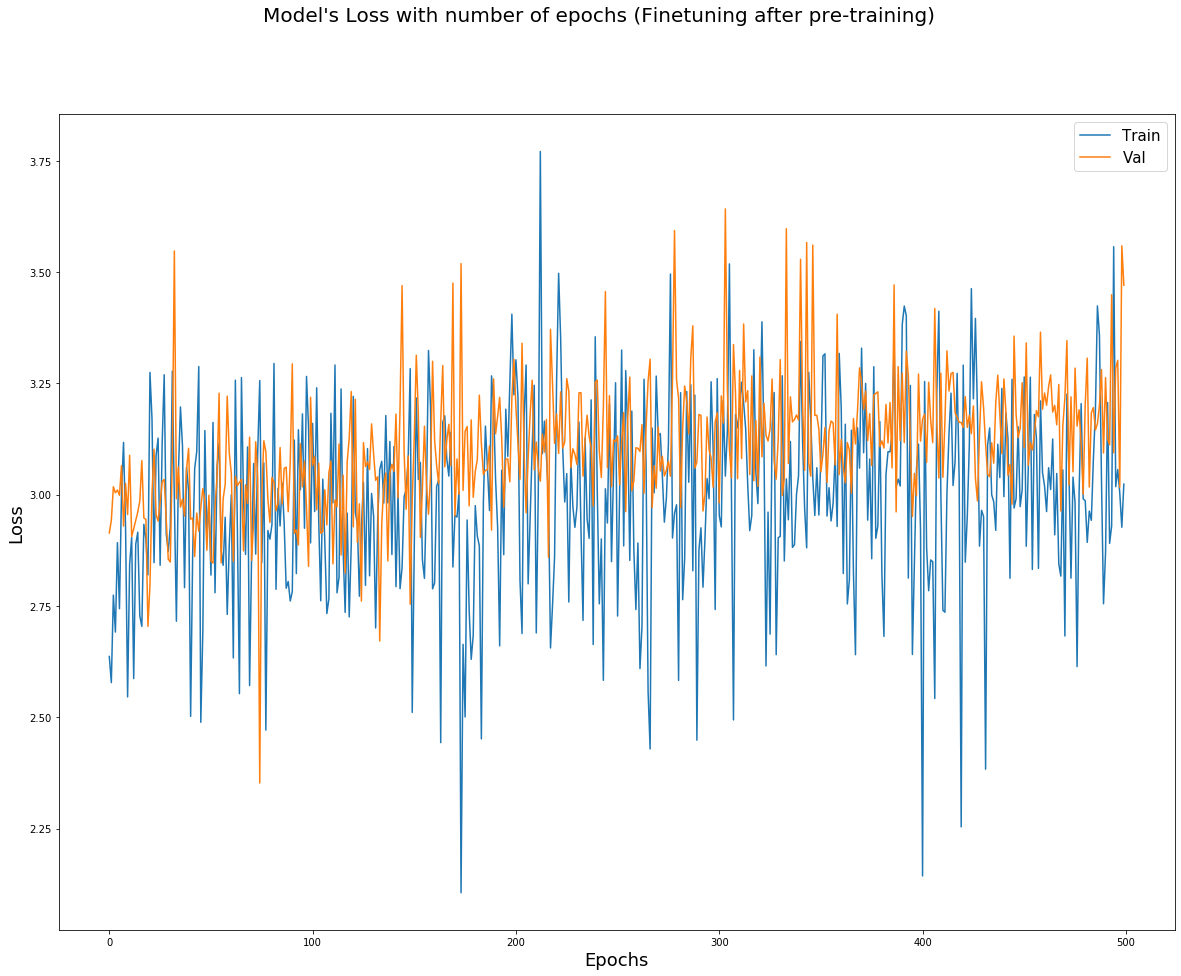

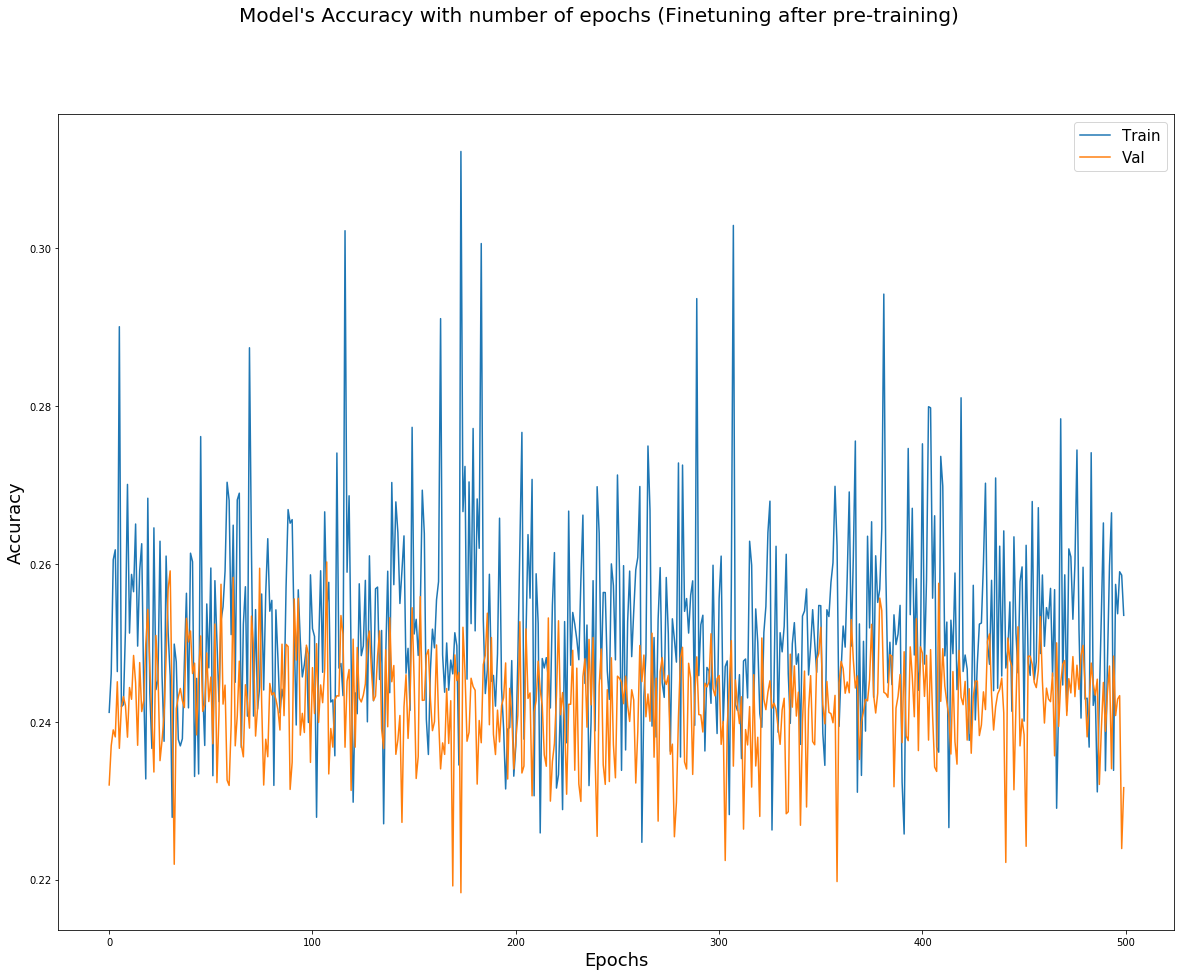

In [81]:
try:
    for round_num in tqdm(range(0, NUM_ROUNDS)):

        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        keras_evaluate(server_state, val_data)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        np.save('train_accuracy_finetuning.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save('val_accuracy_finetuning.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        np.save('train_loss_finetuning.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save('val_loss_finetuning.npy', val_metrics_tracker.get_metrics_by_name('loss'))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Model\'s Loss with number of epochs (Finetuning after pre-training)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    fig.savefig('Loss_with_Epochs_finetuning.jpg')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Model\'s Accuracy with number of epochs (Finetuning after pre-training)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    fig2.savefig('Accuracy_with_Epochs_finetuning.jpg')
    plt.show()

### Retrieve the previously saved numpy arrays for Loss and Accuracy for Training without any pretraining

In [82]:
import numpy as np
train_loss_no_pt_embed = np.load('train_loss_no_pt_embed.npy')
train_accuracy_no_pt_embed = np.load('train_accuracy_no_pt_embed.npy')
val_loss_no_pt_embed = np.load('val_loss_no_pt_embed.npy')
val_accuracy_no_pt_embed = np.load('val_accuracy_no_pt_embed.npy')

### Plot Model's Loss for both models, with and without any pre-training

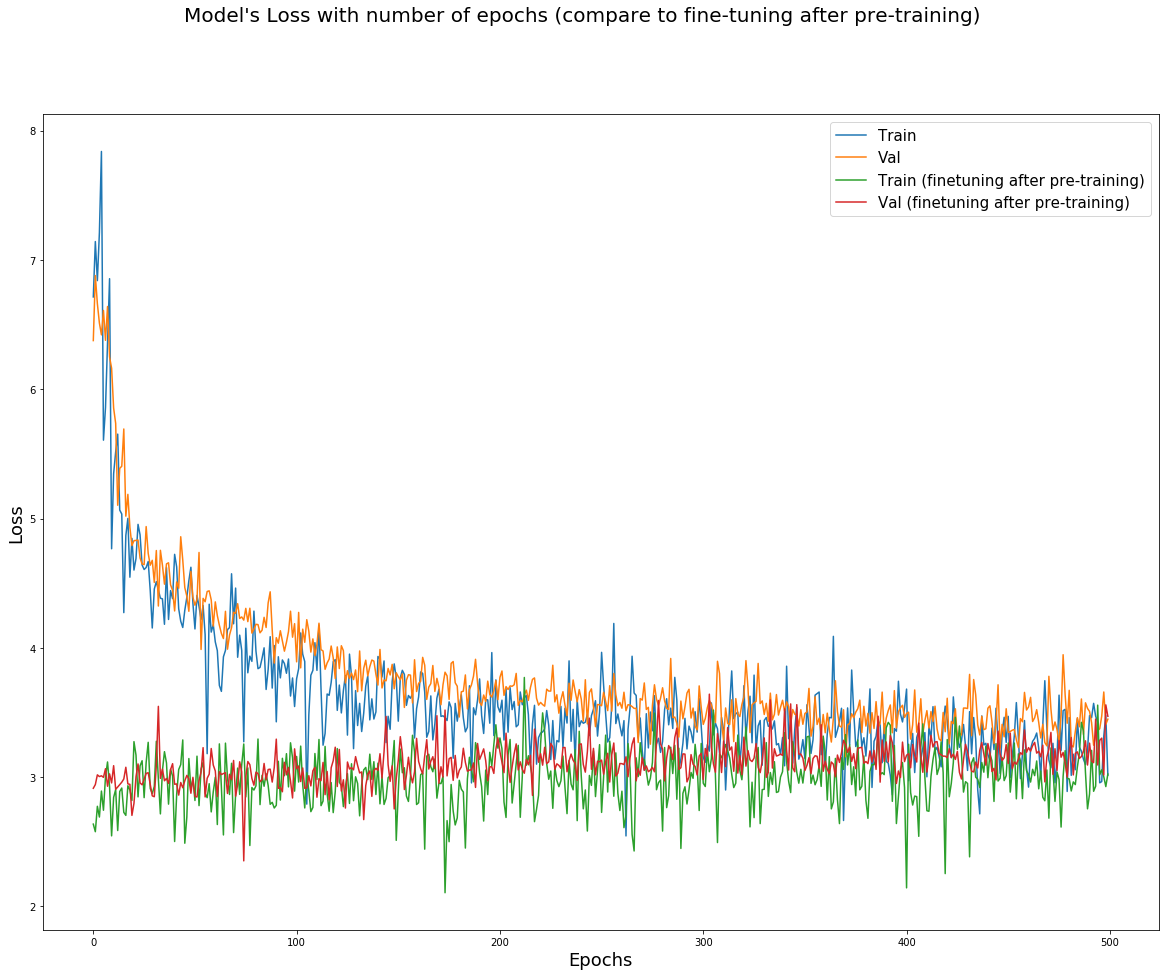

In [84]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train (finetuning after pre-training)')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val (finetuning after pre-training)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs (compare to fine-tuning after pre-training)', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_compare_finetuning.jpg')
plt.show()

### Plot Model's Accuracy for both models, with and without any pre-training

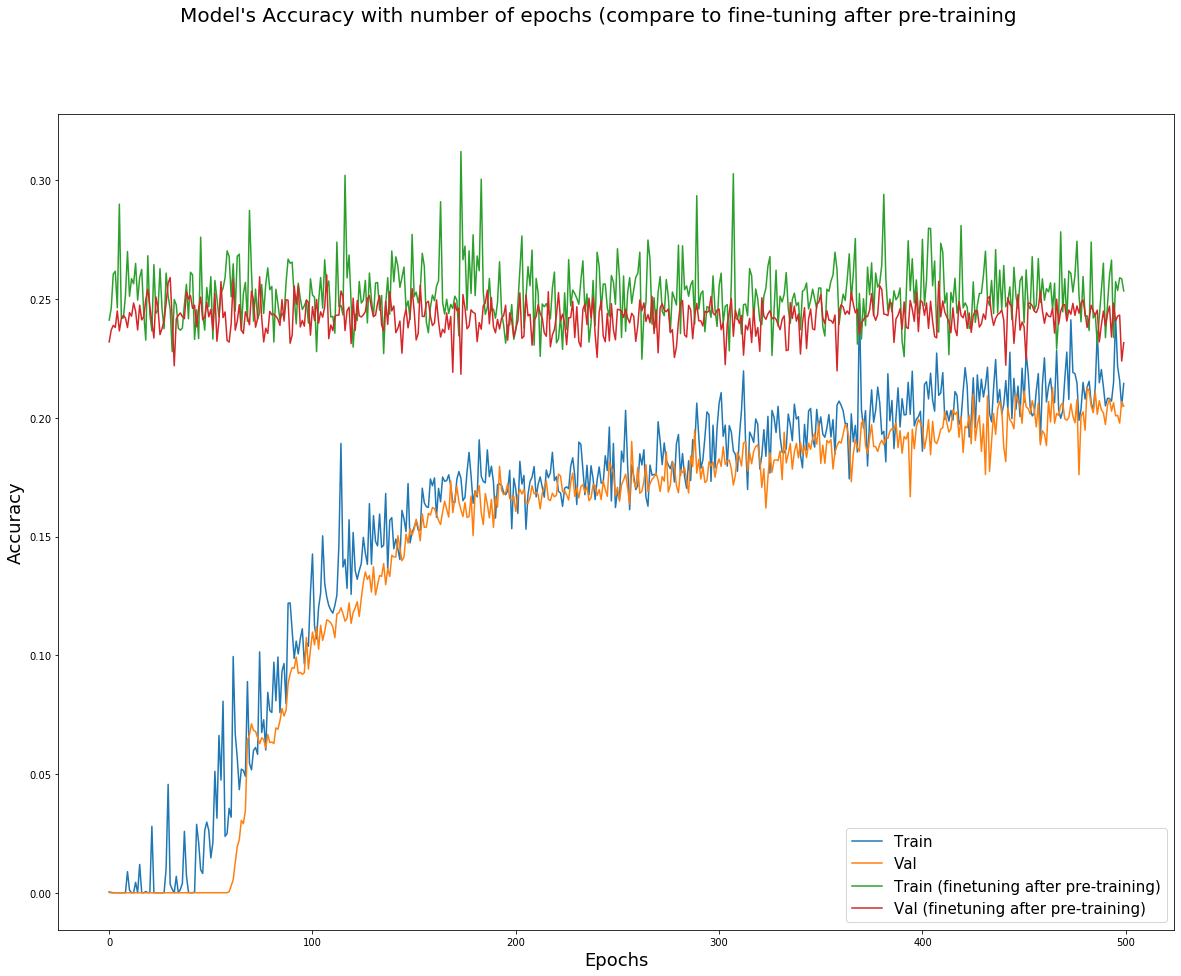

In [85]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train (finetuning after pre-training)')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val (finetuning after pre-training)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs (compare to fine-tuning after pre-training', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_compare_finetuning.jpg')
plt.show()

### Get Final Evaluation

In [86]:
keras_evaluate(server_state, val_data)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1189 - num_tokens: 131630.0000 - num_tokens_no_oov: 127710.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2420 - accuracy_no_oov_no_eos: 0.2025


### Generate Text

In [87]:
tff.learning.assign_weights_to_keras_model(keras_model, server_state.model)
print(generate_text(keras_model, "How are you today"))

how are you today , ? eos pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad
